# **<h3 align="center">Machine Learning II</h3>**
**Group members:**<br>David Duarte - 20221899@novaims.unl.pt - 20221899<br>
Marta Alves  - 20221890@novaims.unl.pt - 20221890<br>
Renato Bernardino  - 20221960@novaims.unl.pt - 20221960<br>


# 1. Import the Libraries <a class="anchor" id="chapter1"></a> 

Importing libraries like those listed in the cell below is critical for activities involving data processing, numerical calculations, visualization, and machine learning. These libraries provide the necessary functions and tools for preparing data, pattern analysis, consumer segmentation, and developing targeted marketing campaigns.

In [1]:
%pip install optuna
%pip install umap-learn
%pip install pyECLAT
%pip install mlxtend
%pip install joblib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px

from shapely.geometry import Point
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, confusion_matrix, euclidean_distances

import umap
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from joblib import Parallel, delayed
from pyECLAT import ECLAT

import ast
import warnings
import math
import csv

from matplotlib.patches import Patch
from utils import *

# Pandas options
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_colwidth', None)

# Suppress warnings
warnings.filterwarnings("ignore")

# 2. Import the Dataset <a class="anchor" id="chapter2"></a>

In this section, we import the different datasets and set the customer_id as the index column in the "customer_info" and "customer_basket". 

In [29]:
customer_basket = pd.read_csv('customer_basket.csv' ,index_col=2)  #import
product_mapping = pd.read_excel('product_mapping.xlsx')            #import
customer_info = pd.read_csv('customer_info.csv', index_col=1)      #import
customer_info.drop(customer_info.columns[0], axis=1, inplace=True)  #Removing unnecessary column

# 3. Description of the Dataset’s Structure<a class="anchor" id="chapter3"></a>

The <span style='color:Blue'> info()  </span> method prints information about the DataFrame. Using this method we can also see that there are some missing values. For example, in column *loyalty_card_number*, *typical_hour*,*kids_home*,*number_complaints*, *teens_home*, *distinct_stores_visited*, *lifetime_spend_vegetables* ,*lifetime_spend_fish*. In chapter **4.2. Feature's Transformation** we will treat these missing values.

In [14]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43631 entries, 39634 to 5120
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customer_name                            43631 non-null  object 
 1   customer_gender                          43631 non-null  object 
 2   customer_birthdate                       43631 non-null  object 
 3   kids_home                                43107 non-null  float64
 4   teens_home                               42610 non-null  float64
 5   number_complaints                        42977 non-null  float64
 6   distinct_stores_visited                  42322 non-null  float64
 7   lifetime_spend_groceries                 43631 non-null  float64
 8   lifetime_spend_electronics               43631 non-null  float64
 9   typical_hour                             41886 non-null  float64
 10  lifetime_spend_vegetables                42

The <span style='color:Blue'> describe()  </span> method  is used for calculating some statistical data. The features: *customer_name*, *customer_gender*, and *customer_birthdate* don't have any statistical data since they're categorical features. <br> Using this method we can also see some "weird" values such as the max value of the collum *lifetime_spend_fish*

In [15]:
customer_info.describe()

kids_home    teens_home  number_complaints  distinct_stores_visited  \
count  43107.000000  42610.000000       42977.000000             42322.000000   
mean       1.081263      0.847829           0.705726                 1.669959   
std        1.239257      0.840397           0.624624                 1.034825   
min        0.000000      0.000000           0.000000                 1.000000   
25%        0.000000      0.000000           0.000000                 1.000000   
50%        1.000000      1.000000           1.000000                 1.000000   
75%        1.000000      1.000000           1.000000                 2.000000   
max        9.000000      6.000000           9.000000                 8.000000   

       lifetime_spend_groceries  lifetime_spend_electronics  typical_hour  \
count              43631.000000                43631.000000  41886.000000   
mean                5600.030047                 2000.058468     13.520580   
std                 4602.647746                 3004.924537      4.558057   
min                    0.000000                    0.000000      6.000000   
25%                 2184.500000                  218.000000     10.000000   
50%                 4071.000000                  574.000000     13.000000   
75%                 6605.500000                 2565.500000     17.000000   
max                26552.000000                21273.000000     24.000000   

       lifetime_spend_vegetables  lifetime_spend_nonalcohol_drinks  \
count               42758.000000                      43631.000000   
mean                  456.893938                        443.636657   
std                   312.832282                        210.313287   
min                     0.000000                          0.000000   
25%                   227.000000                        297.000000   
50%                   387.000000                        419.000000   
75%                   584.000000                        560.000000   
max                  2112.000000                       2224.000000   

       lifetime_spend_alcohol_drinks  ...  lifetime_spend_fish  \
count                   43631.000000  ...         42322.000000   
mean                      494.073365  ...          1471.423846   
std                       524.269783  ...          3910.163766   
min                         0.000000  ...             0.000000   
25%                       145.000000  ...           187.000000   
50%                       320.000000  ...           641.000000   
75%                       646.000000  ...          1570.000000   
max                      5091.000000  ...         50381.000000   

       lifetime_spend_hygiene  lifetime_spend_videogames  \
count            43631.000000               43631.000000   
mean               916.948408                 990.334922   
std                729.744050                1241.658577   
min                  0.000000                   0.000000   
25%                372.000000                 204.000000   
50%                668.000000                 557.000000   
75%               1437.000000                1111.000000   
max               3487.000000                5389.000000   

       lifetime_spend_petfood  lifetime_total_distinct_products  \
count            43631.000000                      43631.000000   
mean              2023.225619                        387.260182   
std               2926.355387                        411.436756   
min                  0.000000                          0.000000   
25%                517.000000                         97.000000   
50%                874.000000                        252.000000   
75%               2217.000000                        537.000000   
max              19596.000000                       3544.000000   

       percentage_of_products_bought_promotion  year_first_transaction  \
count                             43631.000000            43631.000000   
mean                                  0.229431             2011.342

# 4. Exploring the Dataset <a class="anchor" id="chapter4"></a>

In  this chapter of the project we are focusing on exploring and preprocessing the dataset. <br>
It consists of several steps, including identifying and treating potential data inconsistencies, transforming features, analyzing the dataset based on location, detecting and handling outliers to better understand our features, examining the correlation matrix, and selecting the final features for the following steps.

## 4.1. Identification and Treatment of Possible Data Inconsistencies <a class="anchor" id="section_4_1"></a>

In this section we perform several checks and treatments to ensure data quality. <br>
This entails some variables transformation, removing constant characteristics that don't offer insightful information, and dealing with missing values using methods like imputation or exclusion. These procedures are essential for preserving data integrity and enhancing the accuracy of later analysis and modeling efforts.

### 4.1.1. Variable Transformation <a class="anchor" id="sub_section_4_1_1"></a>

First, we converted the customer gender data into numerical values for easier processing and analysis. Specifically, we encoded male customers as 0 and female customers as 1. Additionally, we updated the loyalty card information to a binary format: customers who have a loyalty card were assigned a value of 1, while those without a loyalty card were assigned a value of 0.

In [30]:
customer_info['customer_gender'] = [0 if gender=='male' else 1 for gender in customer_info['customer_gender']]  #Tranforming Customer_Gender to a binary format
customer_info["loyalty_card_number"] = [0 if pd.isna(number) else 1 for number in customer_info["loyalty_card_number"]]  #Tranforming Loyalty_card_number to a binary format
customer_info = customer_info.rename(columns={"loyalty_card_number": "has_loyalty_card"})                              #Rename column

The customer birthdate is a very detailed variable, so it is necessary to create a variable for the year of birth.

In [31]:
customer_info['customer_birthdate'] = pd.to_datetime(customer_info['customer_birthdate'])
customer_info['customer_birth_year'] = customer_info['customer_birthdate'].dt.year

We created a new column, lifetime_spend, which represents the total spending across all product categories for each customer. For clients with missing values in any of the product categories, we imputed these missing values with the median of the respective column in a copy of the dataset before calculating the total spend. To emphasize, we did not impute missing values in the original dataset.

In [32]:
# Filter columns that contain 'lifetime_spend'
lifetime_spend_columns = customer_info.filter(like='lifetime_spend').columns
customer_median=customer_info.copy()    #creating the copy dataset
# Calculate the median for each column and fill missing values with the median
for column in lifetime_spend_columns:
    median_value = customer_info[column].median()
    customer_median[column].fillna(median_value, inplace=True)

# Create the total_spent column by summing the filtered columns
customer_info['total_spent'] = customer_median[lifetime_spend_columns].sum(axis=1)

Created a variable customer_info_num with all numeric information of the dataset

In [33]:
customer_info_num = customer_info.select_dtypes(include=['number'])

### 4.1.2. Visualization <a class="anchor" id="sub_section_4_1_2"></a>



In order to gain a better understanding of our data and the distribution of customers based on latitude and longitude, we conducted data visualization by plotting. This map helped us explore the geographical distribution of customers and provided insights into the density and clustering of customer locations.

In [25]:
# Selecting latitude and longitude columns from the customer_info DataFrame
cust_geo = customer_info[['latitude', 'longitude']]

# Define a function to create a GeoPoint from longitude and latitude values
def create_geopoint(row):
    return Point(row['longitude'], row['latitude'])

# Apply the create_geopoint function to each row to create a new column 'geometry' containing GeoPoints
cust_geo['geometry'] = cust_geo.apply(create_geopoint, axis=1)

# Convert the DataFrame to a GeoDataFrame using GeoPandas
geo_customer_info = gpd.GeoDataFrame(cust_geo, geometry='geometry')

# Create a scatter plot on Mapbox using Plotly Express
fig = px.scatter_mapbox(
    geo_customer_info,                                            # DataFrame containing customer geography information
    lat=geo_customer_info['latitude'],                            
    lon=geo_customer_info['longitude'],                           
    color_discrete_sequence=['green'],                            # Set color to green (adjust as needed)
    size_max=10,                                                  # Maximum size of the points
    zoom=3,                                                       # Initial zoom level of the map
    mapbox_style="carto-positron",                                # Map style
    title='Customer Locations'                                    # Plot title
)

# Show the plot
fig.show()


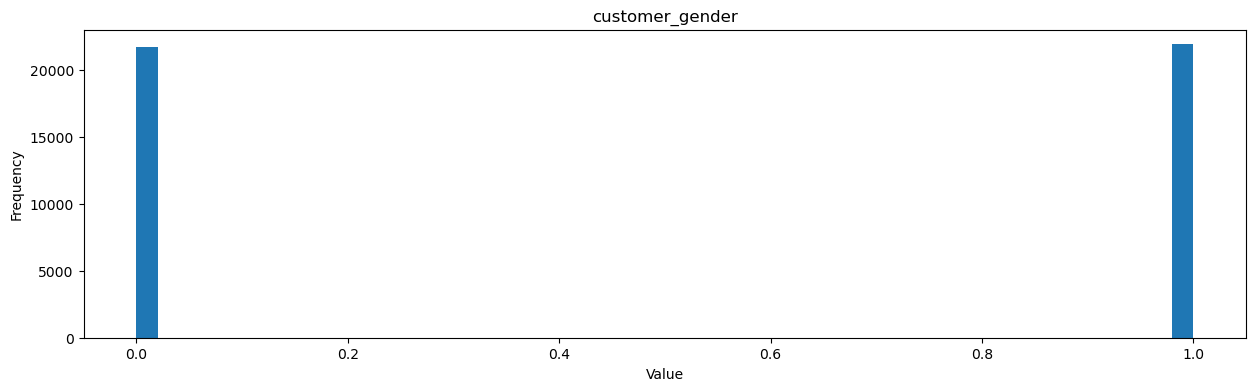

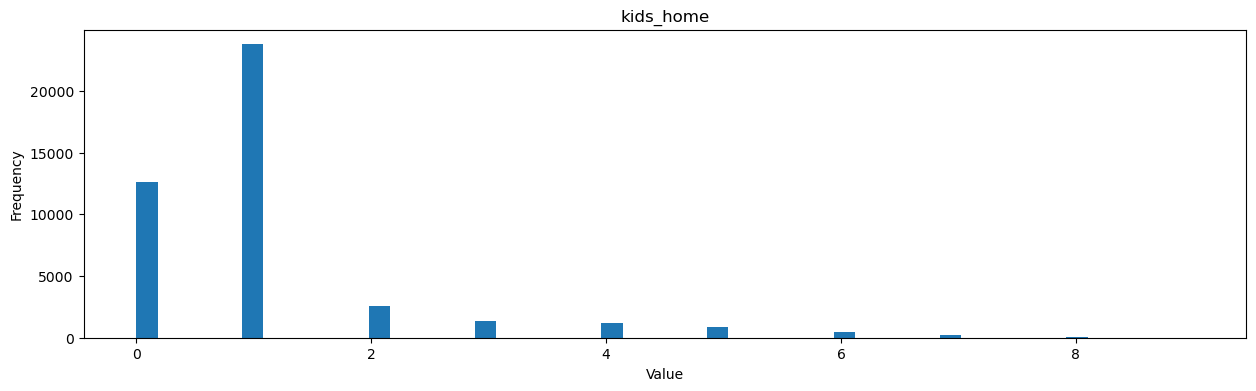

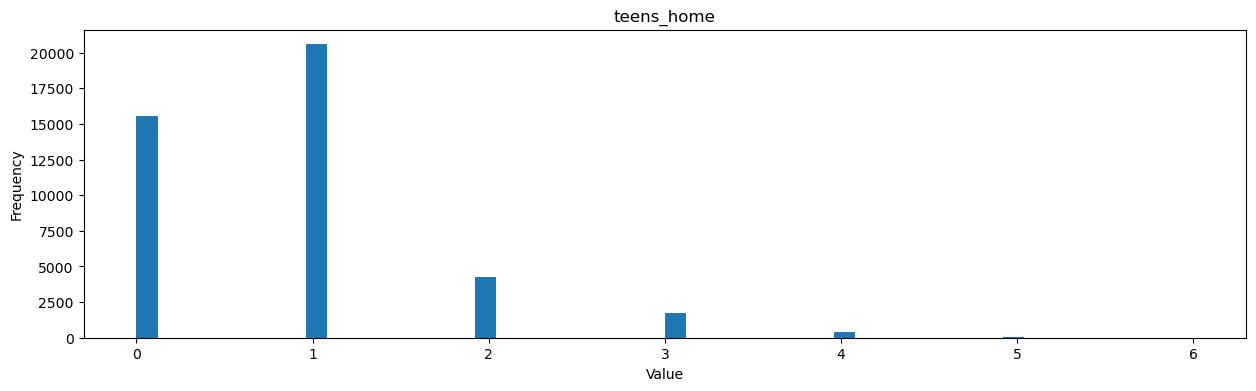

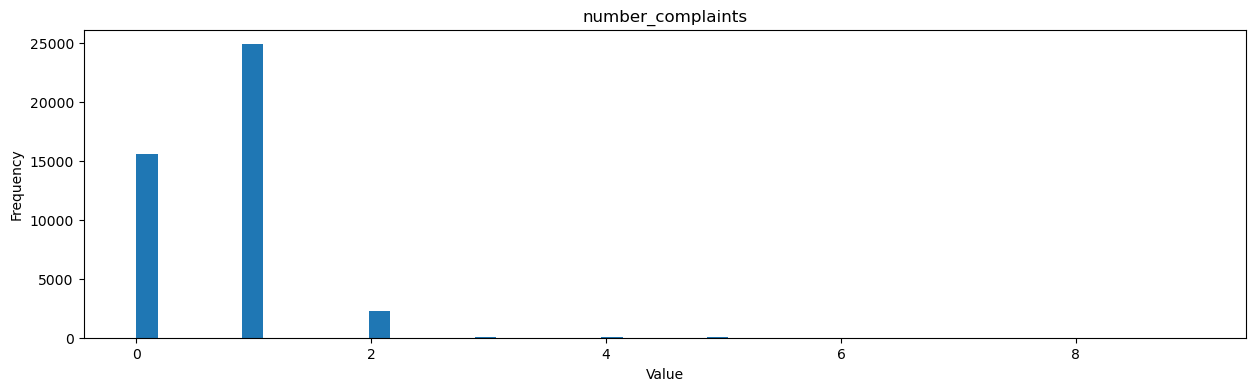

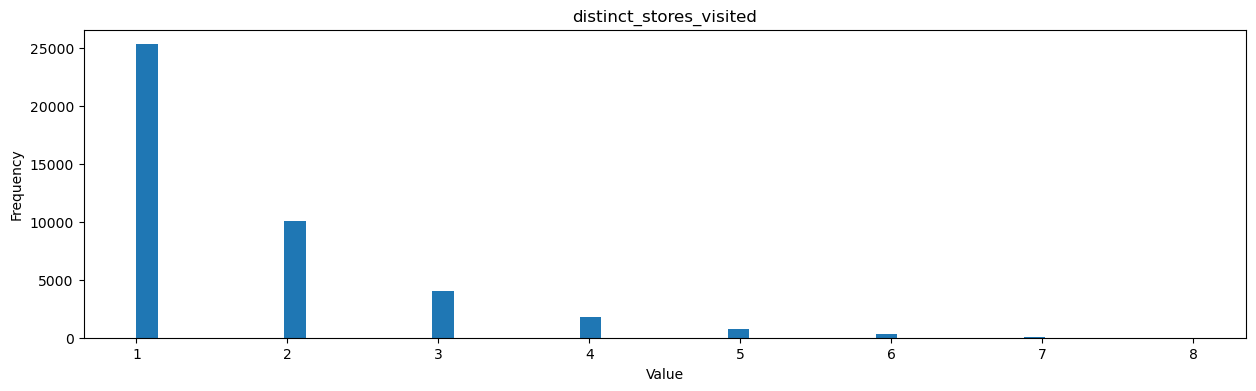

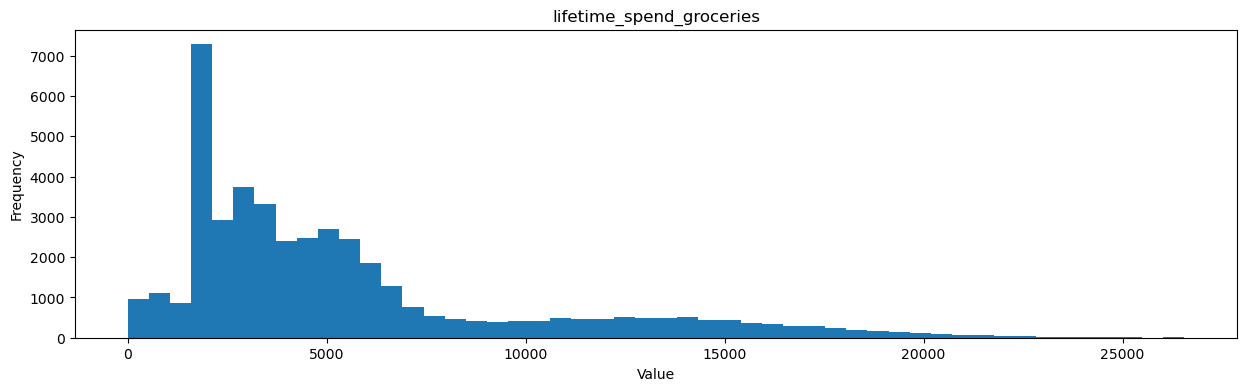

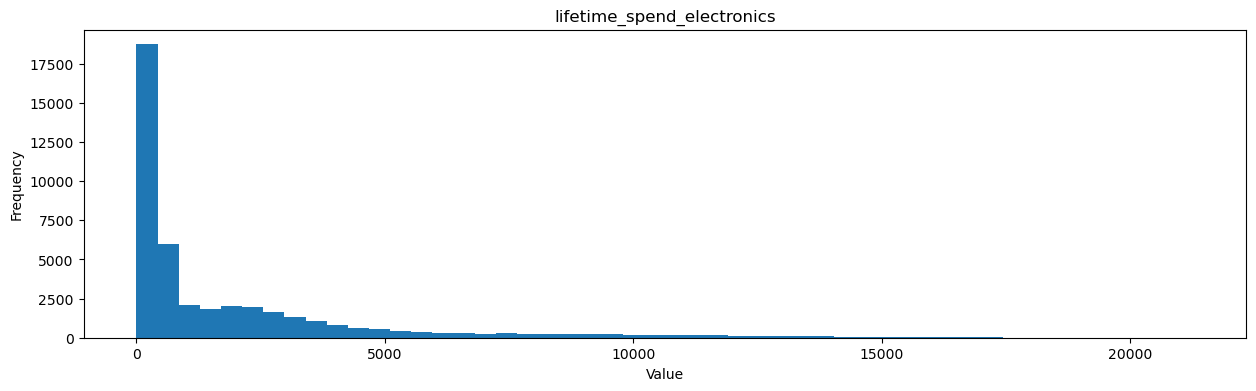

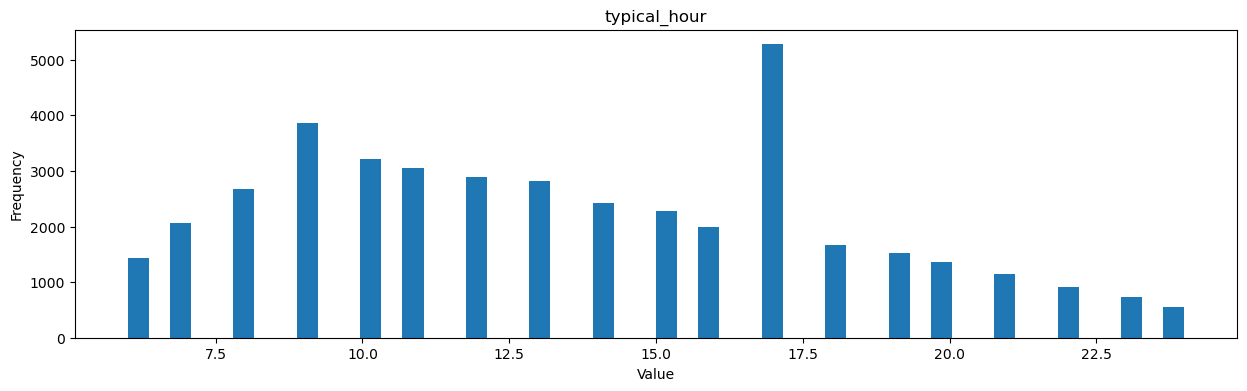

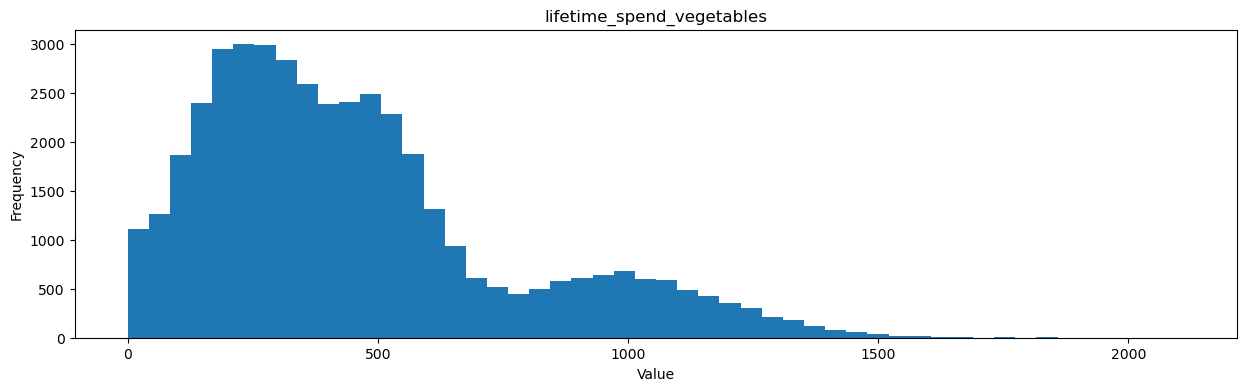

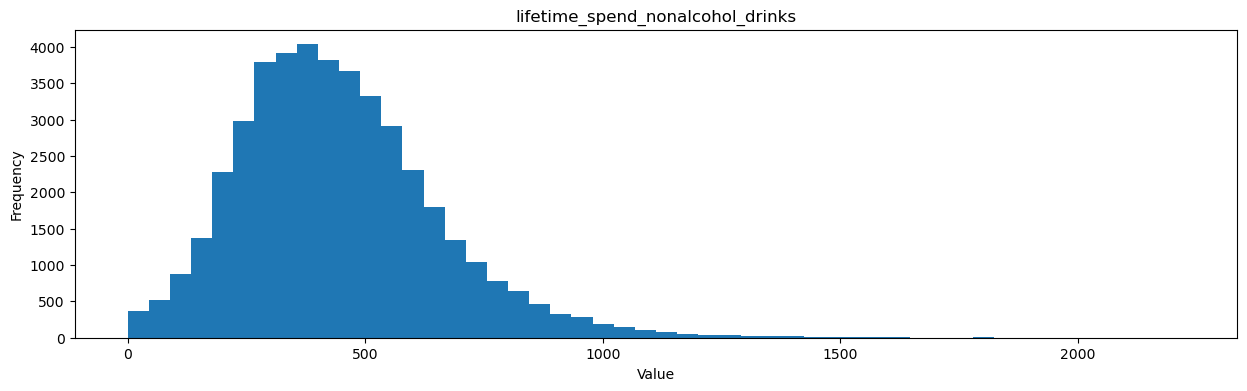

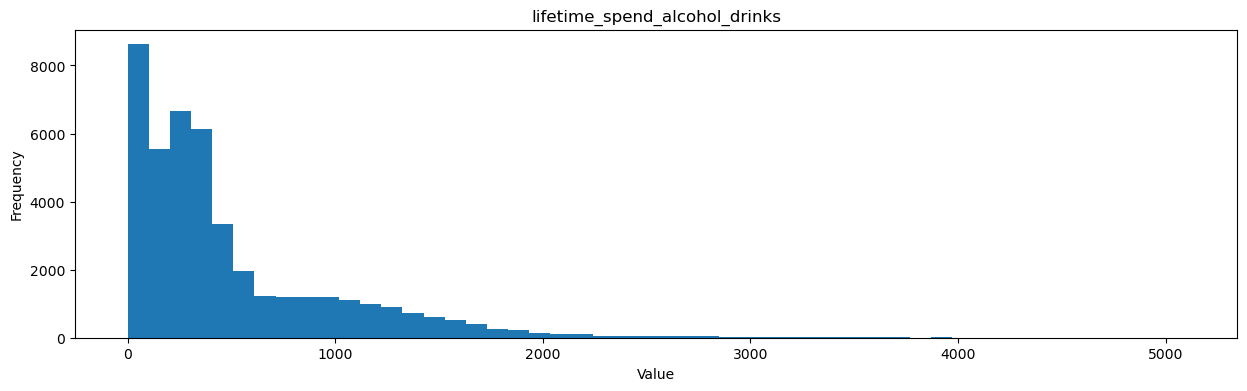

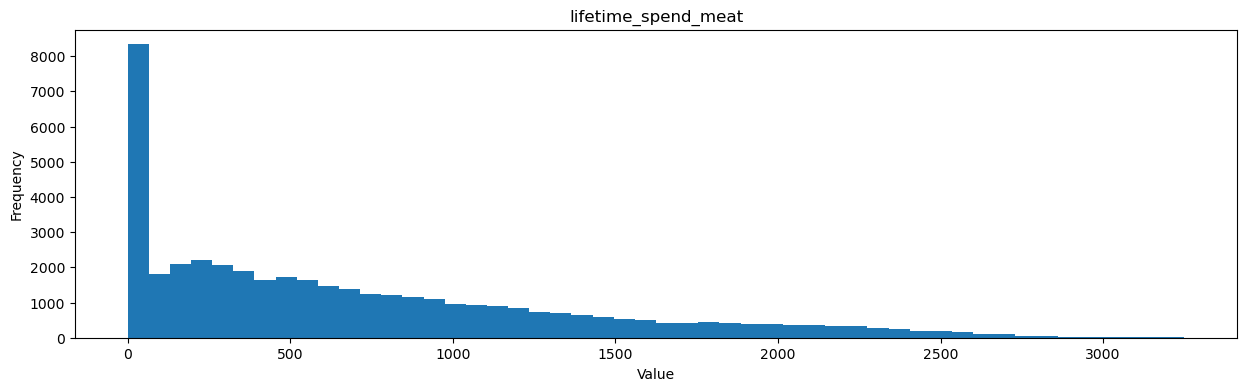

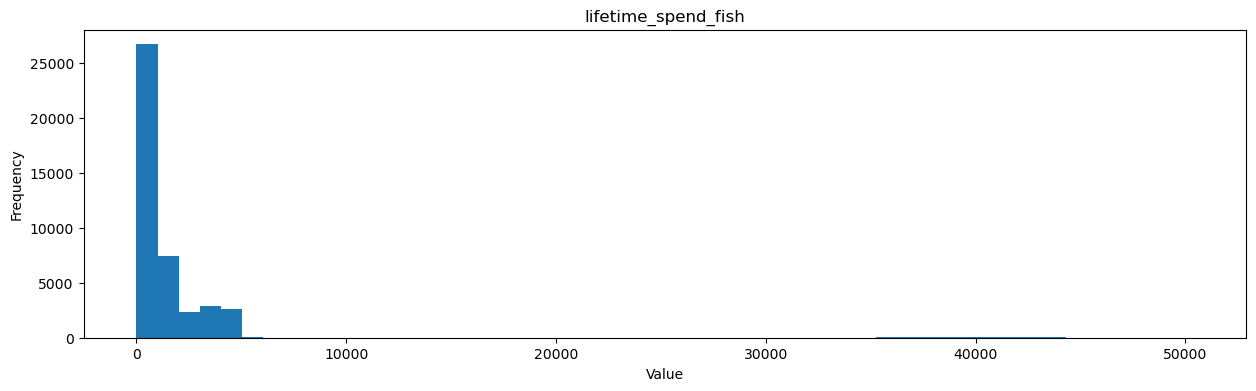

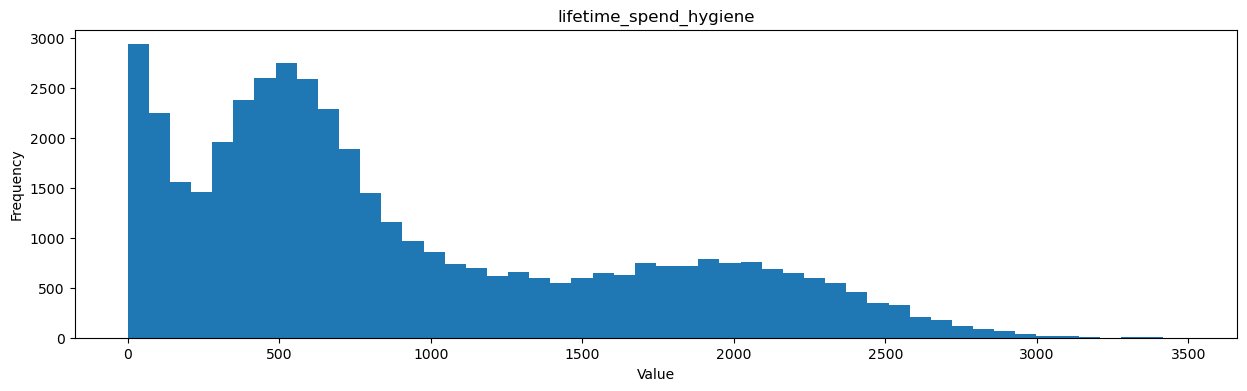

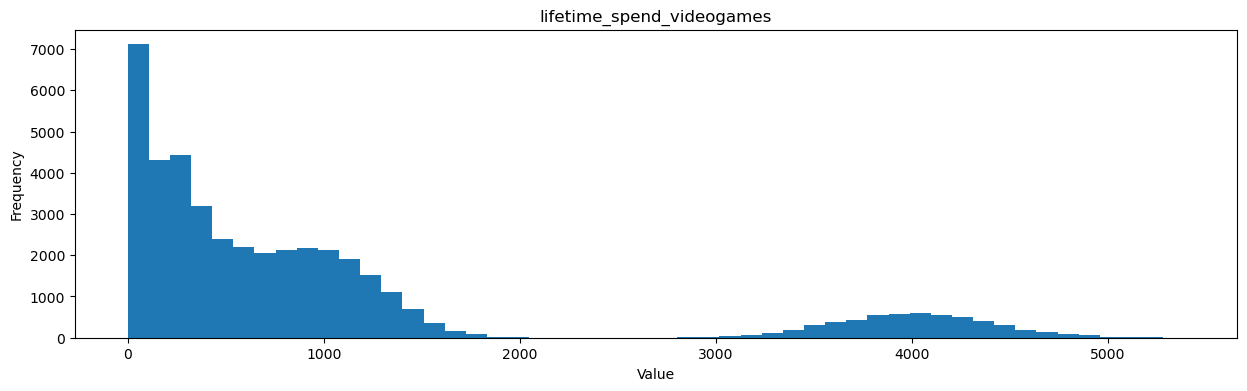

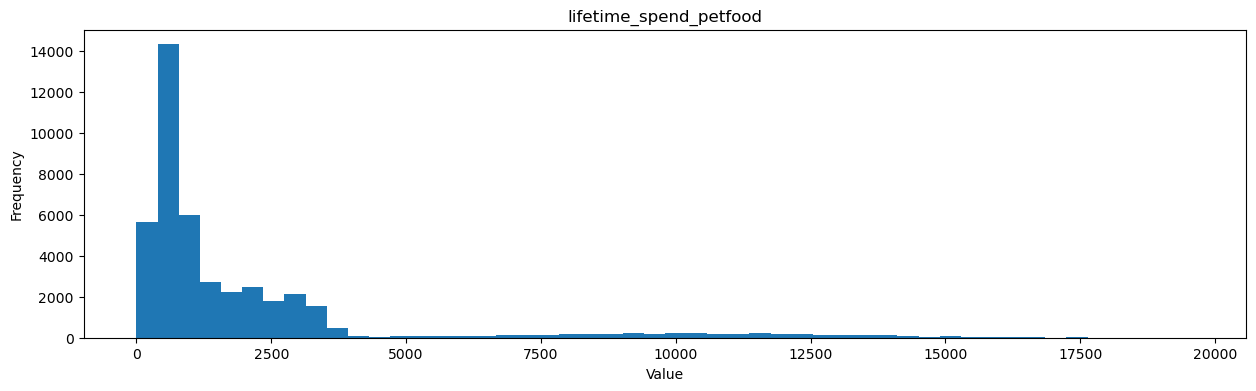

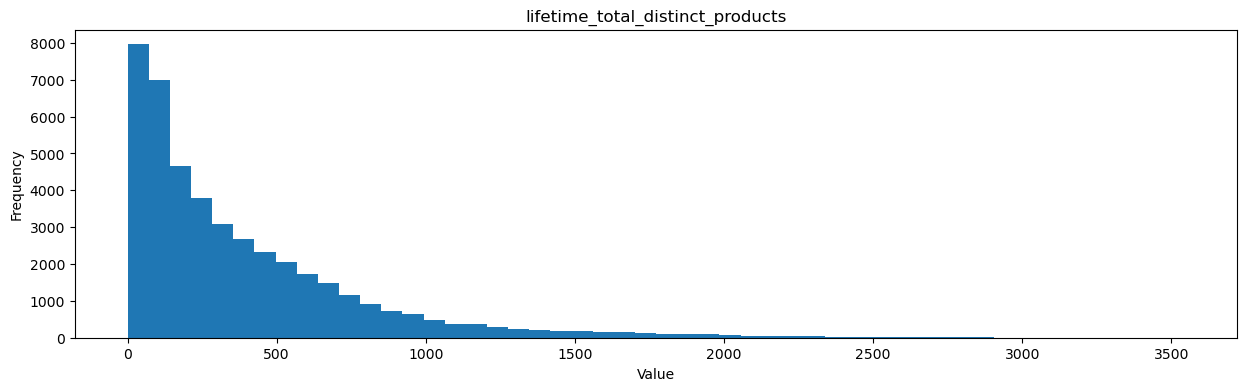

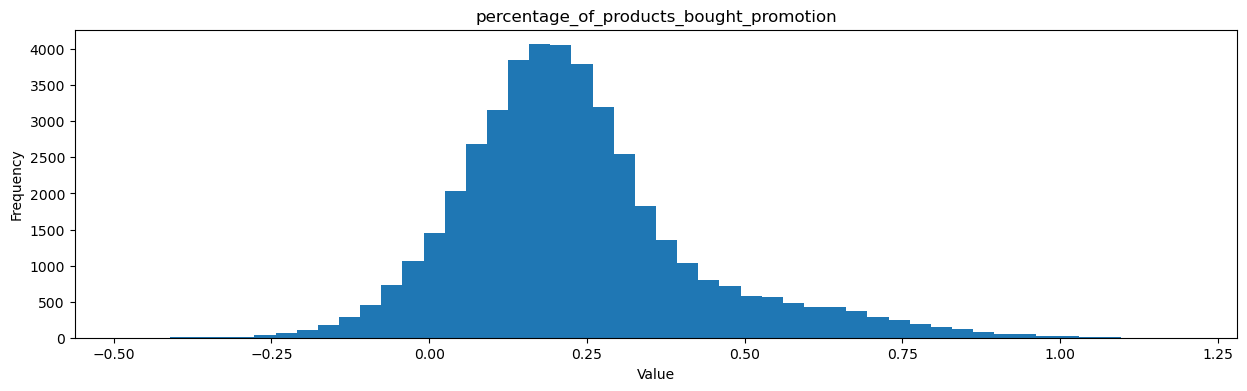

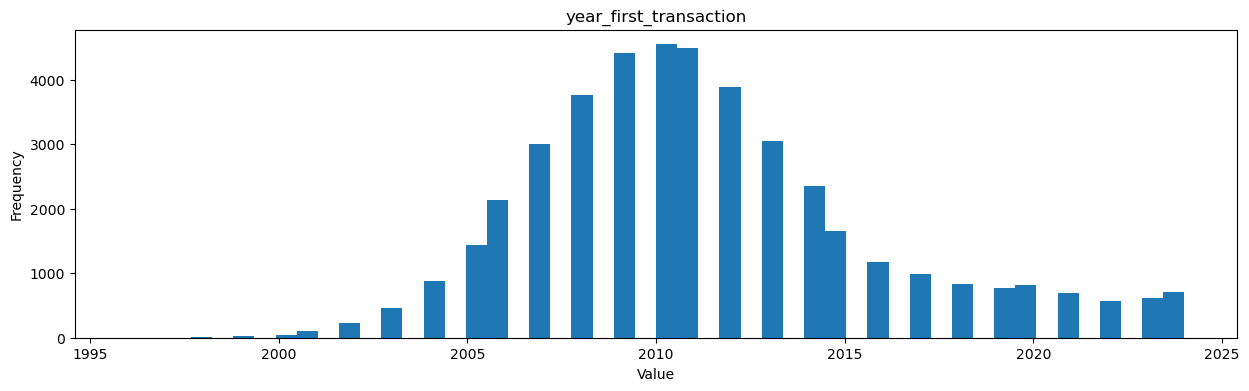

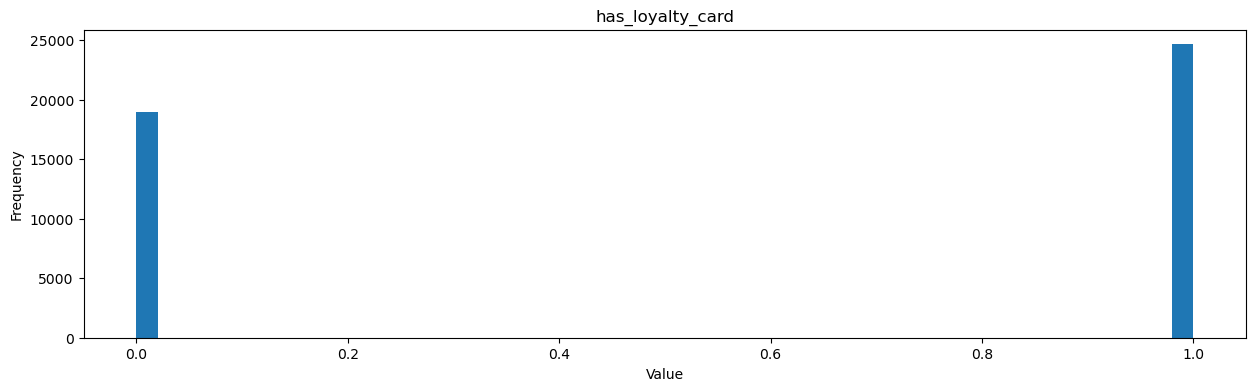

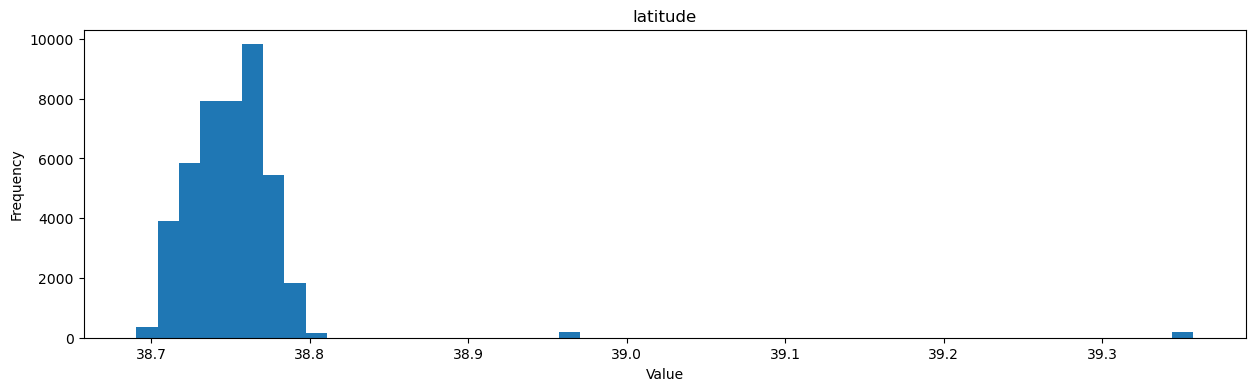

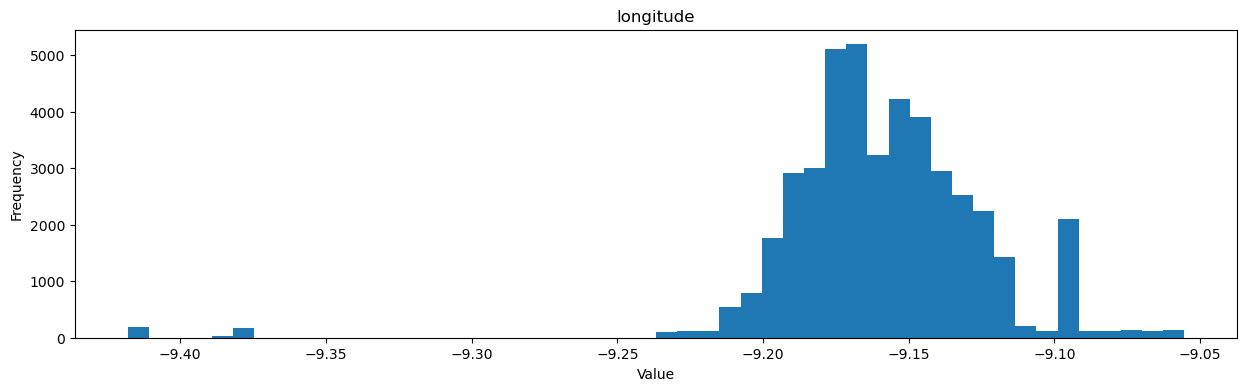

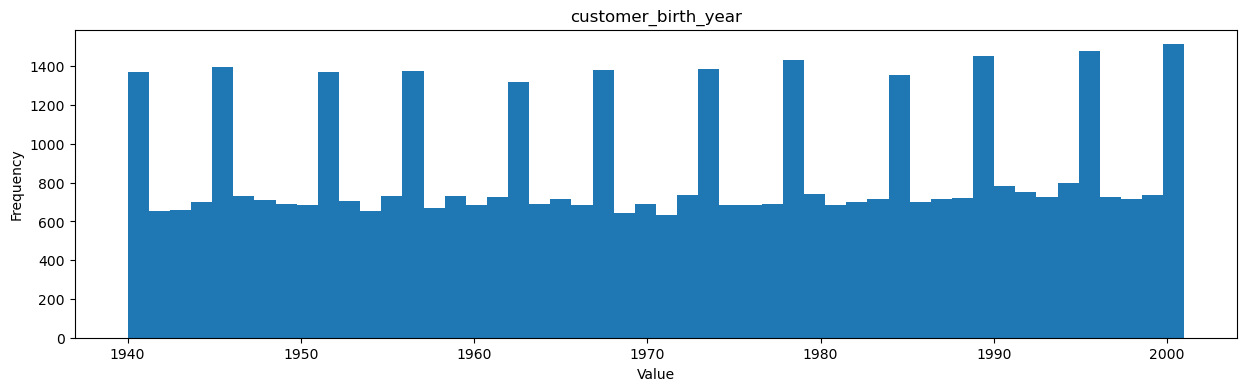

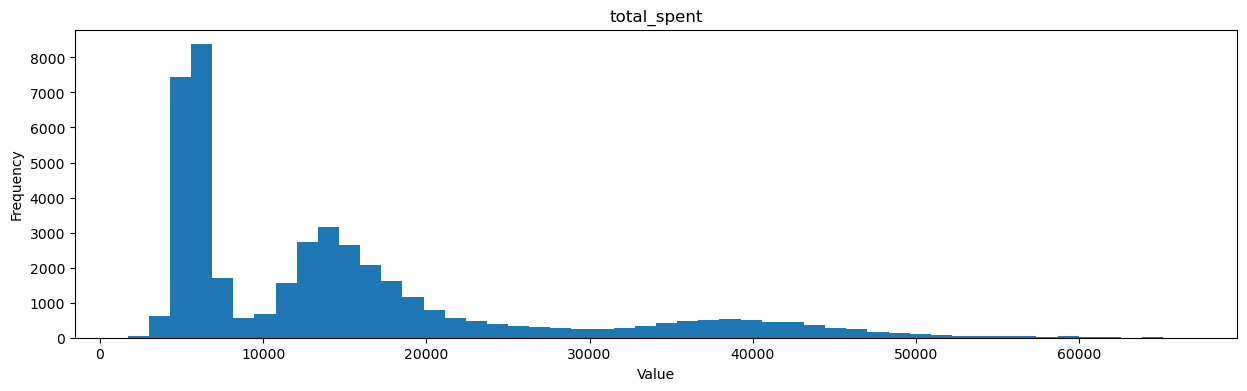

In [8]:
for column in customer_info_num.columns:
    plt.figure(figsize=(15, 4))                   # Adjust the figure size as needed
    plt.hist(customer_info_num[column], bins=50)  # Adjust bins as needed
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

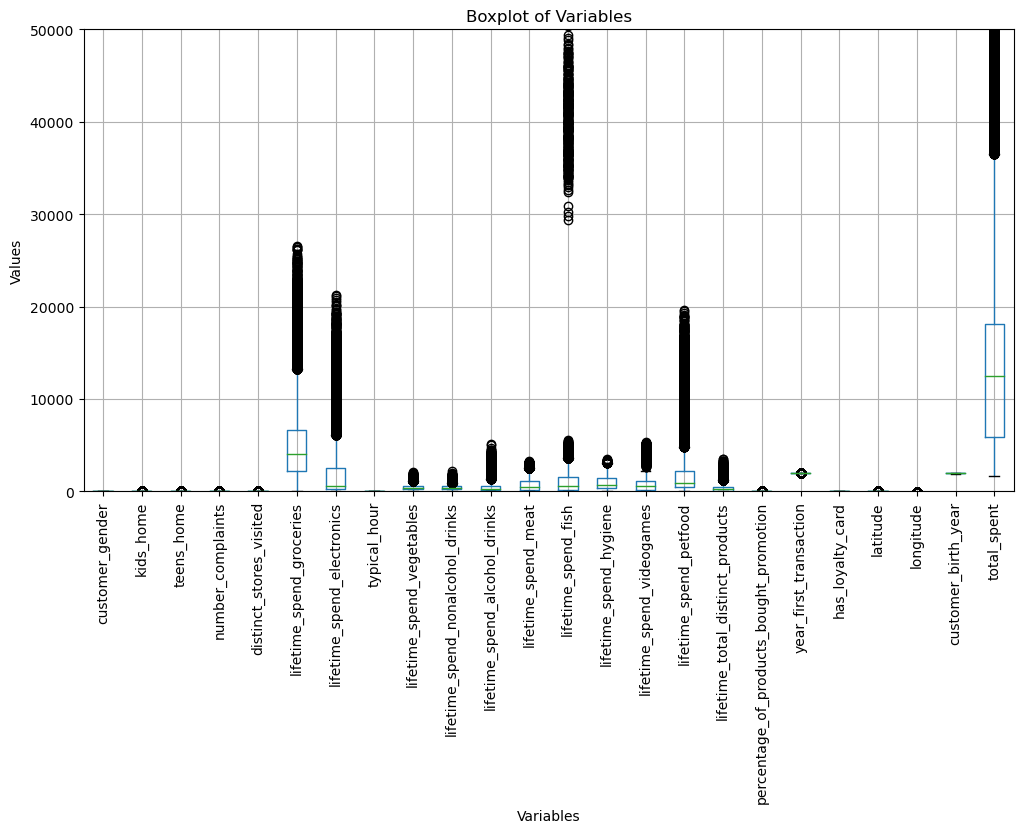

In [33]:
plt.figure(figsize=(12, 6))

# Create boxplot
boxplot = customer_info_num.boxplot()

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Variables')
plt.ylabel('Values')
plt.title('Boxplot of Variables')
plt.ylim(bottom=0, top=50000)

plt.show()


Our examination of histograms and boxplots reveals significant outliers and right-skewed distributions in the majority of variables.

### 4.1.3. Missing values <a class="anchor" id="sub_section_4_1_3"></a>

Building upon our prior discussion regarding the presence of missing values, this segment of the project will focus on their treatment. We will employ feature selection techniques for each variable, making sure only important variables for each target are used for imput. And utilize methods such as the holdout method and cross-validation to determine the most effective imputation strategies.

By systematically evaluating various imputation methods through rigorous validation approaches, we aim to identify optimal techniques for handling missing data. 

First we check how many missing values per category

In [10]:
missing_values = customer_info.isnull().sum()

# Filter columns with missing values
columns_with_missing_values = missing_values[missing_values > 0]

# Display columns with missing values
print("Columns with missing values:")
print(columns_with_missing_values)

Columns with missing values:
kids_home                     524
teens_home                   1021
number_complaints             654
distinct_stores_visited      1309
typical_hour                 1745
lifetime_spend_vegetables     873
lifetime_spend_fish          1309
dtype: int64


Now we want to see the correlation between variables

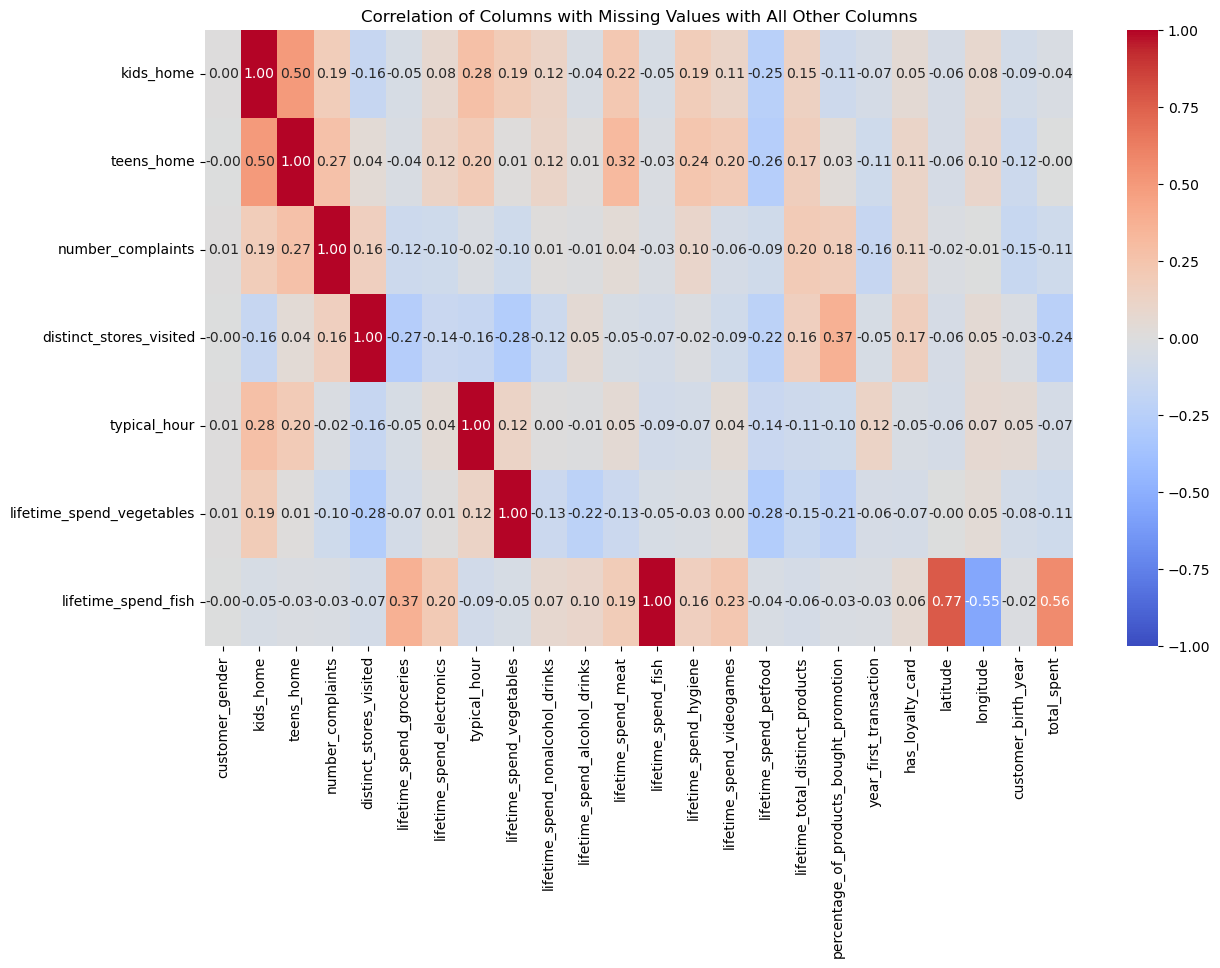

In [11]:
# Calculate correlation matrix including all columns
correlation_matrix_all = customer_info_num.corr()

# Filter correlation matrix for columns with missing values
correlation_matrix_filtered = correlation_matrix_all.loc[columns_with_missing_values.index]


# Create a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation of Columns with Missing Values with All Other Columns')
plt.show()

Data Scaling with RobustScaler

Given the presence of outliers in our dataset, we have opted for RobustScaler for data scaling. This choice reflects our intention to employ the most robust scaling method capable of handling outliers effectively. By utilizing RobustScaler, we aim to mitigate the influence of outliers on subsequent analyses and modeling processes, thereby ensuring the robustness and reliability of our results.


In [34]:
# Fit and transform the data using RobustScaler
scaler = RobustScaler()
customer_info_rb = scaler.fit_transform(customer_info_num)

# Convert the scaled array back to DataFrame
customer_info_rb = pd.DataFrame(customer_info_rb, columns=customer_info_num.columns, index=customer_info_num.index)



Creating a Dataset with all missing values and and the other with no missing values

In [13]:
# Create a dataset without missing values(train dataset)
customer_info_rb_no_missing = customer_info_rb.dropna()

# Create a dataset with records that contain missing values(evaluate dataset)
customer_info_rb_with_missing = customer_info_rb[customer_info_rb.isnull().any(axis=1)]

# Print the shapes of both datasets
print("Dataset without missing values shape:", customer_info_rb_no_missing.shape)
print("Dataset with missing values shape:", customer_info_rb_with_missing.shape)

Dataset without missing values shape: (36673, 24)
Dataset with missing values shape: (6958, 24)


Create a target dataframe

In [14]:
targets = customer_info_rb_no_missing[['kids_home', 'teens_home', 'number_complaints',
                                 'distinct_stores_visited', 'typical_hour',
                                 'lifetime_spend_vegetables', 'lifetime_spend_fish']]

Checking which features are more important for each target using lasso, we removed the variables with coeficient between [-0.1;0.1]

For target variable: kids_home
Lasso picked 11 variables and eliminated the other 12 variables
Eliminated variables: Index(['customer_gender', 'lifetime_spend_groceries',
       'lifetime_spend_electronics', 'lifetime_spend_fish',
       'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'has_loyalty_card', 'latitude', 'longitude', 'customer_birth_year',
       'total_spent'],
      dtype='object')



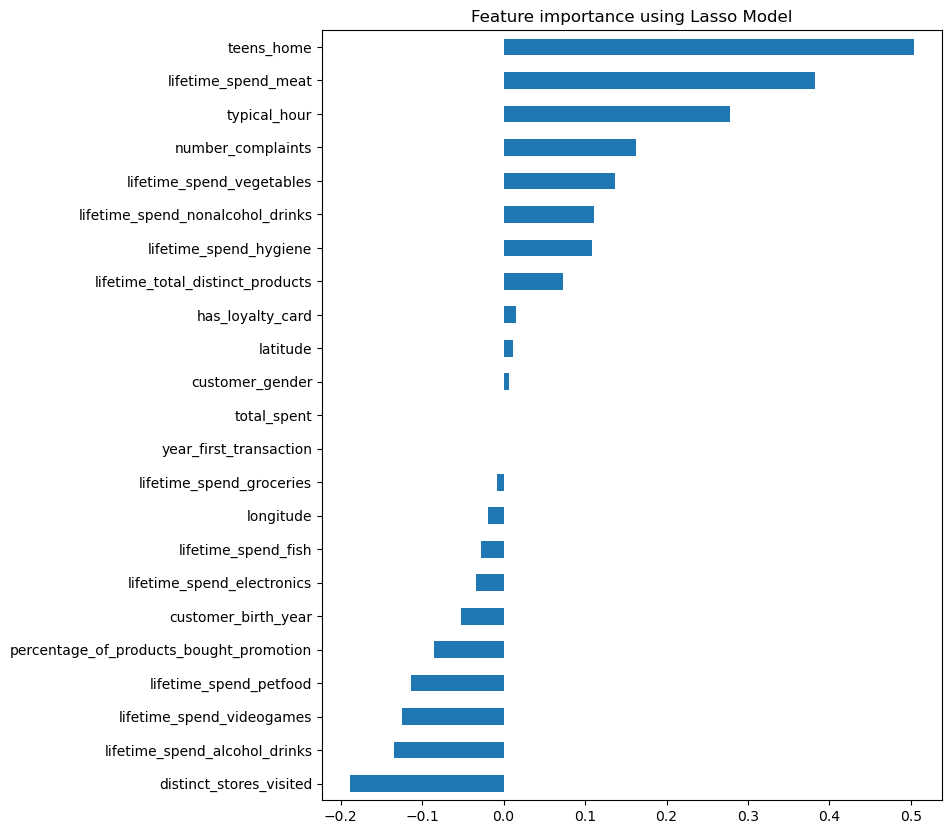

For target variable: teens_home
Lasso picked 5 variables and eliminated the other 18 variables
Eliminated variables: Index(['customer_gender', 'distinct_stores_visited',
       'lifetime_spend_groceries', 'lifetime_spend_electronics',
       'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks',
       'lifetime_spend_fish', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames', 'lifetime_spend_petfood',
       'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'has_loyalty_card', 'latitude', 'longitude', 'customer_birth_year',
       'total_spent'],
      dtype='object')



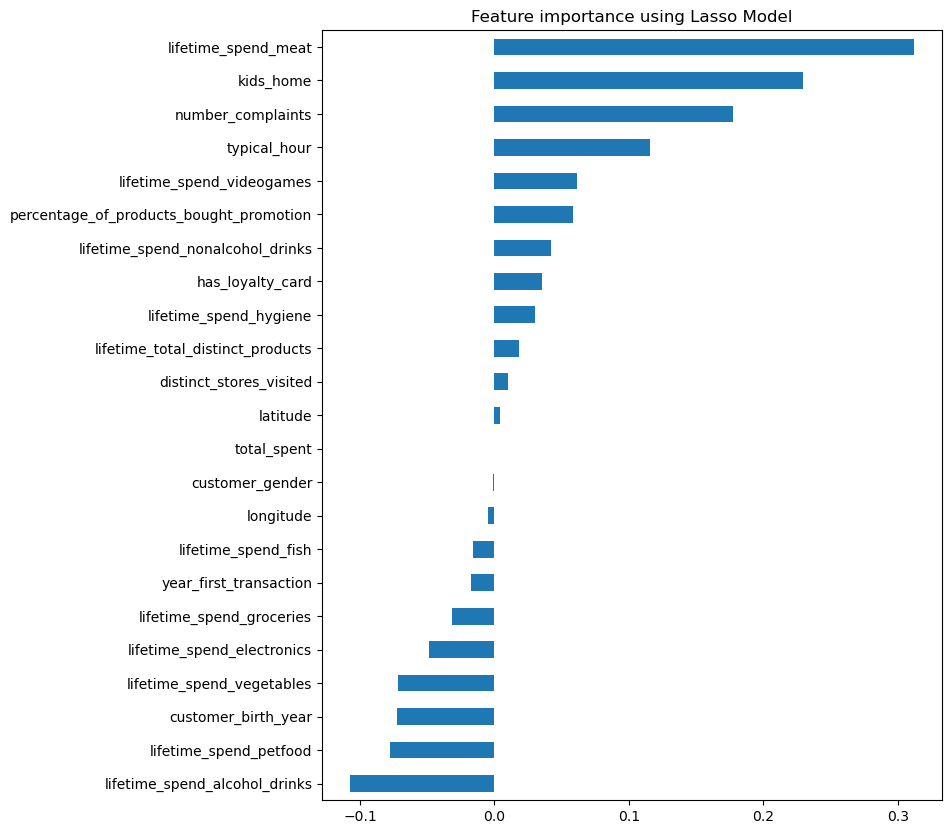

For target variable: number_complaints
Lasso picked 2 variables and eliminated the other 21 variables
Eliminated variables: Index(['customer_gender', 'kids_home', 'distinct_stores_visited',
       'lifetime_spend_groceries', 'lifetime_spend_electronics',
       'typical_hour', 'lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish',
       'lifetime_spend_videogames', 'lifetime_spend_petfood',
       'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'has_loyalty_card', 'latitude', 'longitude', 'customer_birth_year',
       'total_spent'],
      dtype='object')



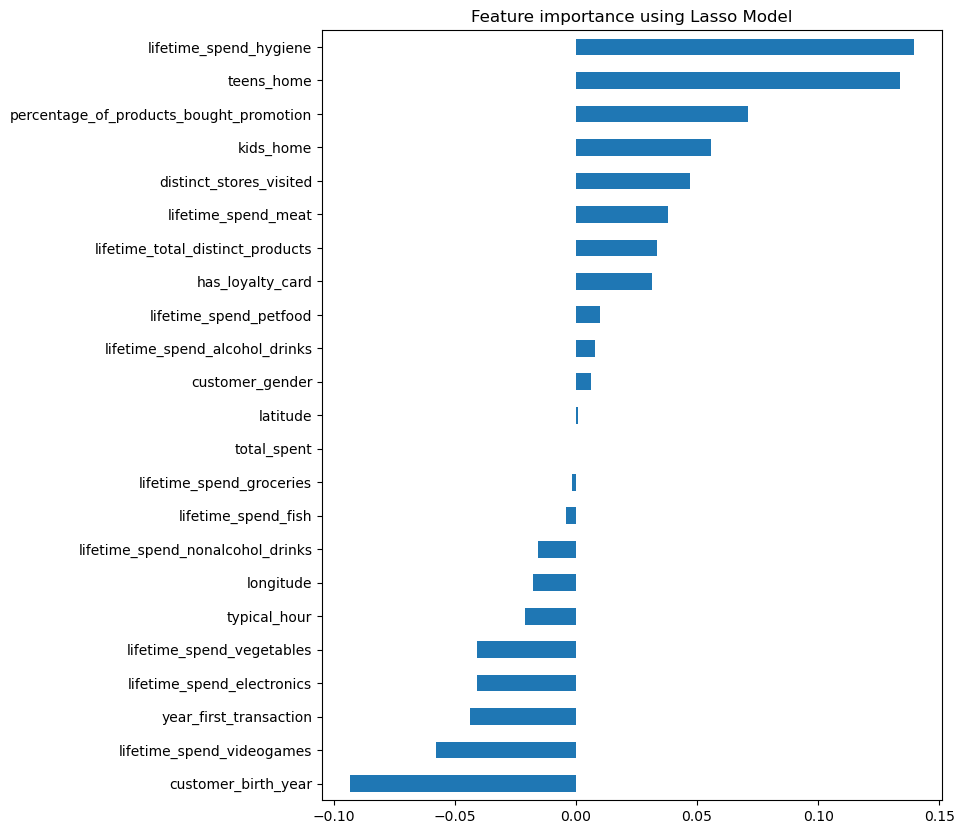

For target variable: distinct_stores_visited
Lasso picked 9 variables and eliminated the other 14 variables
Eliminated variables: Index(['customer_gender', 'teens_home', 'lifetime_spend_electronics',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene',
       'lifetime_total_distinct_products', 'year_first_transaction',
       'latitude', 'longitude', 'customer_birth_year', 'total_spent'],
      dtype='object')



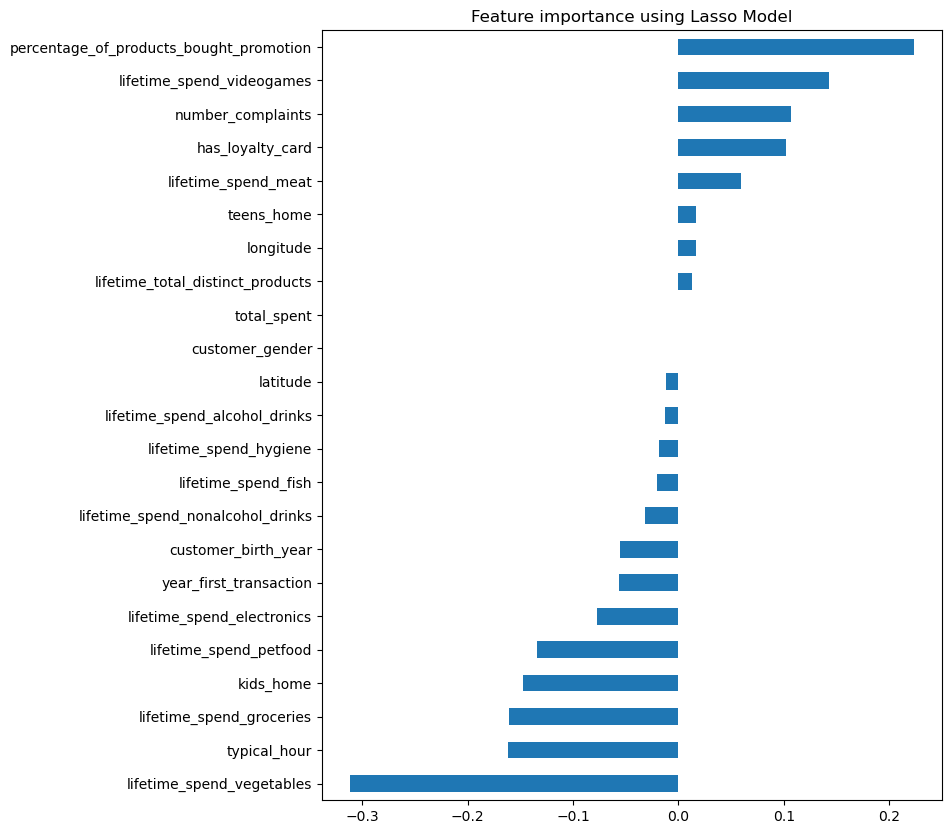

For target variable: typical_hour
Lasso picked 2 variables and eliminated the other 21 variables
Eliminated variables: Index(['customer_gender', 'teens_home', 'number_complaints',
       'distinct_stores_visited', 'lifetime_spend_groceries',
       'lifetime_spend_electronics', 'lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish',
       'lifetime_spend_videogames', 'lifetime_spend_petfood',
       'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'has_loyalty_card', 'latitude', 'longitude', 'customer_birth_year',
       'total_spent'],
      dtype='object')



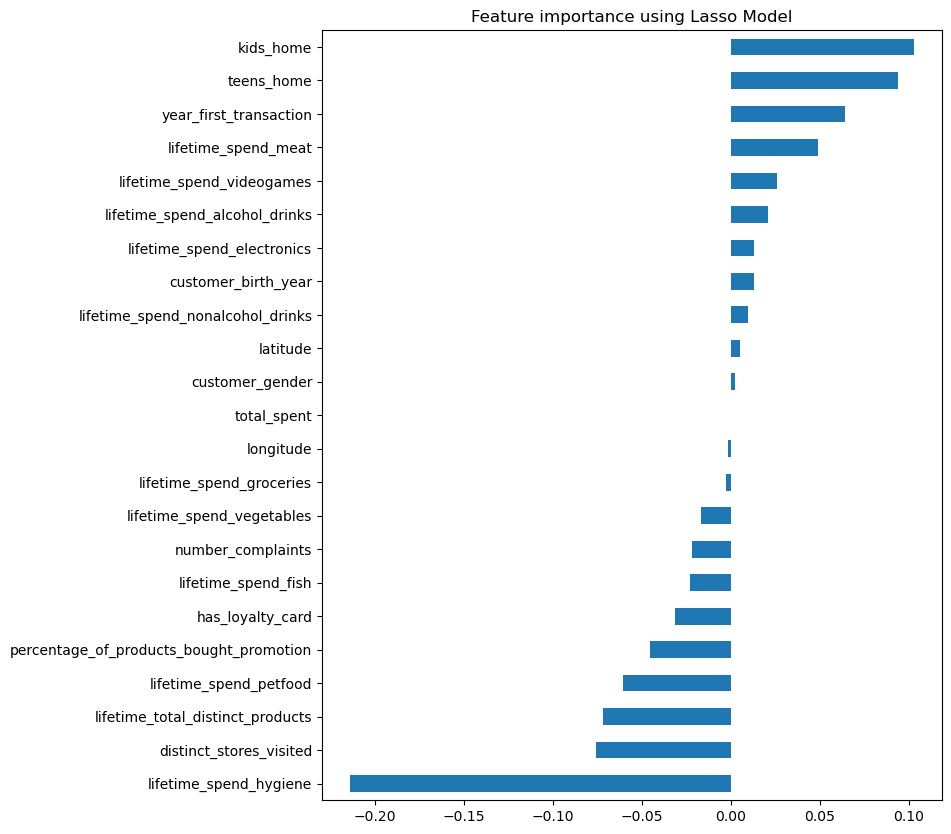

For target variable: lifetime_spend_vegetables
Lasso picked 12 variables and eliminated the other 11 variables
Eliminated variables: Index(['customer_gender', 'kids_home', 'teens_home', 'number_complaints',
       'typical_hour', 'lifetime_total_distinct_products',
       'year_first_transaction', 'has_loyalty_card', 'latitude', 'longitude',
       'customer_birth_year'],
      dtype='object')



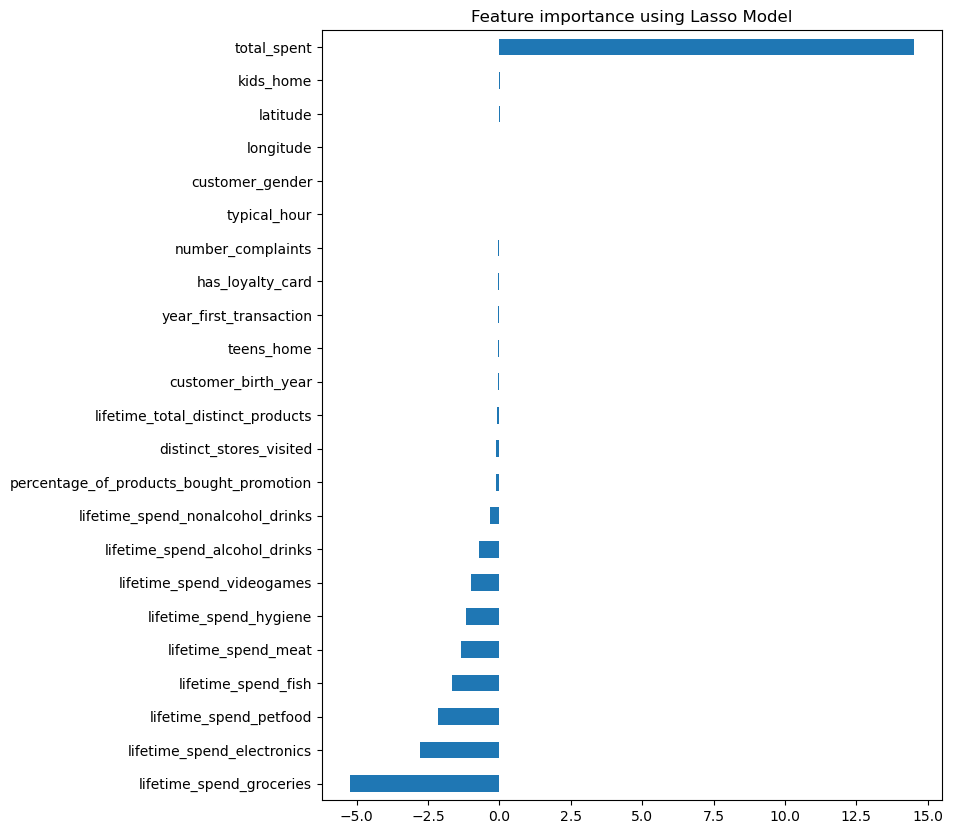

For target variable: lifetime_spend_fish
Lasso picked 10 variables and eliminated the other 13 variables
Eliminated variables: Index(['customer_gender', 'kids_home', 'teens_home', 'number_complaints',
       'distinct_stores_visited', 'typical_hour',
       'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'has_loyalty_card', 'latitude', 'longitude', 'customer_birth_year'],
      dtype='object')



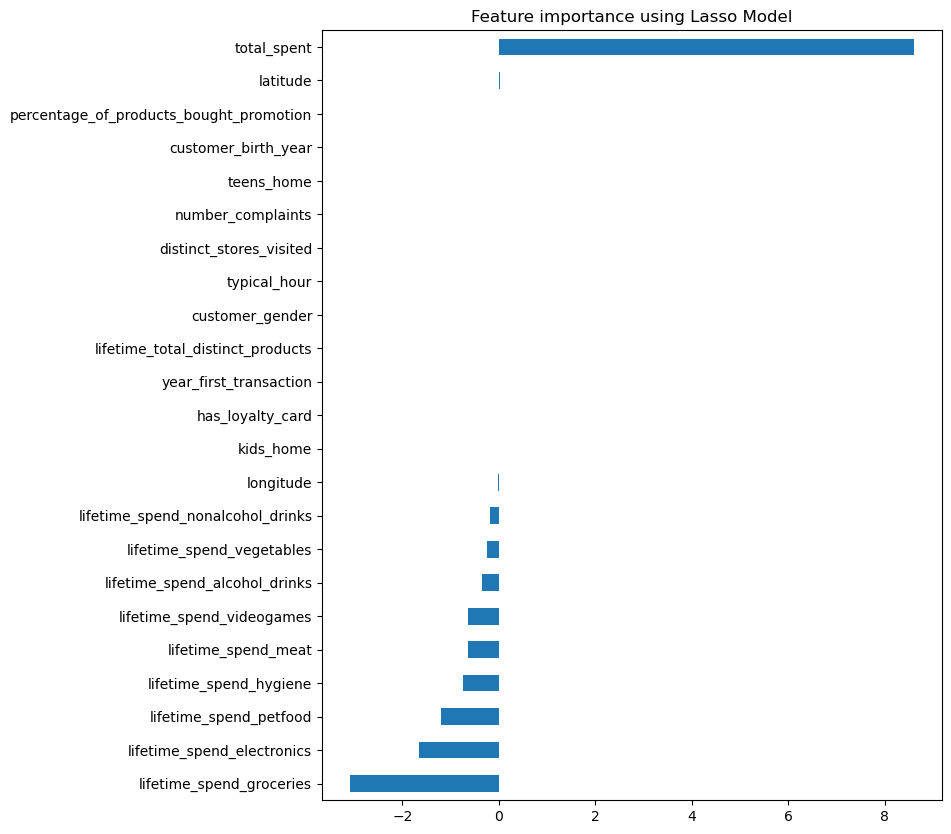

In [13]:
lasso_model = LassoCV(cv=5)
for target_column in targets.columns:
    perform_lasso_feature_selection(target_column, customer_info_rb_no_missing, lasso_model)

Create a dictionary with the target as keys and the collums to remove as values, we took in consideration the lasso and correlation to choose which variables to eliminate

In [15]:
eliminated_variables_dict={'kids_home':['customer_gender', 'lifetime_spend_groceries','lifetime_spend_electronics', 'lifetime_spend_fish','lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction', 'has_loyalty_card', 'latitude', 'longitude', 'customer_birth_year','total_spent'],

                           'teens_home':['customer_gender', 'distinct_stores_visited','lifetime_spend_groceries', 'lifetime_spend_electronics',
       'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks','lifetime_spend_fish', 'lifetime_spend_hygiene','lifetime_spend_videogames', 'lifetime_spend_petfood',
       'lifetime_total_distinct_products','percentage_of_products_bought_promotion', 'year_first_transaction','has_loyalty_card', 'latitude', 'longitude','total_spent', 'customer_birth_year'],

                          'number_complaints':['customer_gender', 'kids_home', 'distinct_stores_visited','lifetime_spend_groceries', 'lifetime_spend_electronics',
       'typical_hour', 'lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks','lifetime_spend_meat', 'lifetime_spend_fish',
       'lifetime_spend_videogames', 'lifetime_spend_petfood','lifetime_total_distinct_products','percentage_of_products_bought_promotion', 'total_spent','year_first_transaction',
       'has_loyalty_card', 'latitude', 'longitude'],

                           'distinct_stores_visited':['customer_gender', 'teens_home', 'lifetime_spend_electronics', 'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks',
       'lifetime_spend_meat', 'lifetime_spend_fish', 'lifetime_spend_hygiene','lifetime_total_distinct_products', 'year_first_transaction','latitude', 'total_spent','longitude', 'customer_birth_year'],
       'lifetime_spend_vegetables':['customer_gender'], 'lifetime_spend_fish':['customer_gender'],

                           'typical_hour': ['customer_gender', 'number_complaints','distinct_stores_visited', 'lifetime_spend_groceries','lifetime_spend_electronics', 'lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks','lifetime_spend_meat', 'lifetime_spend_fish','lifetime_spend_videogames', 'total_spent','lifetime_spend_petfood',
       'lifetime_total_distinct_products','percentage_of_products_bought_promotion', 'year_first_transaction','has_loyalty_card', 'latitude', 'longitude', 'customer_birth_year'],

                           'lifetime_spend_vegetables':['customer_gender', 'kids_home', 'teens_home', 'number_complaints', 'lifetime_spend_groceries', 'lifetime_spend_electronics',
       'typical_hour', 'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_fish', 'year_first_transaction', 'has_loyalty_card','latitude', 'longitude'],

                           'lifetime_spend_fish':['customer_gender', 'kids_home', 'teens_home', 'number_complaints','distinct_stores_visited', 'lifetime_spend_electronics',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks','lifetime_total_distinct_products','percentage_of_products_bought_promotion','year_first_transaction','customer_birth_year']}

For testing KNN, and random forest we needed to create 3 fucntions:

Splits -Split the dataset into training and validation sets while removing the eliminated variables and the target variable

Mean_absolute_percentage_error- Calculate the mean absolute percentage error (MAPE) between true and predicted values.

scoring_function- Creates a custom scorer, which benefits lower values

In [16]:
scoring_function = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

KNN

It was tested with diferent number of neigbours, altought the score didn't change much

In [17]:

for y in targets:   #for each target will do
  # Creates training and validation sets while removing the eliminated variables and the target variable 
  X_train, X_val, y_train, y_val = splits(y, customer_info_rb_no_missing, eliminated_variables_dict )  
  #run the model
  model = KNeighborsRegressor(n_neighbors=15, weights='distance', p=1)
  cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring_function , n_jobs=-1)
  model.fit(X_train, y_train)
  test_score = mean_absolute_percentage_error(y_val, model.predict(X_val))
  print(y, test_score )

kids_home 49.524490367943784
teens_home 45.228545759105444
number_complaints 64.97097778774383
distinct_stores_visited 49.41286132643163
typical_hour 112.02957930981907
lifetime_spend_vegetables 204.3201096119643
lifetime_spend_fish 174.54076261763097


Random forest

More hyperparameters and trials were tested, but due to the time required to run, we decided to limit the demonstration to 3 trials and focus on the most important hyperparameters. The scores between a full run (with more hyperparameters and trials) and the demonstration run did not differ substantially, varying only around 5% to 20%. Not enough to consider random forest an good option to input

In [18]:
best_models = {}
validation_scores = {}

# Iterate over each target variable
for y in targets:
    #Create training and validation sets while removing the eliminated variables and the target variable 
    X_train, X_val, y_train, y_val = splits(y, customer_info_rb_no_missing, eliminated_variables_dict )  
    #Does optuna otimization, with goal of reducing the mape score
    best_model, test_score = optimize_hyperparameters(X_train, X_val, y_train, y_val, scoring_function, y)

    # Store the best model and validation score for each target variable
    best_models[y] = best_model
    validation_scores[y] = test_score

[I 2024-06-09 15:34:34,994] A new study created in memory with name: no-name-7af0c872-917d-4d0e-b514-de12f1856d32
[I 2024-06-09 15:34:59,277] Trial 0 finished with value: 43.506008237659465 and parameters: {'n_estimators': 79, 'max_depth': 9}. Best is trial 0 with value: 43.506008237659465.
[I 2024-06-09 15:35:15,452] Trial 1 finished with value: 44.05779777803659 and parameters: {'n_estimators': 51, 'max_depth': 9}. Best is trial 0 with value: 43.506008237659465.
[I 2024-06-09 15:35:18,141] Trial 2 finished with value: 56.073662065371884 and parameters: {'n_estimators': 19, 'max_depth': 4}. Best is trial 0 with value: 43.506008237659465.
[I 2024-06-09 15:35:18,164] A new study created in memory with name: no-name-1d51d313-4ff7-46b6-abeb-2554813f3255


Best hyperparameters for variable kids_home: {'n_estimators': 79, 'max_depth': 9}
Validation Mean Squared Error: 43.506008237659465


[I 2024-06-09 15:35:20,515] Trial 0 finished with value: 62.99701494536549 and parameters: {'n_estimators': 90, 'max_depth': 2}. Best is trial 0 with value: 62.99701494536549.
[I 2024-06-09 15:35:21,522] Trial 1 finished with value: 57.17600967407799 and parameters: {'n_estimators': 25, 'max_depth': 3}. Best is trial 1 with value: 57.17600967407799.
[I 2024-06-09 15:35:31,939] Trial 2 finished with value: 36.37291915440659 and parameters: {'n_estimators': 89, 'max_depth': 10}. Best is trial 2 with value: 36.37291915440659.
[I 2024-06-09 15:35:31,954] A new study created in memory with name: no-name-963e2992-0b2b-4092-b2ec-f957a26afecb


Best hyperparameters for variable teens_home: {'n_estimators': 89, 'max_depth': 10}
Validation Mean Squared Error: 36.37291915440659


[I 2024-06-09 15:35:36,971] Trial 0 finished with value: 61.81509609603432 and parameters: {'n_estimators': 95, 'max_depth': 7}. Best is trial 0 with value: 61.81509609603432.
[I 2024-06-09 15:35:38,605] Trial 1 finished with value: 67.8345402357421 and parameters: {'n_estimators': 92, 'max_depth': 2}. Best is trial 0 with value: 61.81509609603432.
[I 2024-06-09 15:35:40,638] Trial 2 finished with value: 65.52604999663339 and parameters: {'n_estimators': 76, 'max_depth': 3}. Best is trial 0 with value: 61.81509609603432.
[I 2024-06-09 15:35:40,644] A new study created in memory with name: no-name-9d628c32-90ef-4851-9fe0-d811e0693561


Best hyperparameters for variable number_complaints: {'n_estimators': 95, 'max_depth': 7}
Validation Mean Squared Error: 61.81509609603432


[I 2024-06-09 15:35:43,042] Trial 0 finished with value: 53.658356746948954 and parameters: {'n_estimators': 34, 'max_depth': 2}. Best is trial 0 with value: 53.658356746948954.
[I 2024-06-09 15:35:56,950] Trial 1 finished with value: 43.59985100057827 and parameters: {'n_estimators': 74, 'max_depth': 6}. Best is trial 1 with value: 43.59985100057827.
[I 2024-06-09 15:35:59,900] Trial 2 finished with value: 53.373666587333965 and parameters: {'n_estimators': 38, 'max_depth': 2}. Best is trial 1 with value: 43.59985100057827.
[I 2024-06-09 15:35:59,911] A new study created in memory with name: no-name-8e0994c0-e72c-4e3f-a191-dac98e6099e9


Best hyperparameters for variable distinct_stores_visited: {'n_estimators': 74, 'max_depth': 6}
Validation Mean Squared Error: 43.59985100057827


[I 2024-06-09 15:36:02,307] Trial 0 finished with value: 91.9874130725046 and parameters: {'n_estimators': 49, 'max_depth': 7}. Best is trial 0 with value: 91.9874130725046.
[I 2024-06-09 15:36:05,223] Trial 1 finished with value: 93.31975146105368 and parameters: {'n_estimators': 87, 'max_depth': 5}. Best is trial 0 with value: 91.9874130725046.
[I 2024-06-09 15:36:06,402] Trial 2 finished with value: 97.48482370952391 and parameters: {'n_estimators': 82, 'max_depth': 2}. Best is trial 0 with value: 91.9874130725046.
[I 2024-06-09 15:36:06,418] A new study created in memory with name: no-name-fcd6040c-4873-457b-8128-6c0514d33d13


Best hyperparameters for variable typical_hour: {'n_estimators': 49, 'max_depth': 7}
Validation Mean Squared Error: 91.9874130725046


[I 2024-06-09 15:36:22,132] Trial 0 finished with value: 159.27766968596205 and parameters: {'n_estimators': 66, 'max_depth': 5}. Best is trial 0 with value: 159.27766968596205.
[I 2024-06-09 15:36:23,807] Trial 1 finished with value: 133.49549667560368 and parameters: {'n_estimators': 10, 'max_depth': 3}. Best is trial 1 with value: 133.49549667560368.
[I 2024-06-09 15:36:27,944] Trial 2 finished with value: 153.44134488885777 and parameters: {'n_estimators': 22, 'max_depth': 4}. Best is trial 1 with value: 133.49549667560368.
[I 2024-06-09 15:36:27,953] A new study created in memory with name: no-name-359db501-42d4-4567-bddb-24cd5177b937


Best hyperparameters for variable lifetime_spend_vegetables: {'n_estimators': 10, 'max_depth': 3}
Validation Mean Squared Error: 133.49549667560368


[I 2024-06-09 15:36:32,761] Trial 0 finished with value: 158.94649641241506 and parameters: {'n_estimators': 10, 'max_depth': 8}. Best is trial 0 with value: 158.94649641241506.
[I 2024-06-09 15:37:00,265] Trial 1 finished with value: 166.4515711521365 and parameters: {'n_estimators': 85, 'max_depth': 6}. Best is trial 0 with value: 158.94649641241506.
[I 2024-06-09 15:37:13,035] Trial 2 finished with value: 167.79455627743866 and parameters: {'n_estimators': 39, 'max_depth': 6}. Best is trial 0 with value: 158.94649641241506.


Best hyperparameters for variable lifetime_spend_fish: {'n_estimators': 10, 'max_depth': 8}
Validation Mean Squared Error: 158.94649641241506


Imputing missing values


Due to the low scores from KNN and RF, we decided to impute using the median to maintain the dataset's structure.

In [35]:
# Create an imputer object with strategy as 'median'
imputer = SimpleImputer(strategy='median')

# Impute missing values with median
customer_info_rb = pd.DataFrame(imputer.fit_transform(customer_info_rb), columns=customer_info_rb.columns, index=customer_info_rb.index)
customer_info_num = pd.DataFrame(imputer.fit_transform(customer_info_num), columns=customer_info_num.columns, index=customer_info_num.index)


# 5. Choosing the best scaller for clustering <a class="anchor" id="chapter5"></a>

Altough we tested some variations of scallers with variables, here are only the 4 most promising exemples of clustering distribution of all we tested

In [36]:
scaler = MinMaxScaler()
minmax_scaled = pd.DataFrame(scaler.fit_transform(customer_info_num), columns=customer_info_num.columns, index=customer_info_num.index)
#Min-Max Scaler economic with behaviour
minmax_scaled1 =   minmax_scaled.drop(['has_loyalty_card','customer_gender','longitude','latitude'],axis=1).copy()
#Min-Max Scaler economic
minmax_scaled2= minmax_scaled[['lifetime_spend_groceries','lifetime_spend_electronics','lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks','lifetime_spend_alcohol_drinks','lifetime_spend_meat',
                                 'lifetime_spend_fish','lifetime_spend_hygiene','lifetime_spend_videogames','lifetime_spend_petfood','total_spent']].copy()
#'Robust Scaler economic with behaviour'
robust_scaller1=customer_info_rb.drop(['has_loyalty_card','customer_gender','longitude','latitude'],axis=1).copy()
#Robust Scaler economic
robust_scaller2=customer_info_rb[['lifetime_spend_groceries','lifetime_spend_electronics','lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks','lifetime_spend_alcohol_drinks','lifetime_spend_meat',
                                 'lifetime_spend_fish','lifetime_spend_hygiene','lifetime_spend_videogames','lifetime_spend_petfood','total_spent']].copy()

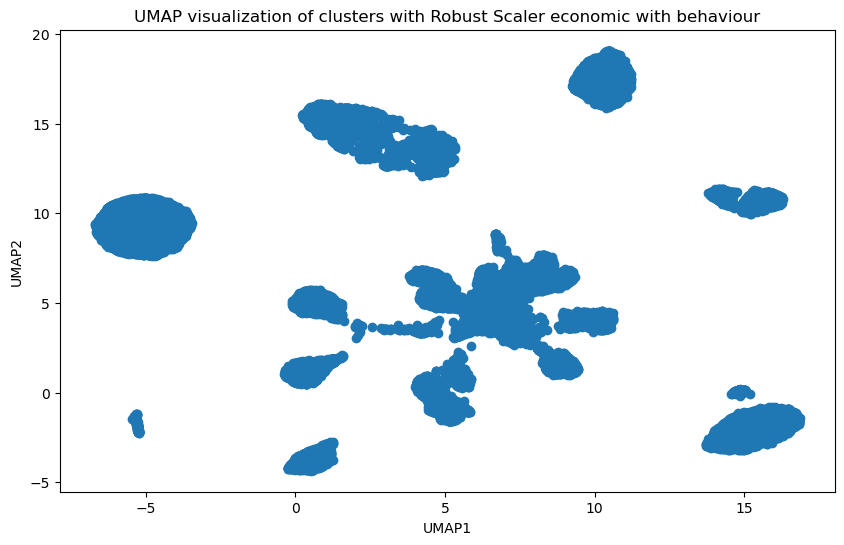

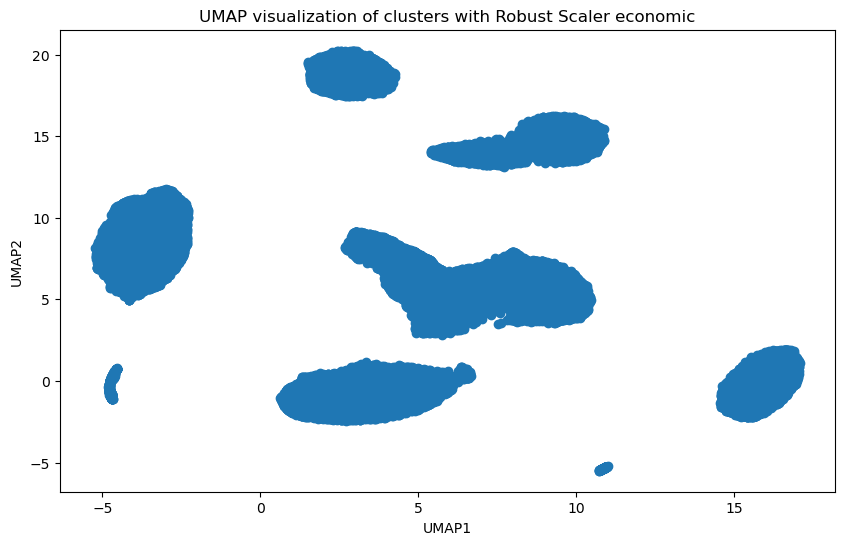

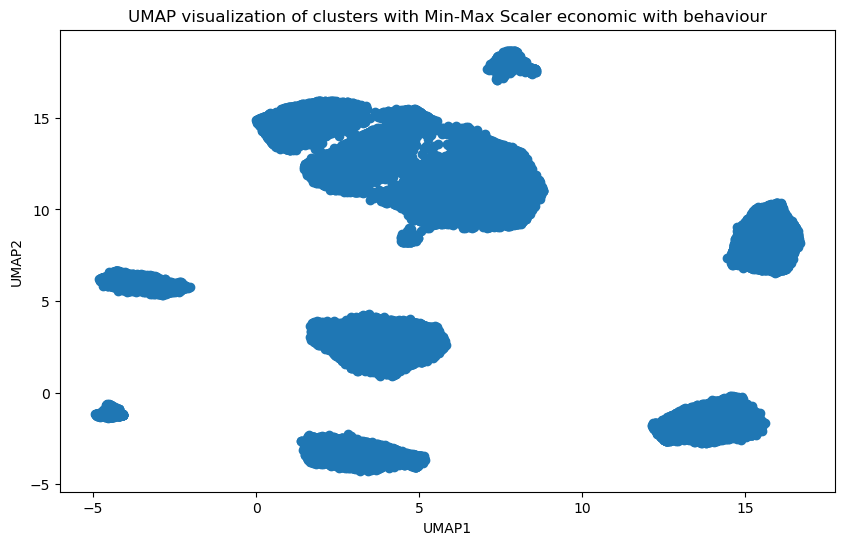

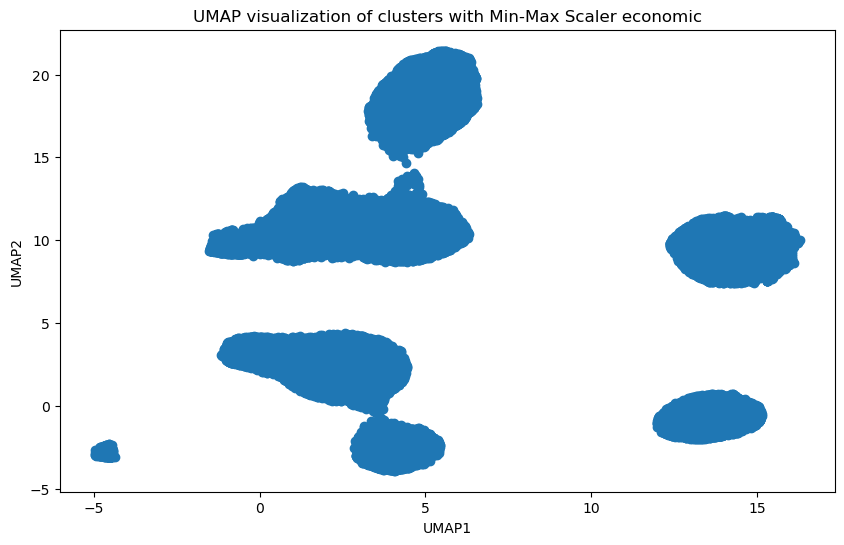

In [12]:
options2 = [
    (robust_scaller1, 'Robust Scaler economic with behaviour'),
    (robust_scaller2, 'Robust Scaler economic'),
    (minmax_scaled1, 'Min-Max Scaler economic with behaviour'),
    (minmax_scaled2, 'Min-Max Scaler economic')]


for option , description in options2:
# Apply UMAP
  umap_results = umap.UMAP(n_components=2, random_state=42).fit_transform(option)

# Create a dataframe with UMAP results
  umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'])

# Plot the UMAP results
  plt.figure(figsize=(10, 6))
  plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'])
  plt.title(f'UMAP visualization of clusters with {description}')
  plt.xlabel('UMAP1')
  plt.ylabel('UMAP2')
  plt.show()

After plotting this map, we came to the following conclusions:

-There are small clusters that need the behavioral variables to distinguish themselves from the big clusters.

-It is important that clusters are clearly separated from each other.

-The number of big clusters always stays the same, which can indicate that we only need business information to identify them.

So, we decided to use the Robust Scaler, as it already has properties that help with outliers. By examining the two UMAPs, we can infer that with business and behavioral variables, there are small clusters that grow separated, and we think they are worth studying. The Robust Scaler, even with only business variables, creates strong and distinct clusters. Therefore, we plan to mix these two approaches.

Next, we will start analyzing clusters using the Robust Scaler with both business and behavioral variables, and we will identify the clusters that can only be obtained with this combination. Later, we will perform clustering using only the business variables to identify the big clusters. The last step is creating segmentations based on the behavioral profiles of the customers, allowing us to distinguish certain traits even among individuals with similar business traits. This will help in a better customer marketing approach.

In [37]:
business_behaviour_rb=robust_scaller1.copy()

# 6. Unidimensional outliers <a class="anchor" id="chapter6"></a>

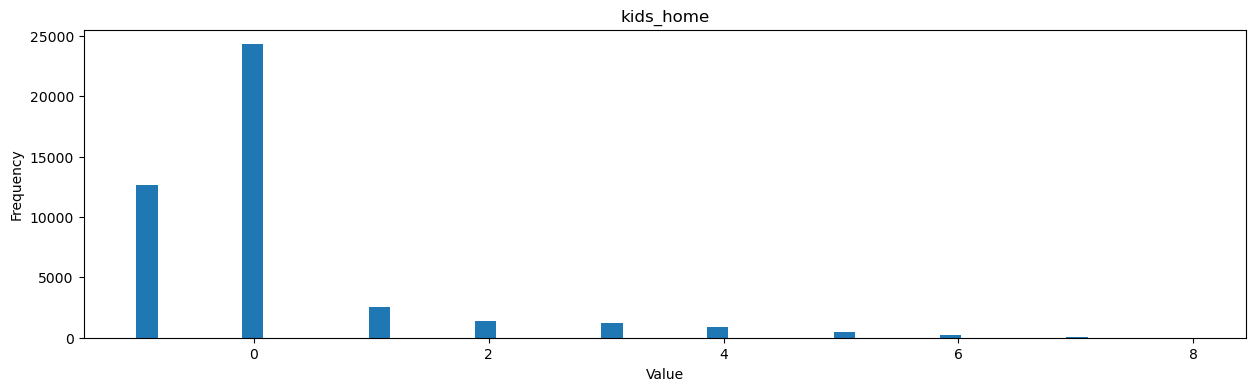

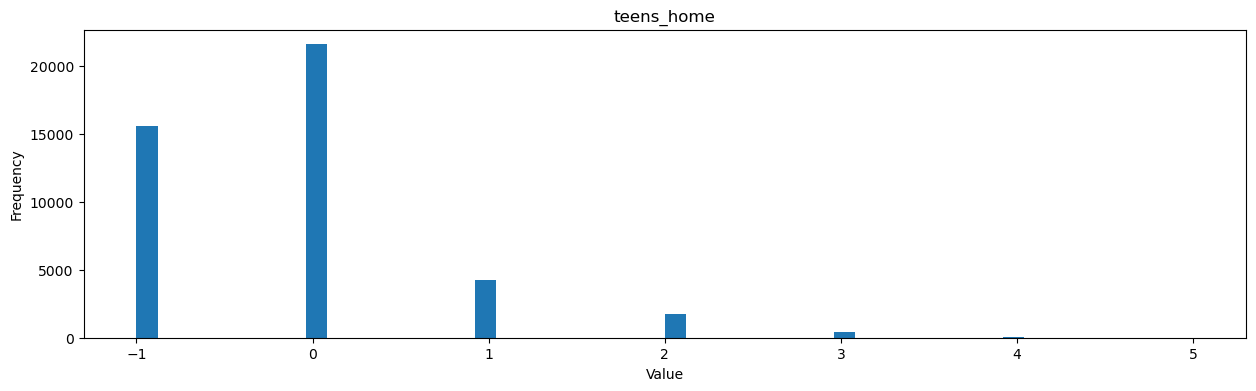

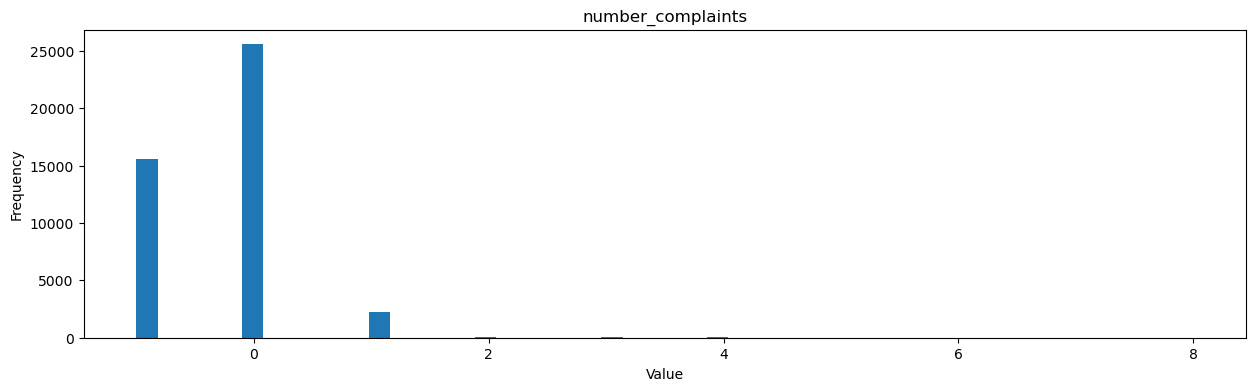

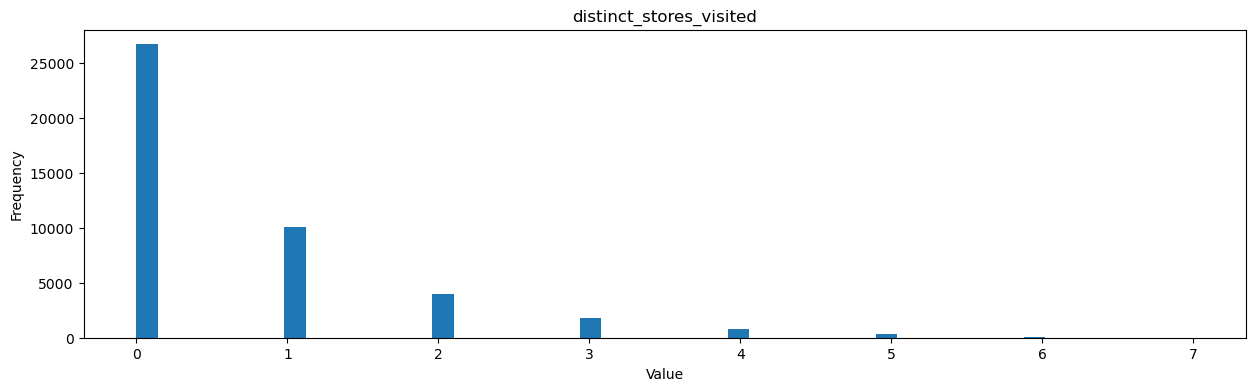

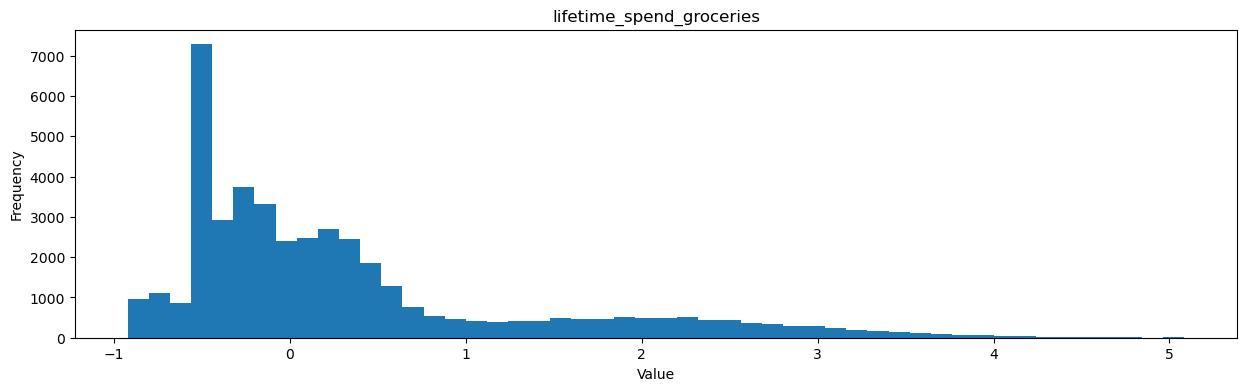

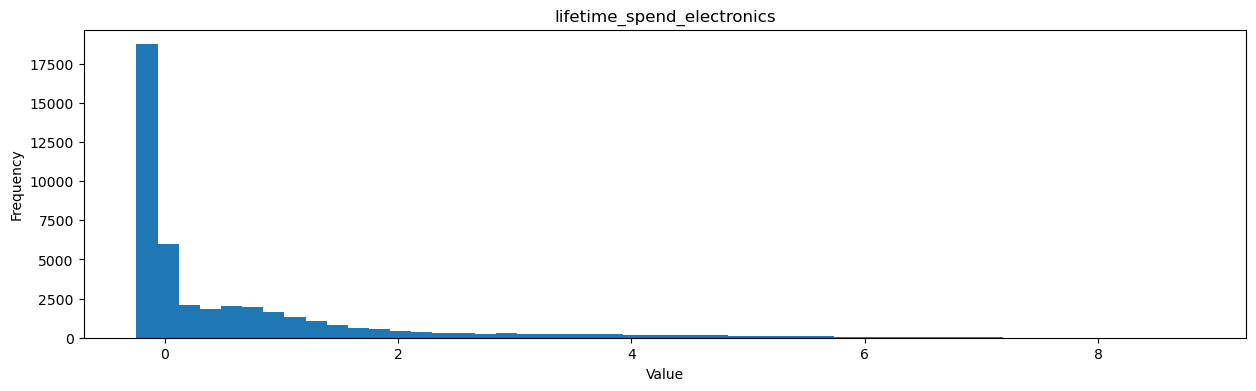

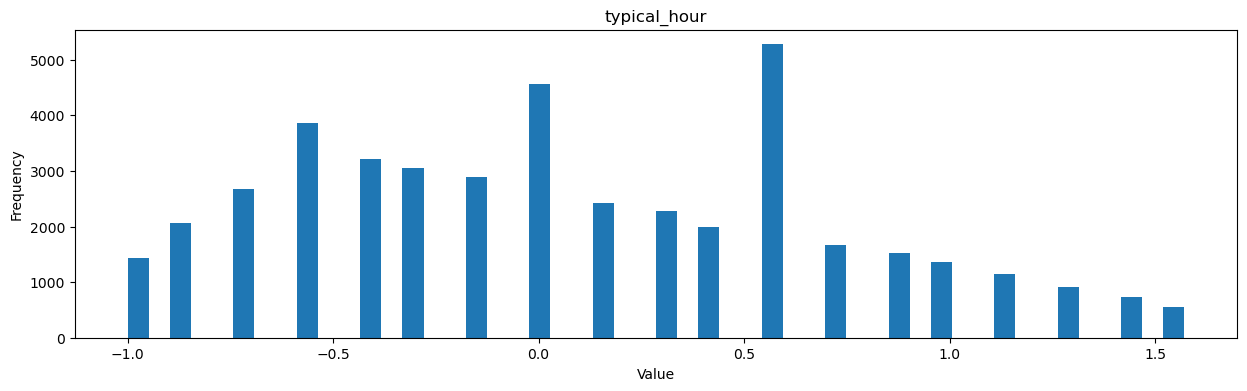

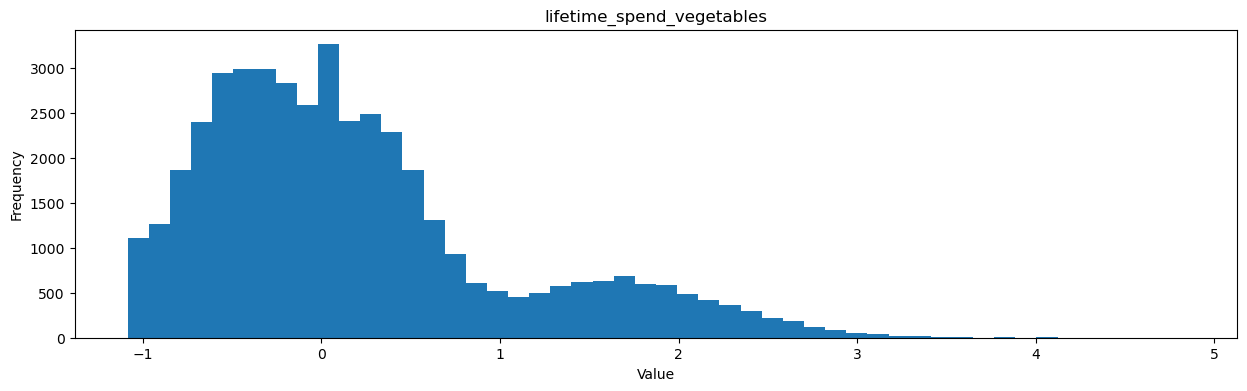

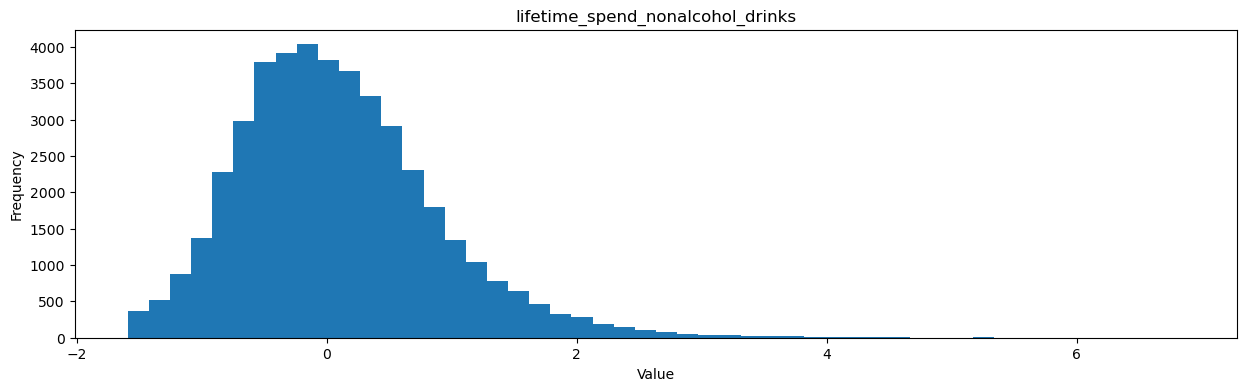

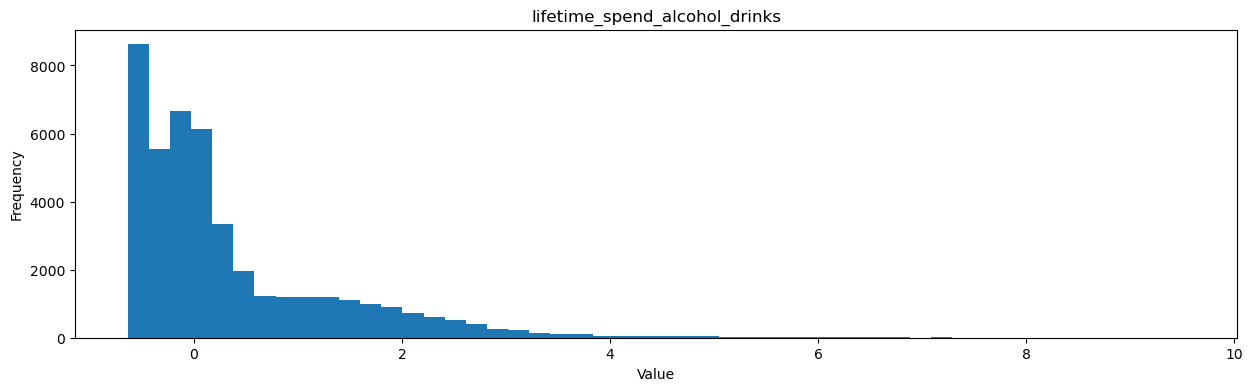

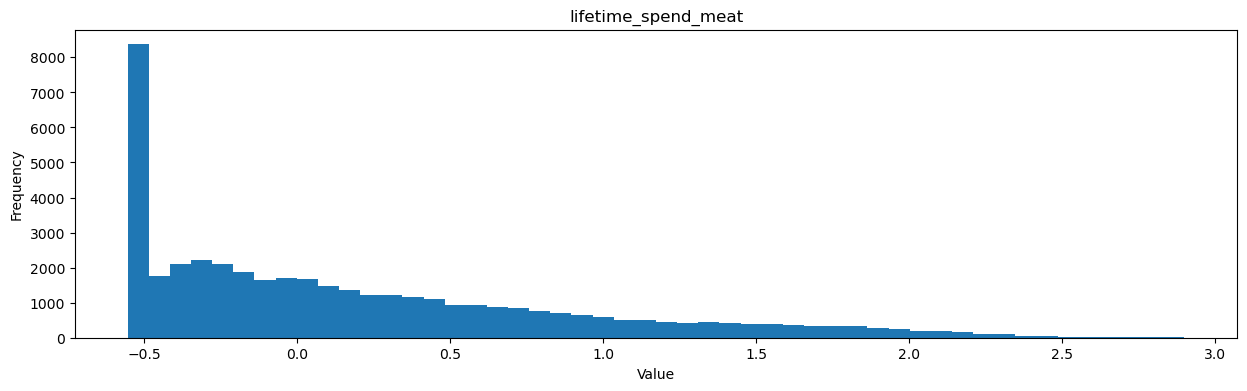

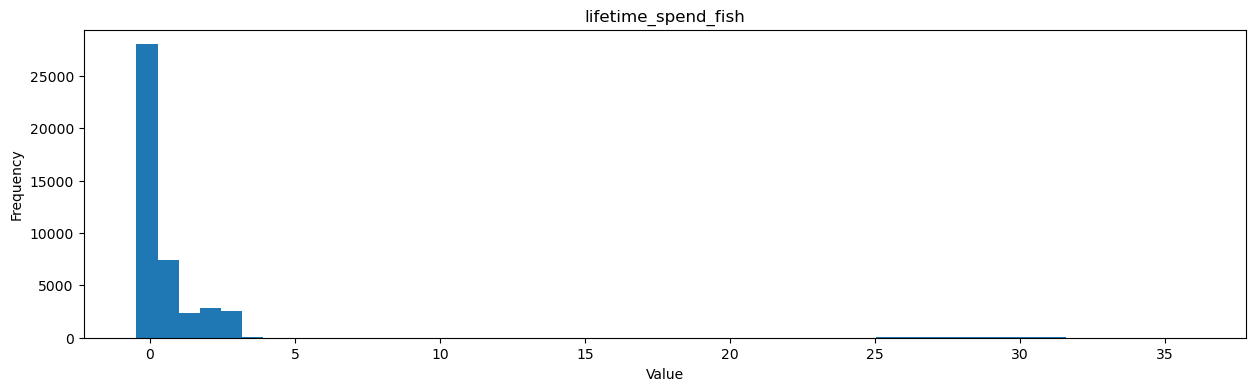

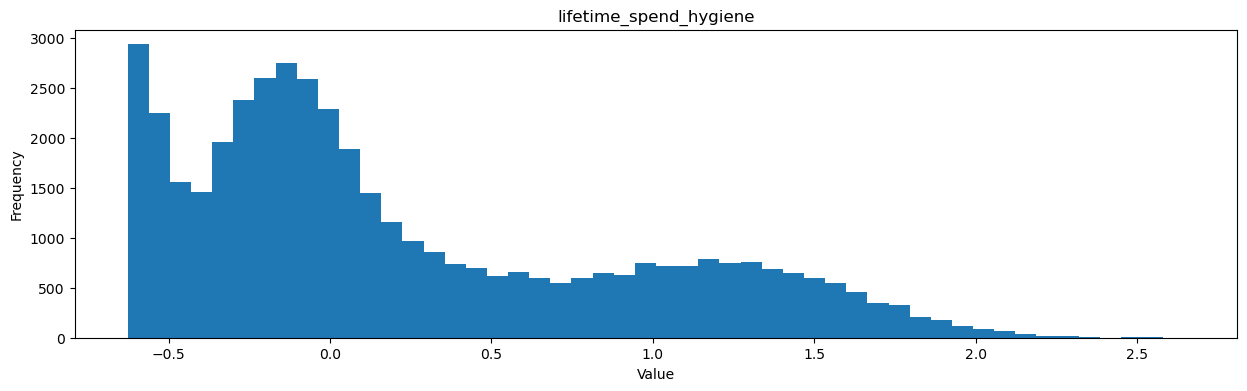

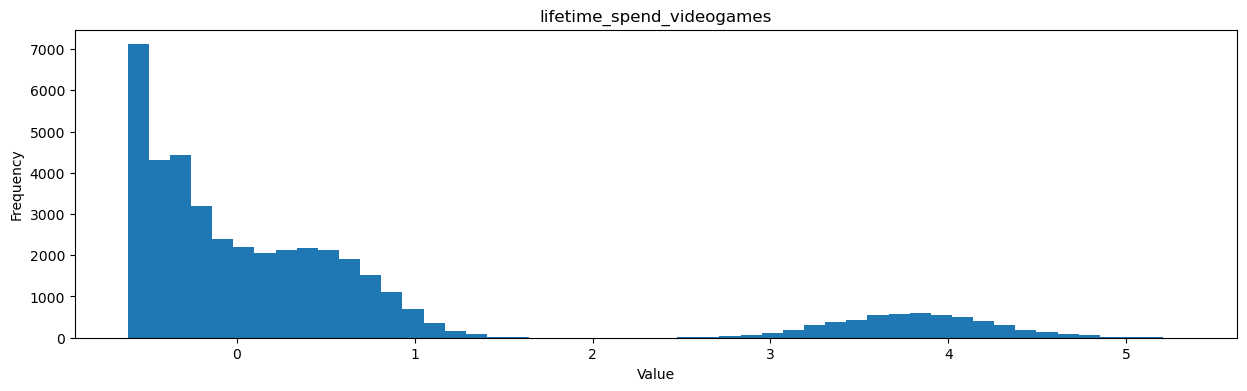

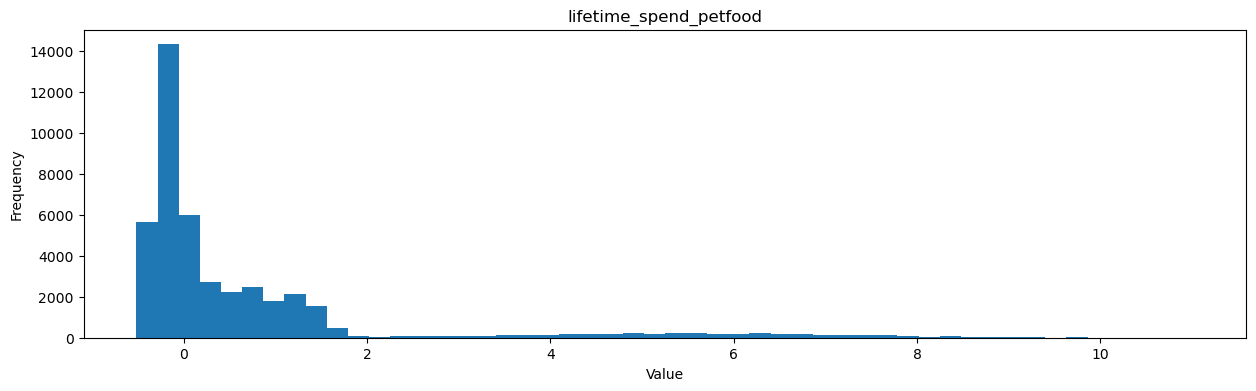

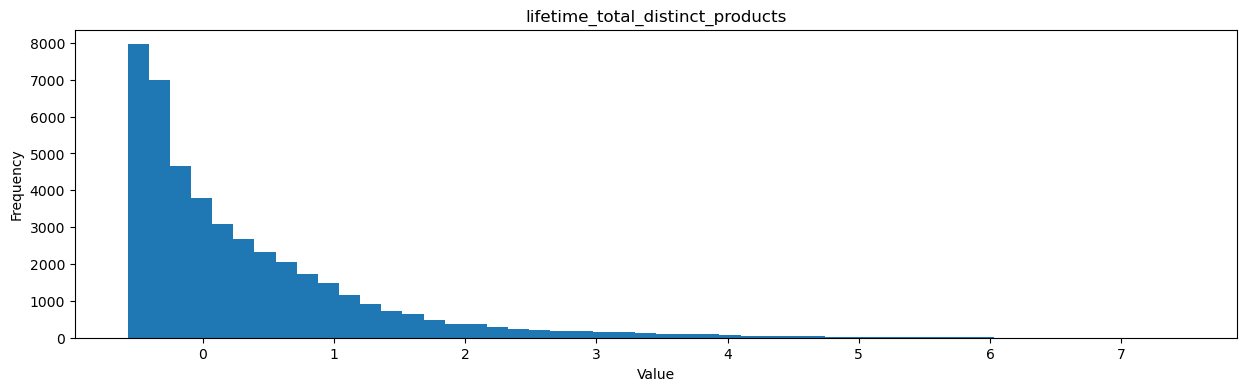

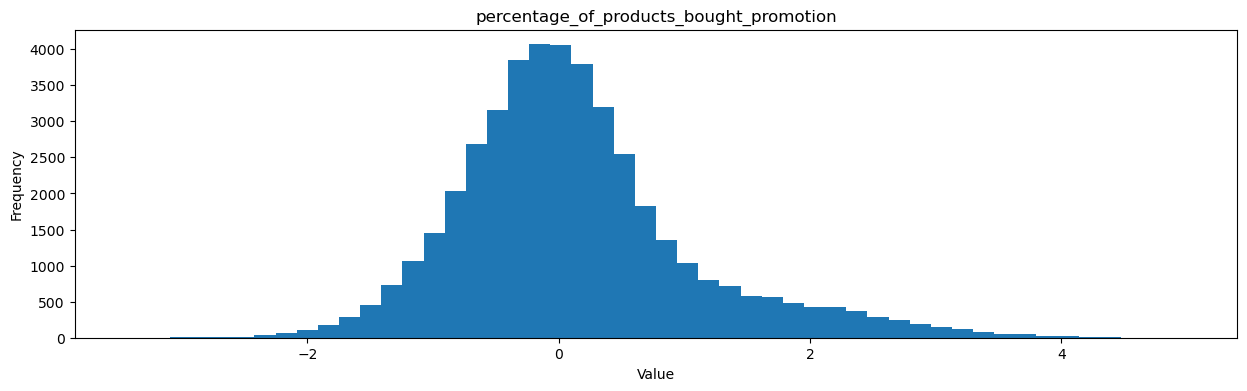

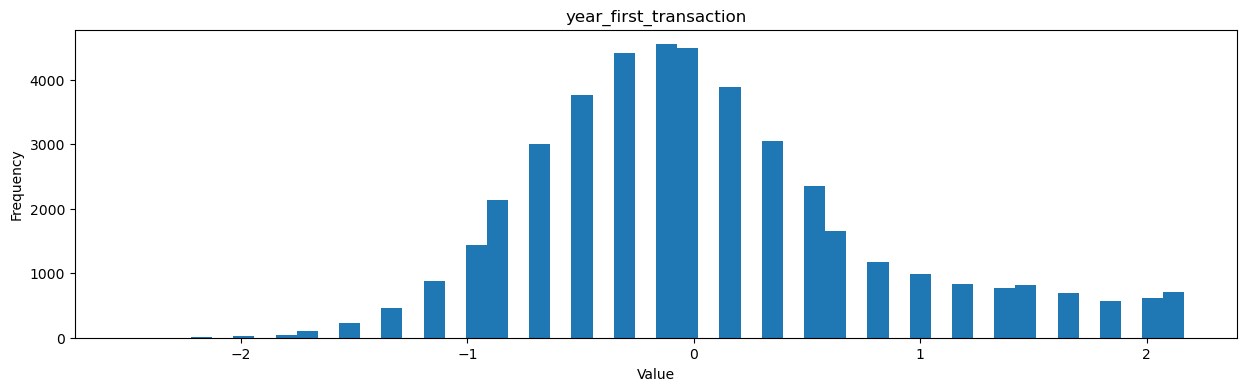

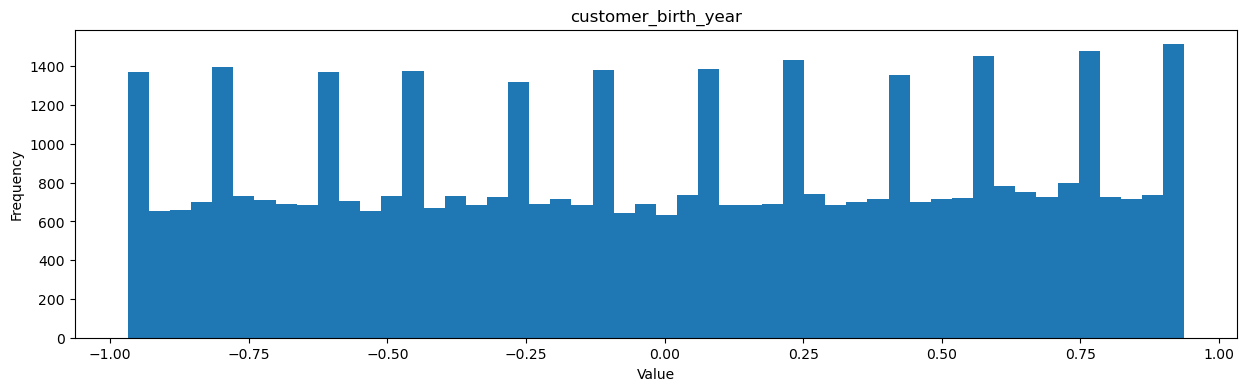

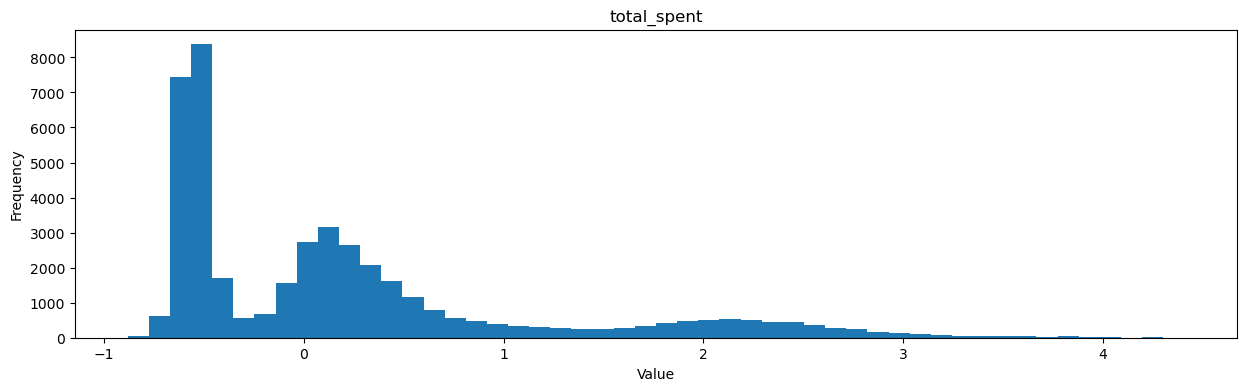

In [41]:
for column in business_behaviour_rb.columns:
    plt.figure(figsize=(15, 4))                   # Adjust the figure size as needed
    plt.hist(business_behaviour_rb[column], bins=50)  # Adjust bins as needed
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

As we can see, lifetime_spend_fish has an obvious cluster outlier, so we decided to use thresholding to create our first cluster

In [38]:
fishies= business_behaviour_rb[business_behaviour_rb['lifetime_spend_fish']>=20]  #Creating a fishies dataset 
business_behaviour_rb = business_behaviour_rb[business_behaviour_rb['lifetime_spend_fish'] < 20]   #removing fishies dataset from business_behaviour_rb
fishies.loc[:, 'cluster_thresholding'] = 'fishies'   #creating a collum with name cluster_thresholding which all the value is fishies 



# 7. Multidimensional outliers <a class="anchor" id="chapter7"></a>

It is essential to remove multidimensional outliers to enhance the efficacy of our clustering techniques.

## 7.1. DBSCAN Visualization <a class="anchor" id="sub_section_7_1"></a>

We used the k-NN distance plot to determine an appropriate value for the epsilon parameter in DBSCAN. The epsilon parameter defines the maximum distance between two samples for one to be considered as in the neighborhood of the other. By examining the plot of distances to the k-th nearest neighbor, you can visually identify a suitable value for epsilon.

To choose the epsilon, we used the  "elbow" point in the plot, where the rate of change in distance sharply decreases.

By observing the plot, we could select an appropriate epsilon value that captures the density of the data points, effectively defining the neighborhood size for DBSCAN clustering. This helps ensure that DBSCAN identifies meaningful clusters based on the local density of points in the dataset and detecting outliers.








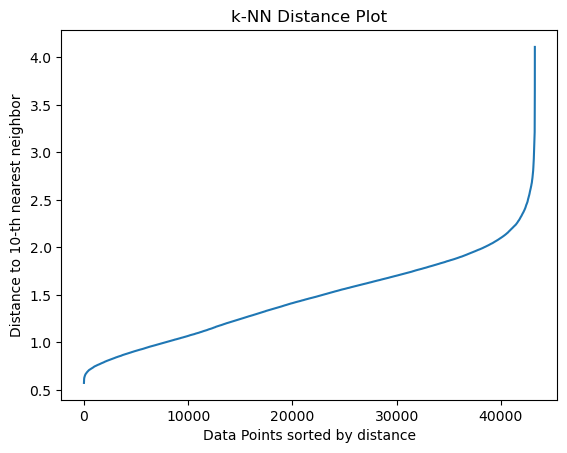

In [43]:
from sklearn.neighbors import NearestNeighbors
k = 10  # Typically set k to min_samples for DBSCAN
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(business_behaviour_rb)
distances, indices = nbrs.kneighbors(business_behaviour_rb)

# Sort the distances to the k-th nearest neighbor
distances = np.sort(distances[:, k-1], axis=0)

# Plot the distances
plt.plot(distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Distance to {}-th nearest neighbor'.format(k))
plt.title('k-NN Distance Plot')
plt.show()

We chose 2.25 to eps

## 7.2. DBSCAN Removel <a class="anchor" id="sub_section_7_2"></a>

In [39]:
dbscan = DBSCAN(eps=2.25, min_samples=10).fit(business_behaviour_rb) #running DBSCAN

# Add the cluster labels to the DataFrame
business_behaviour_rb['cluster'] = dbscan.labels_

# Identify outliers (label == -1 indicates noise)
all_outliers = business_behaviour_rb[business_behaviour_rb['cluster'] == -1]   #Saving outliers in a diferent dataset 

In [40]:
business_behaviour_rb['cluster'].value_counts()

 1    37225
 0     5547
-1      480
Name: cluster, dtype: int64

480 Outliers

In [41]:
#Removing this outliers from the business_behaviour_rb dataset, and kmean column
business_behaviour_rb = business_behaviour_rb[business_behaviour_rb['cluster'] != -1]

business_behaviour_rb=business_behaviour_rb.drop(columns=['cluster'])
all_outliers =all_outliers.drop(columns=['cluster'])

## 7.3. Analysing Outliers <a class="anchor" id="sub_section_5_3"></a>

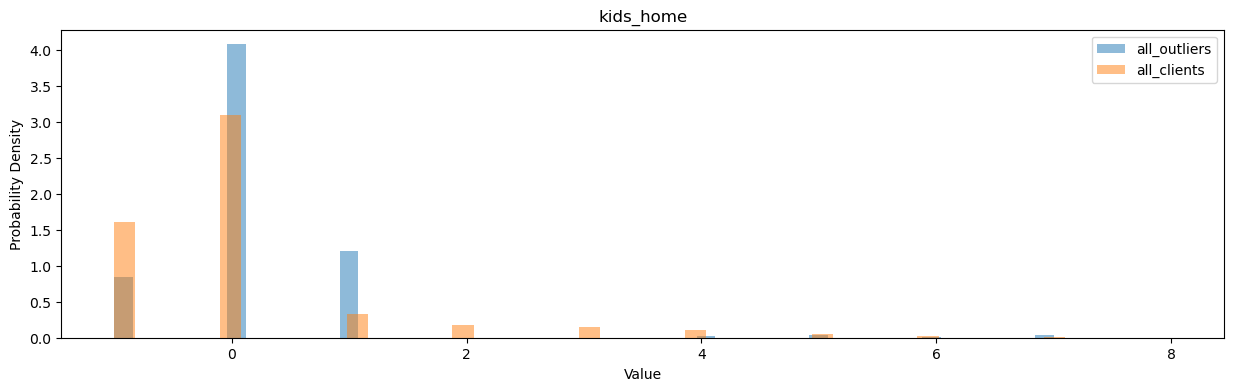

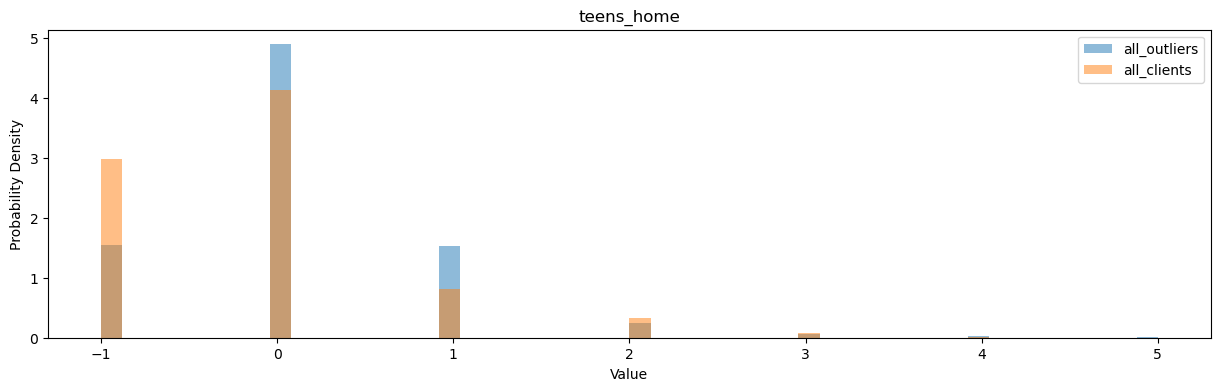

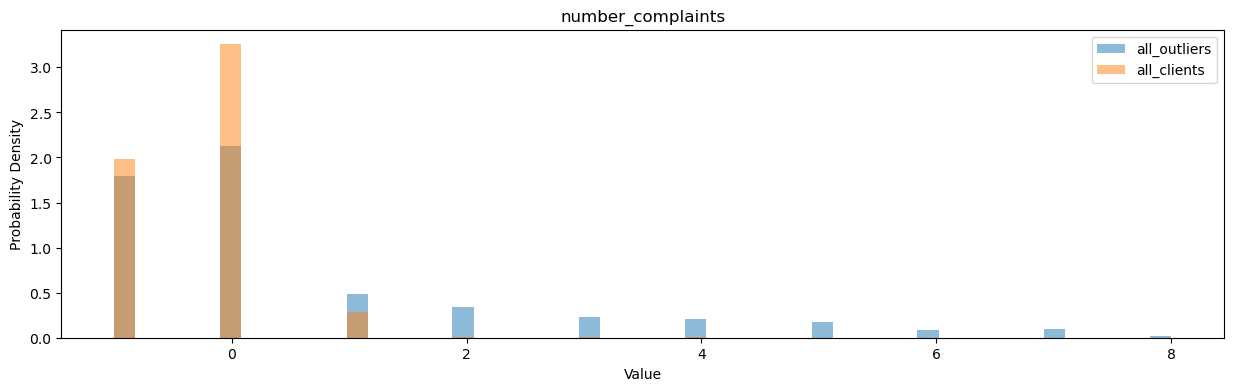

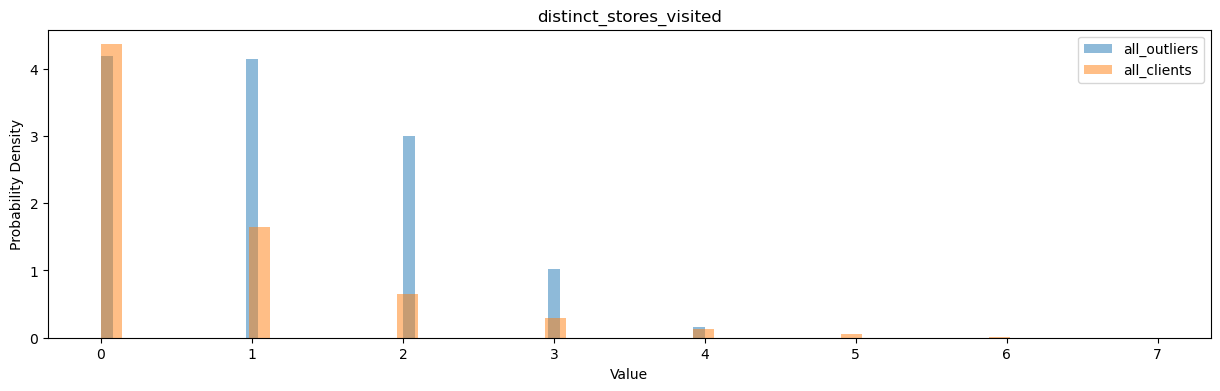

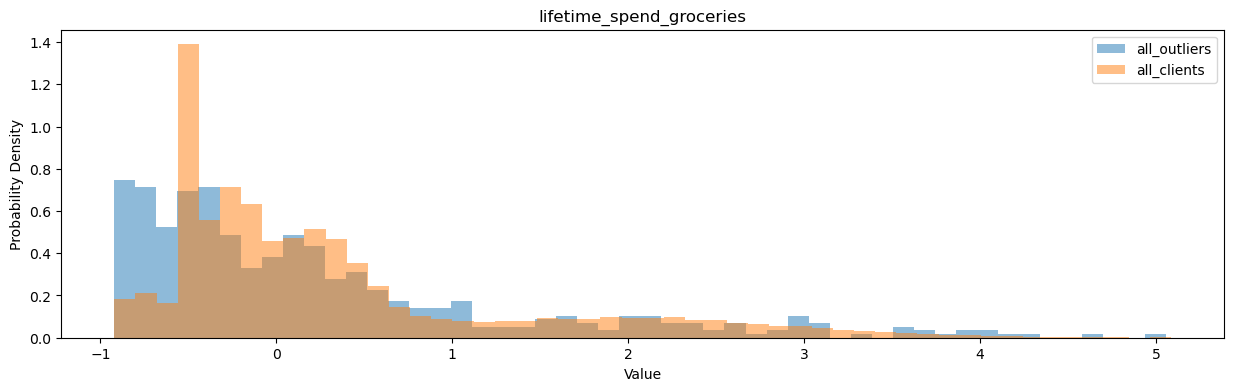

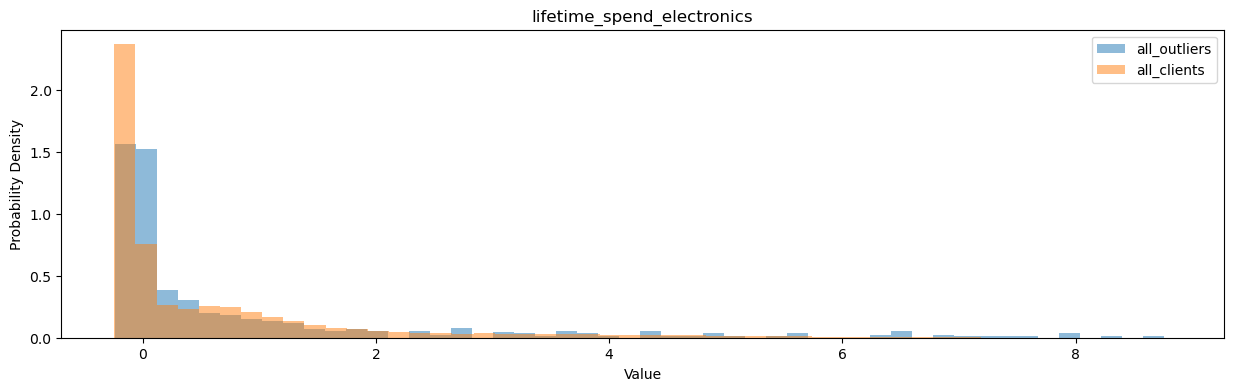

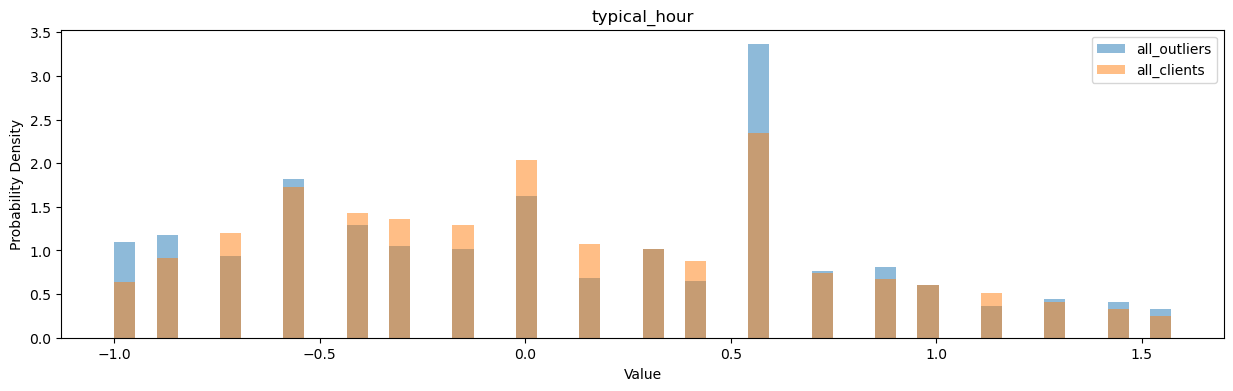

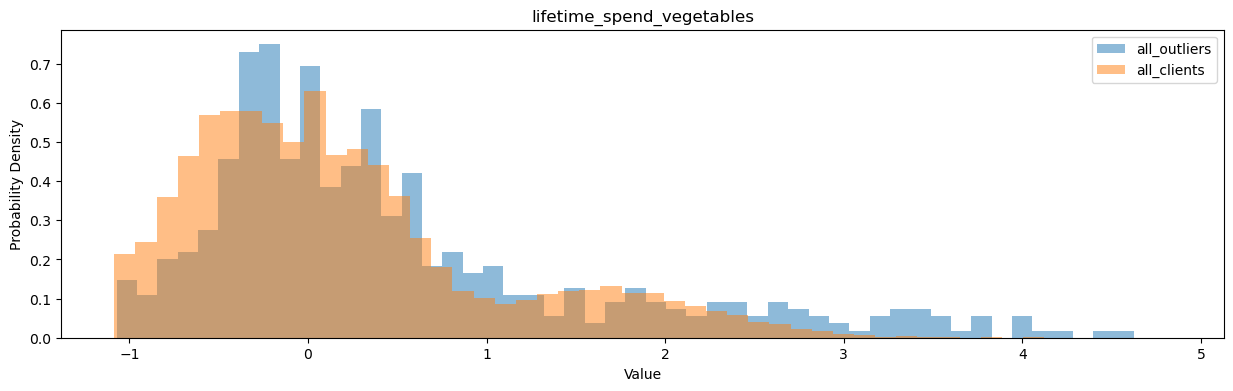

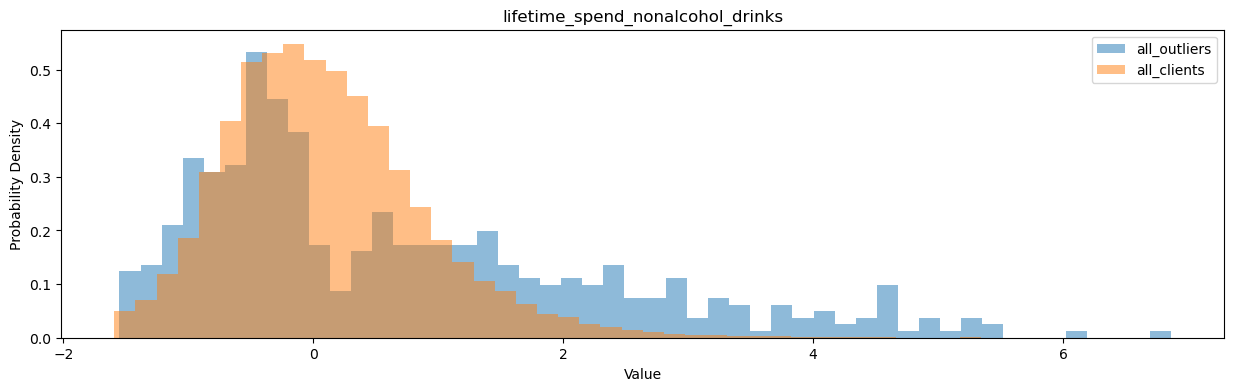

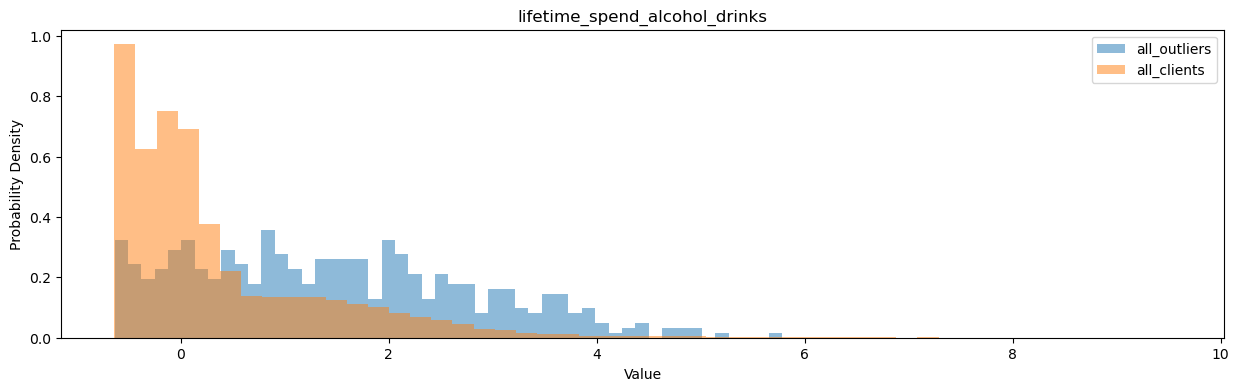

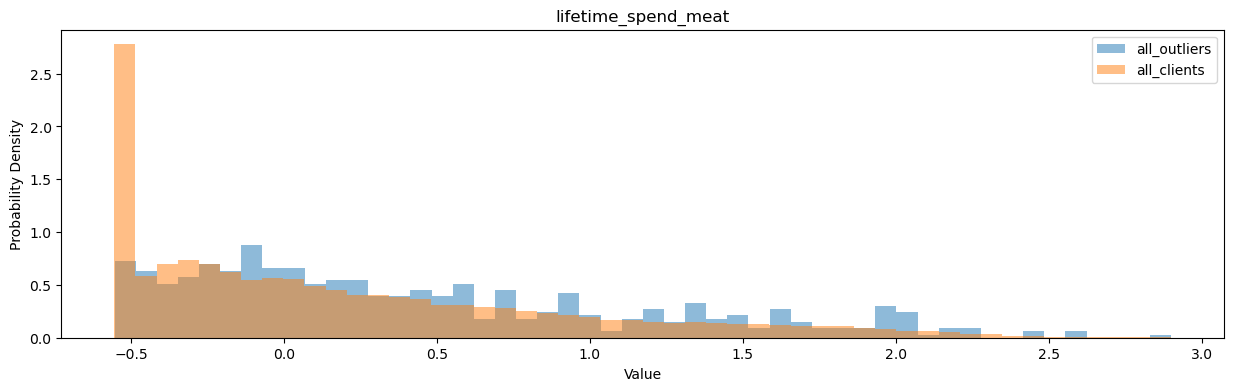

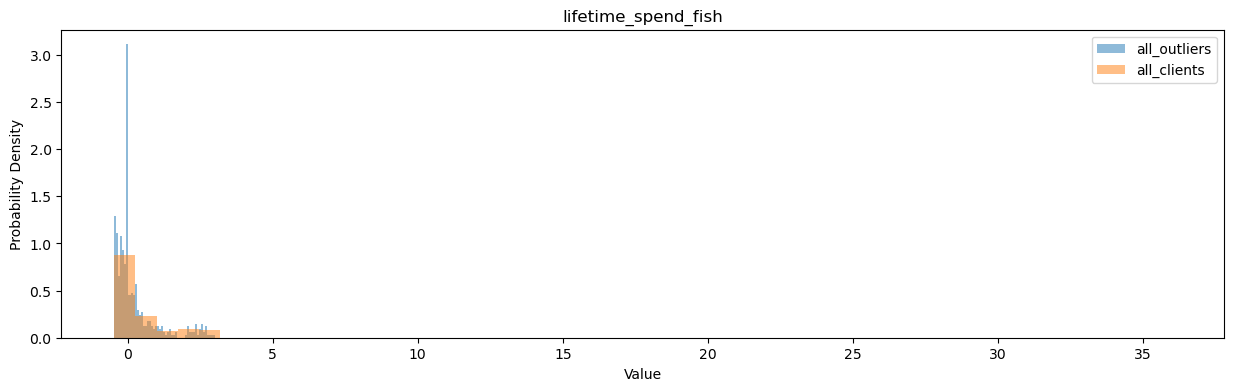

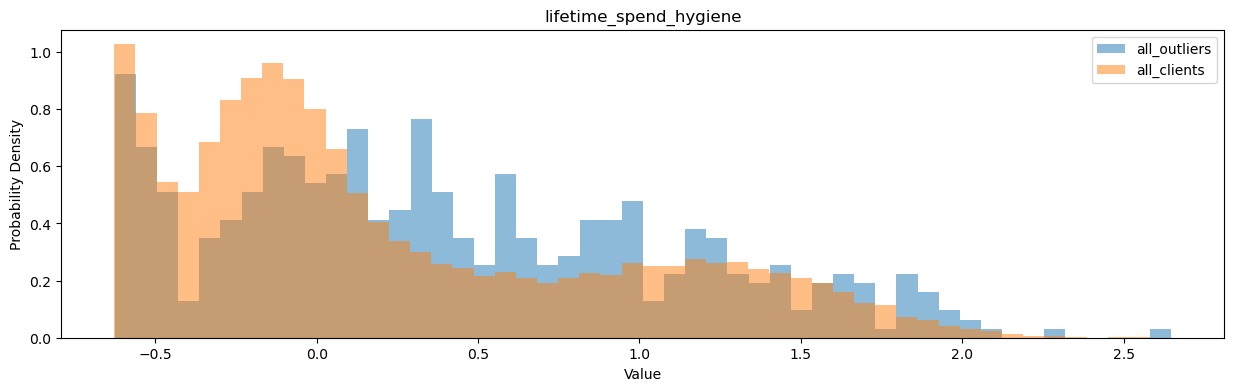

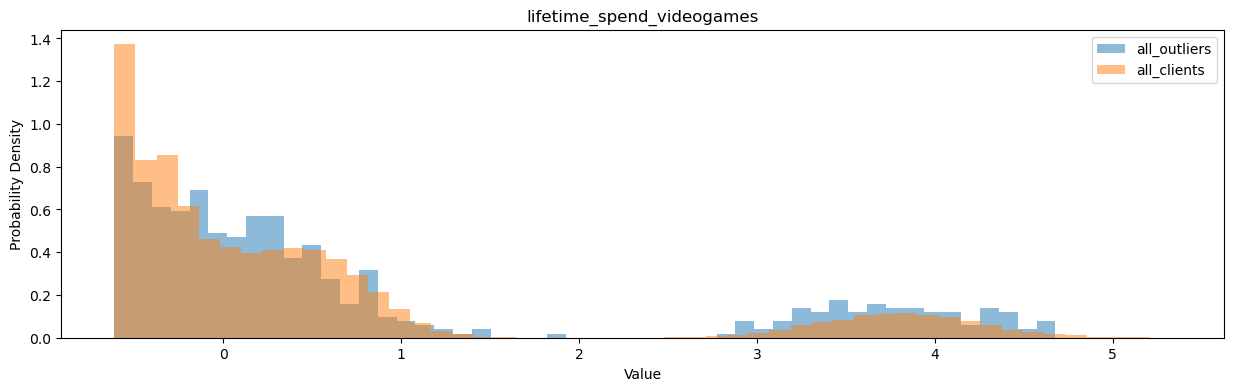

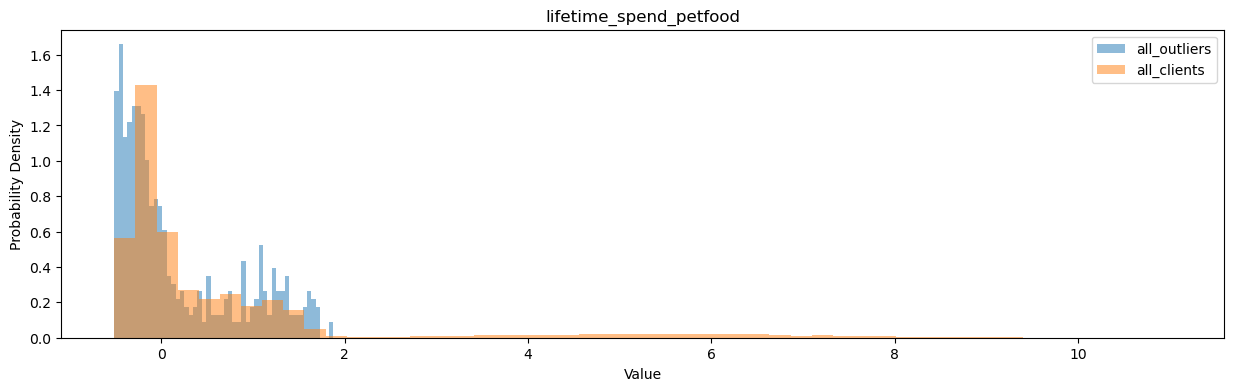

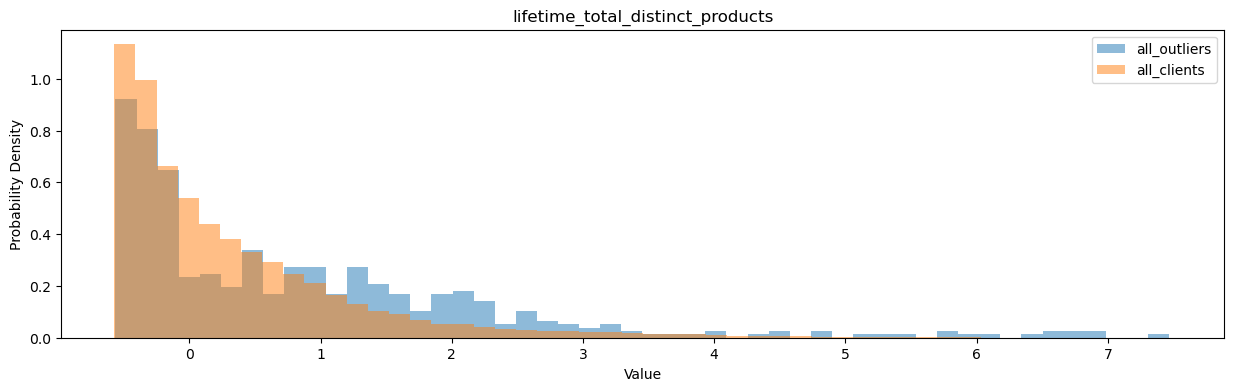

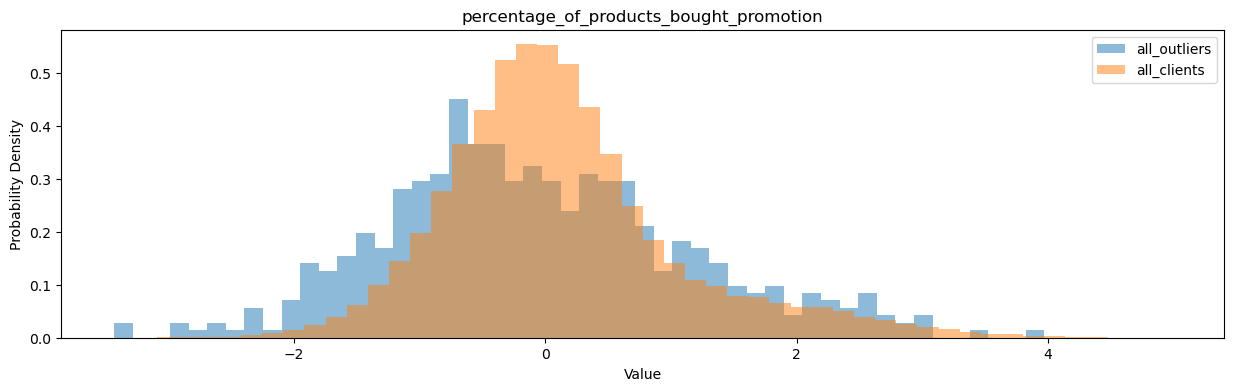

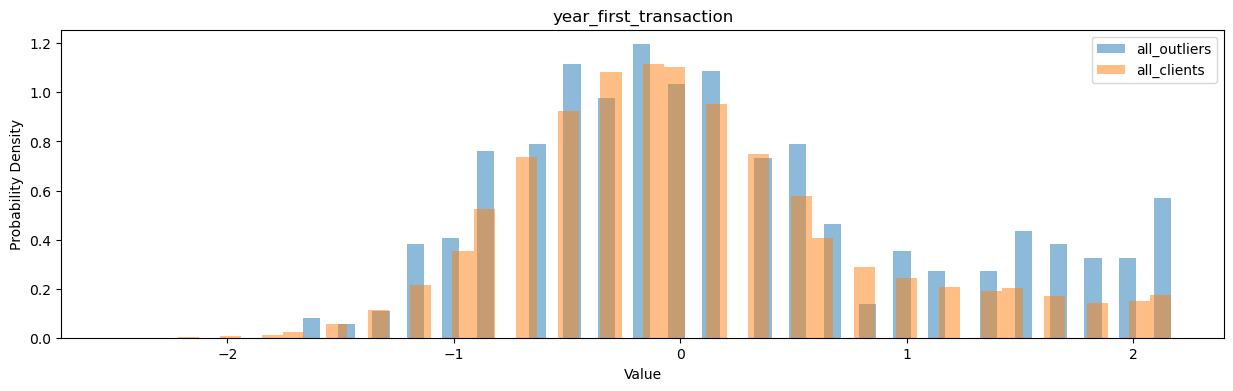

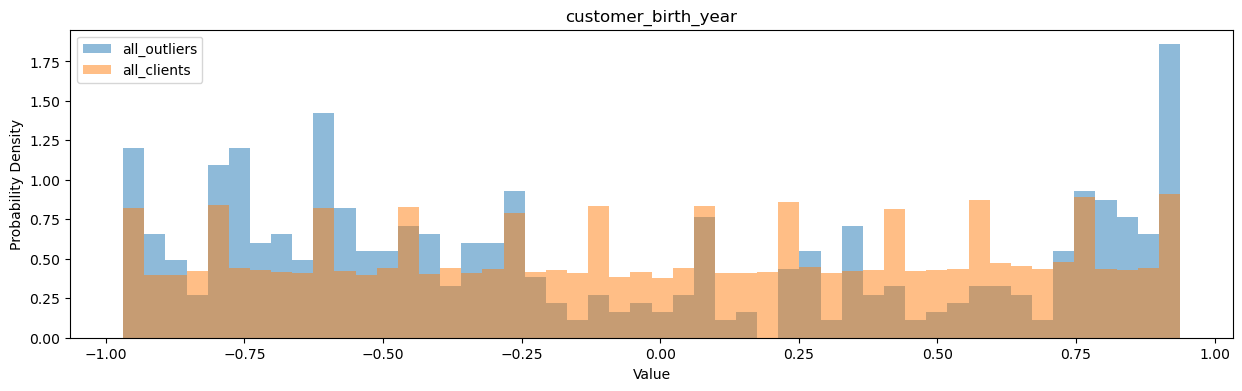

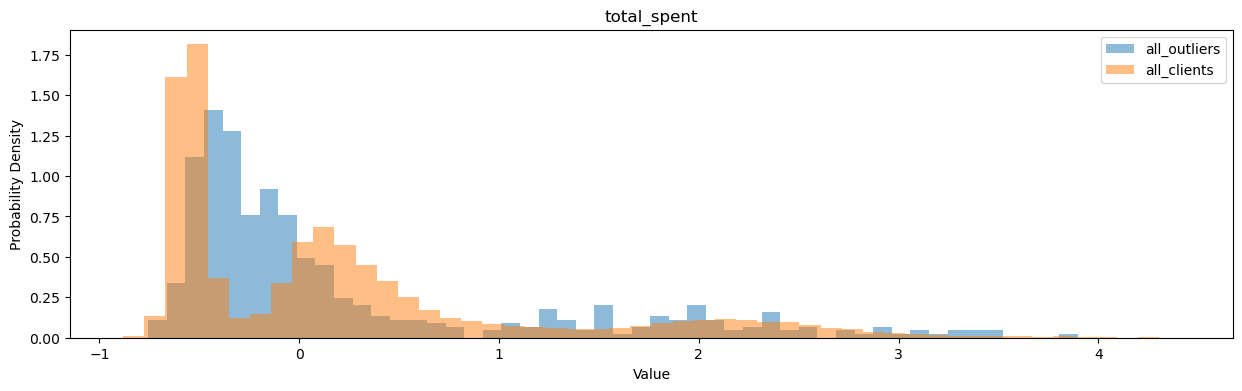

In [17]:
comparing_datasets_visualization(robust_scaller1, all_outliers, 'all_clients', 'all_outliers')

By examining the histograms, we can clearly identify certain patterns, which we colloquially refer to as 'Karens.' To delve deeper into these behaviors, we will utilize k-means clustering to uncover potentially more intriguing insights.

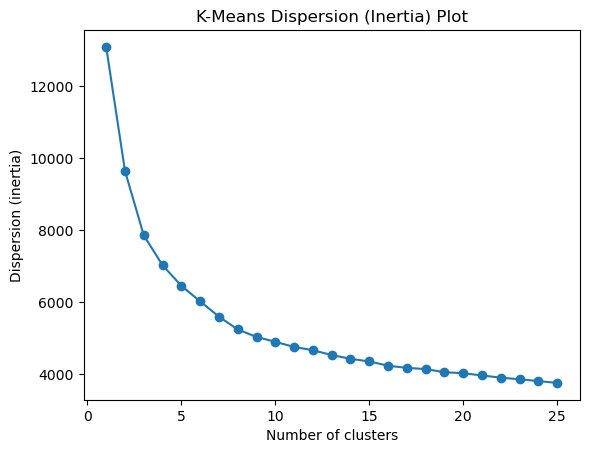

In [27]:
plot_kmeans_dispersion(all_outliers)

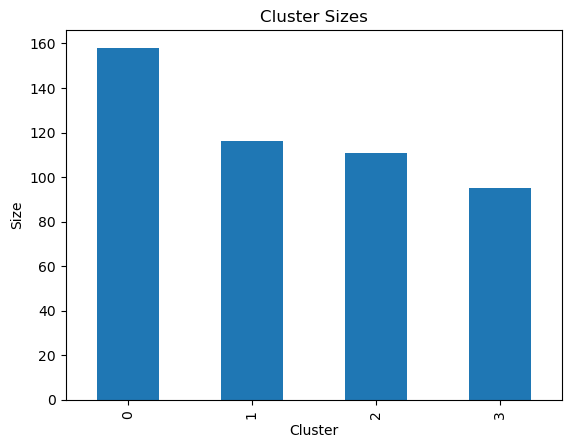

In [42]:
all_outliers=perform_kmeans_clustering_and_plot(all_outliers, n_clusters=4, random_state=0)

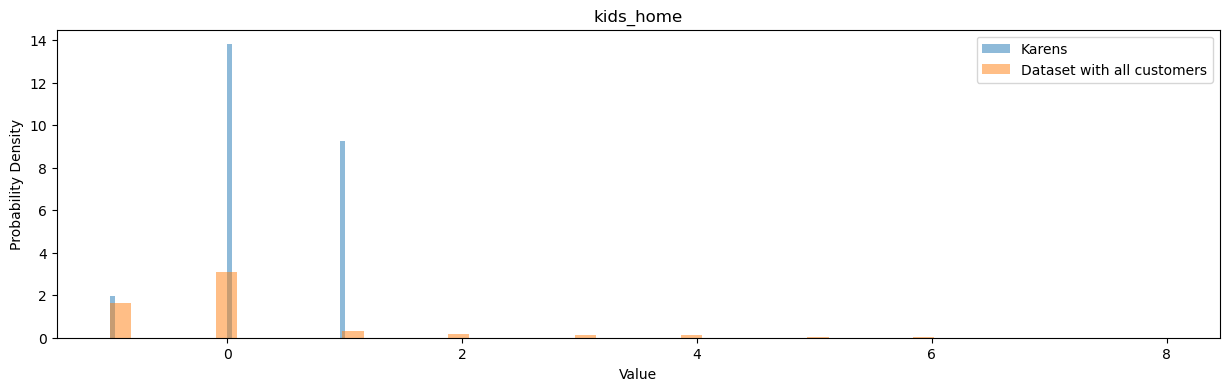

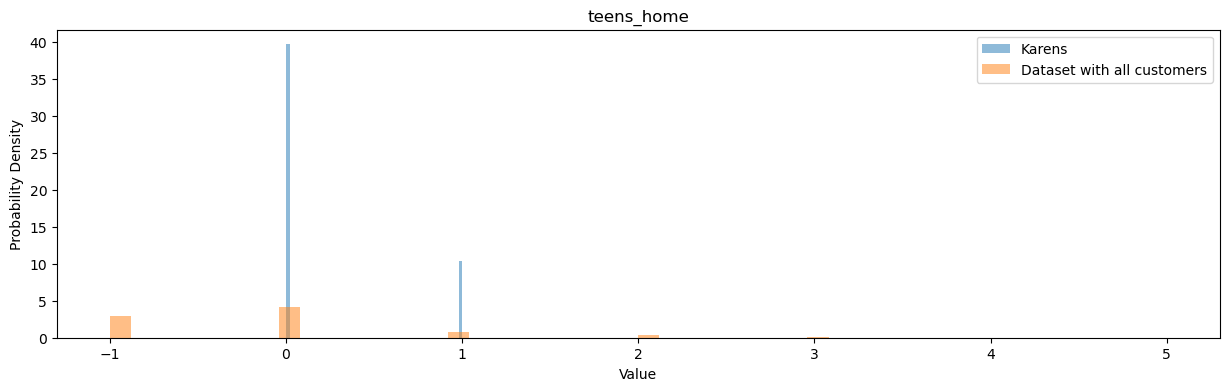

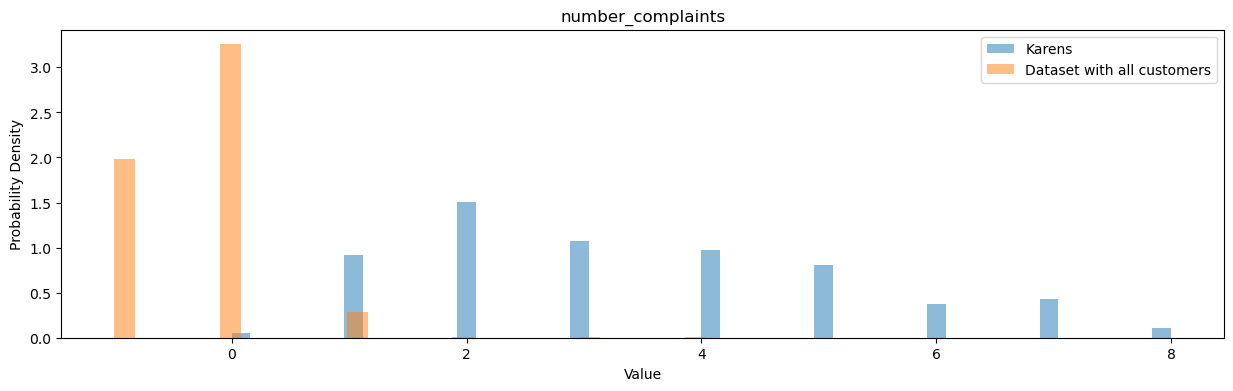

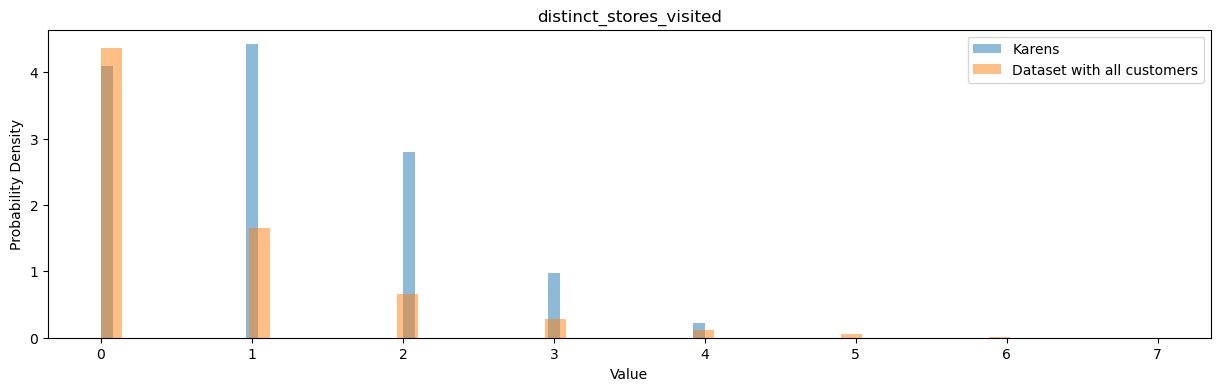

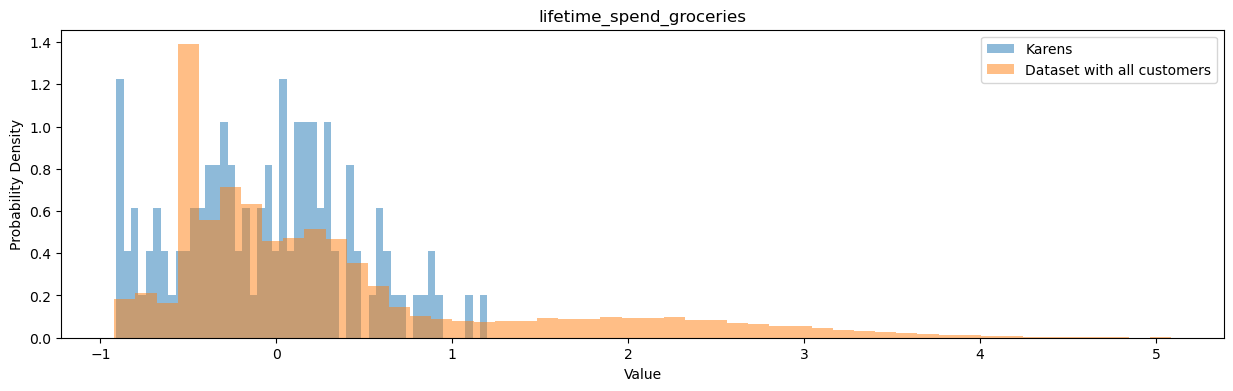

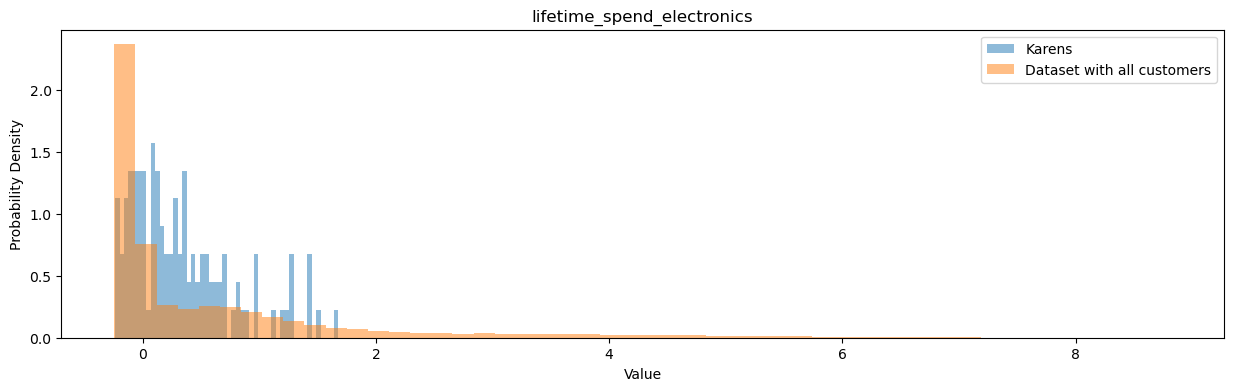

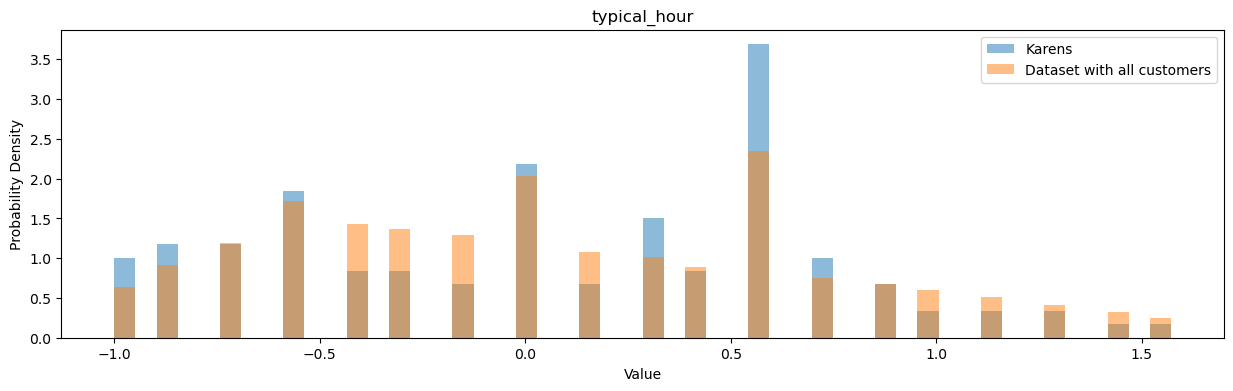

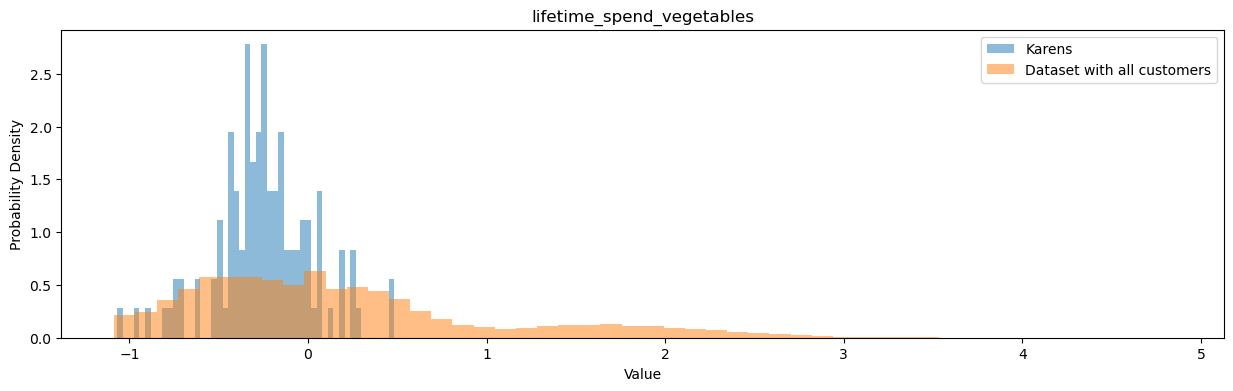

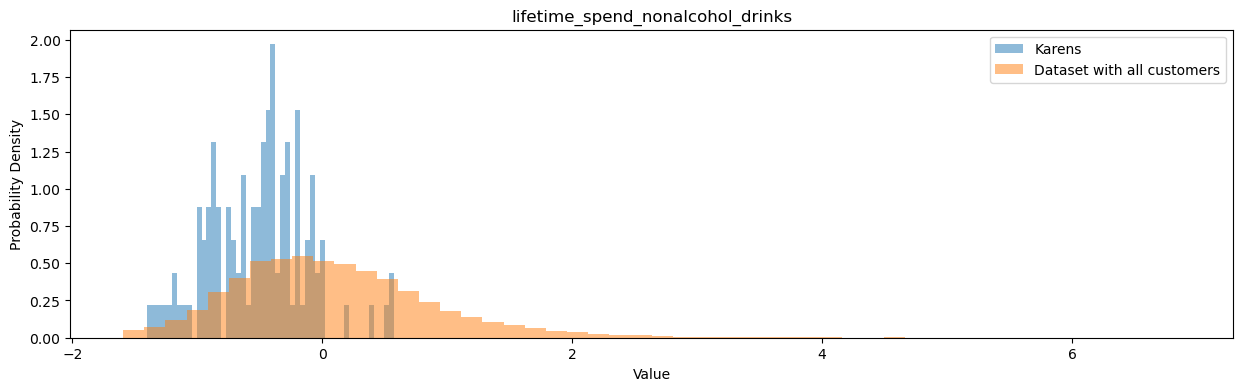

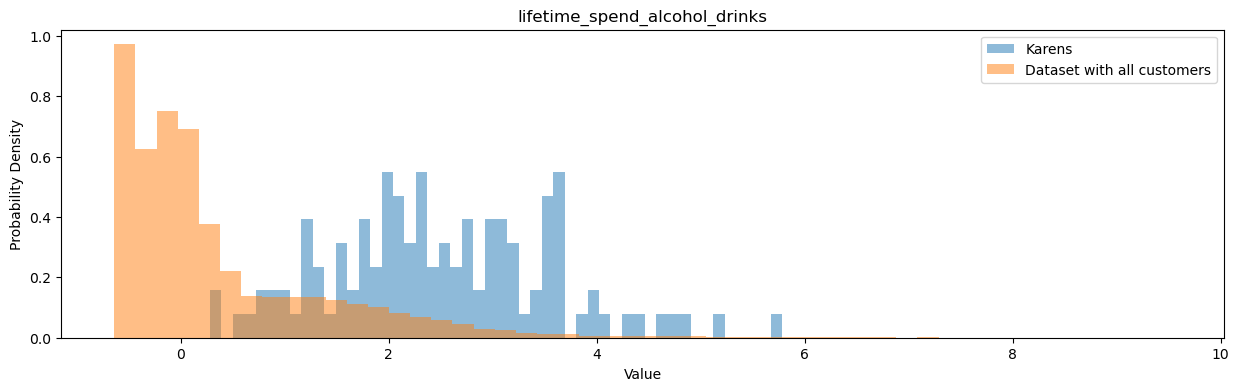

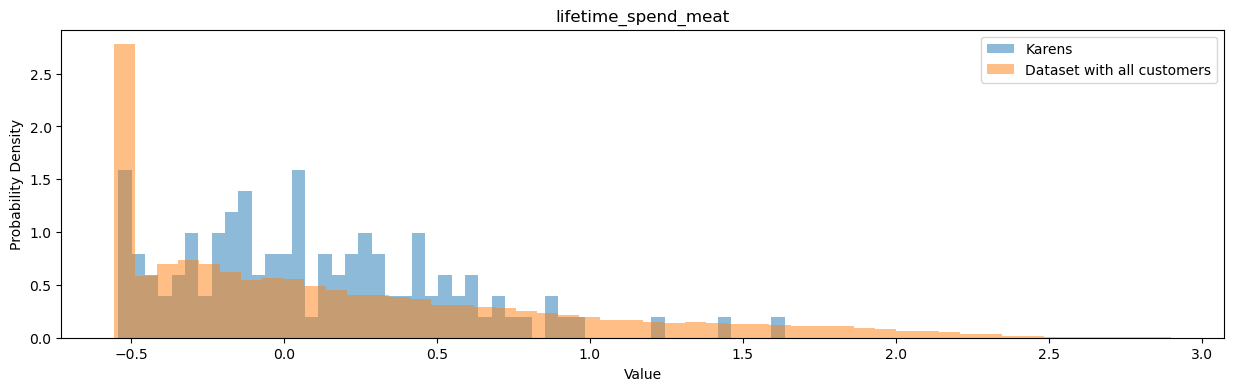

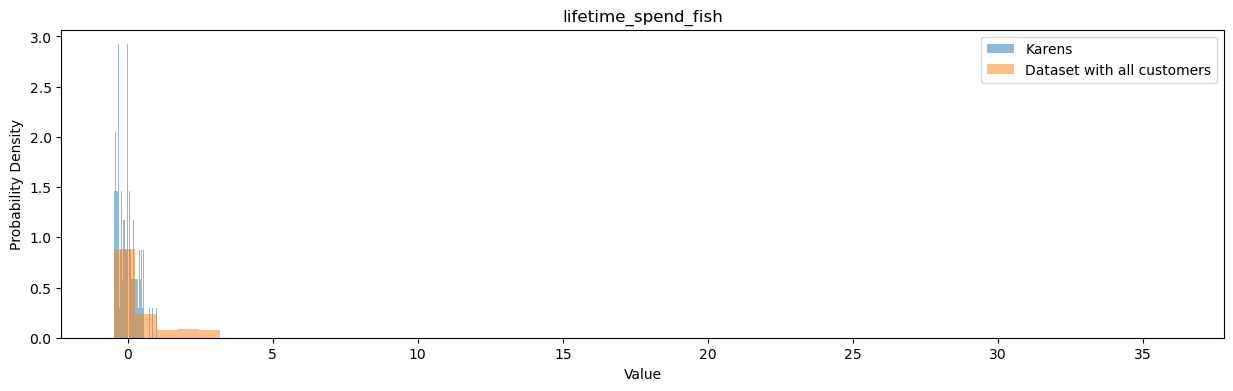

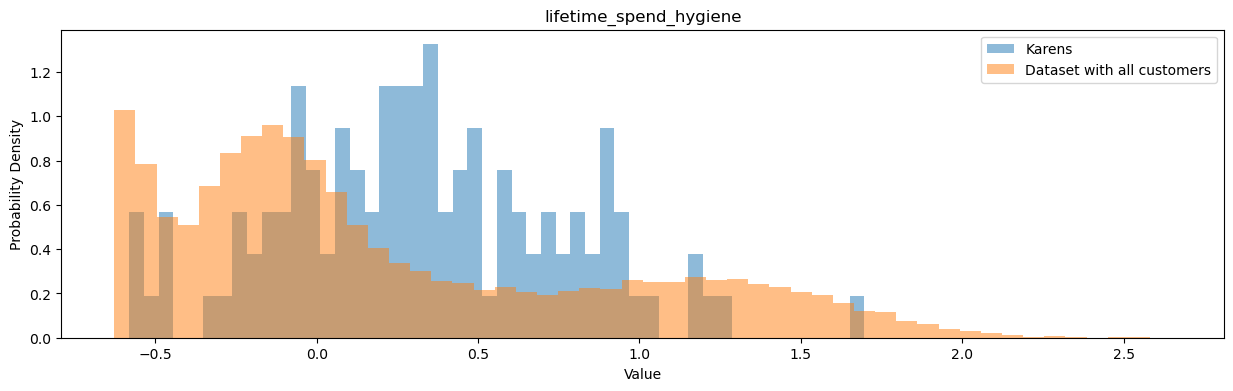

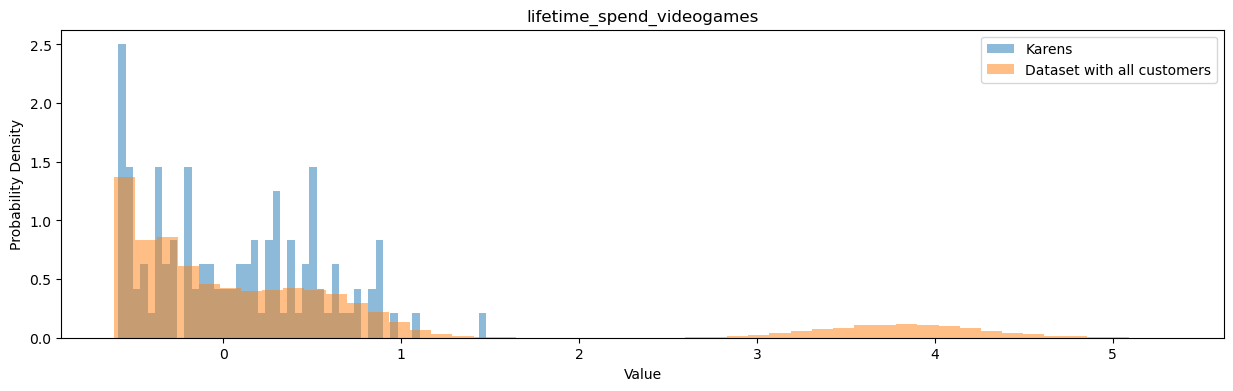

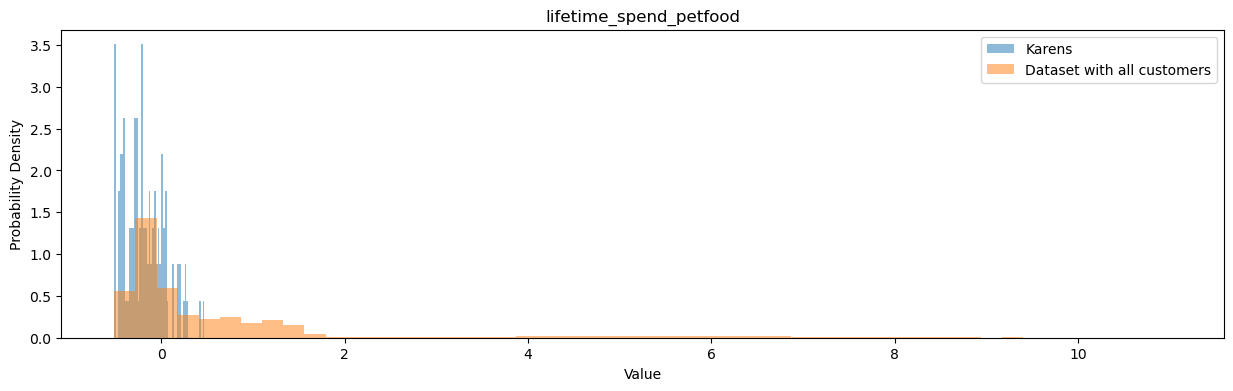

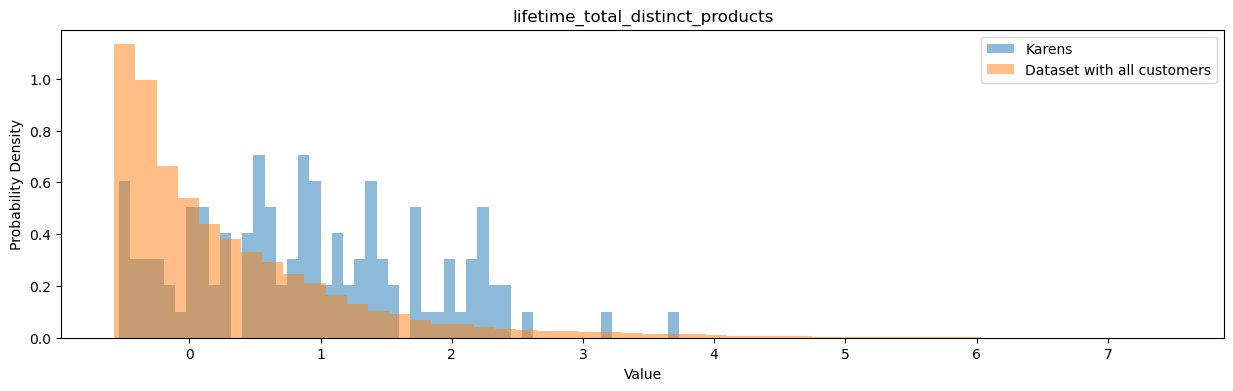

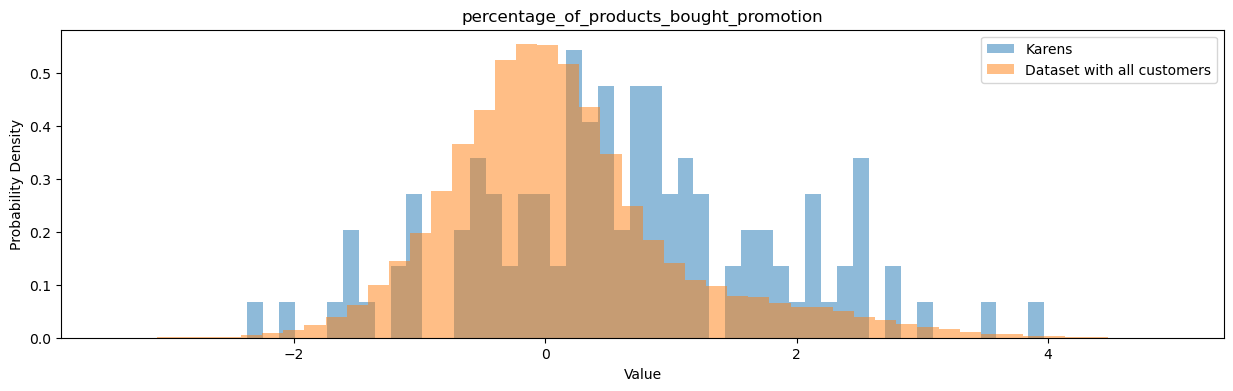

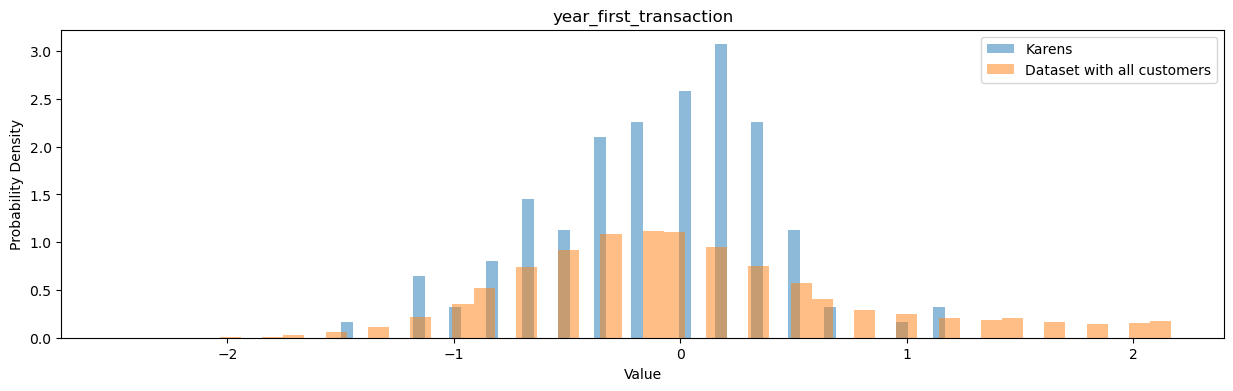

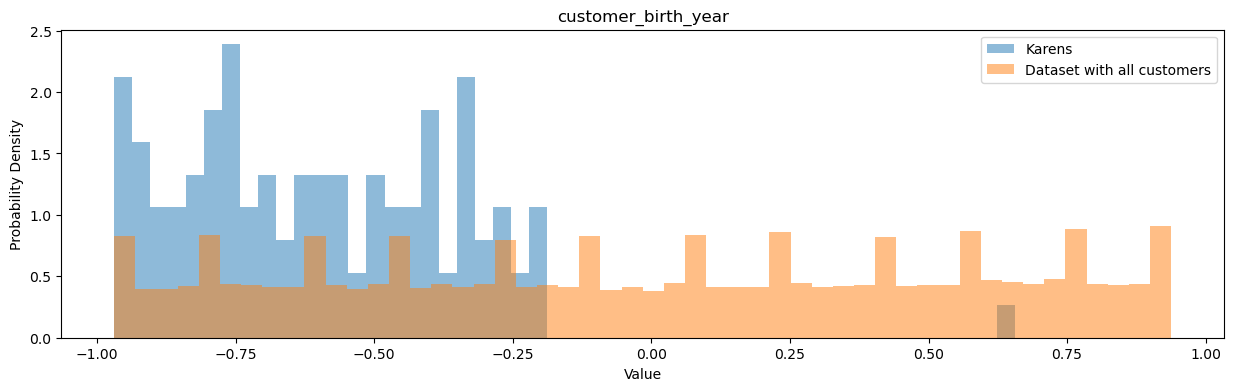

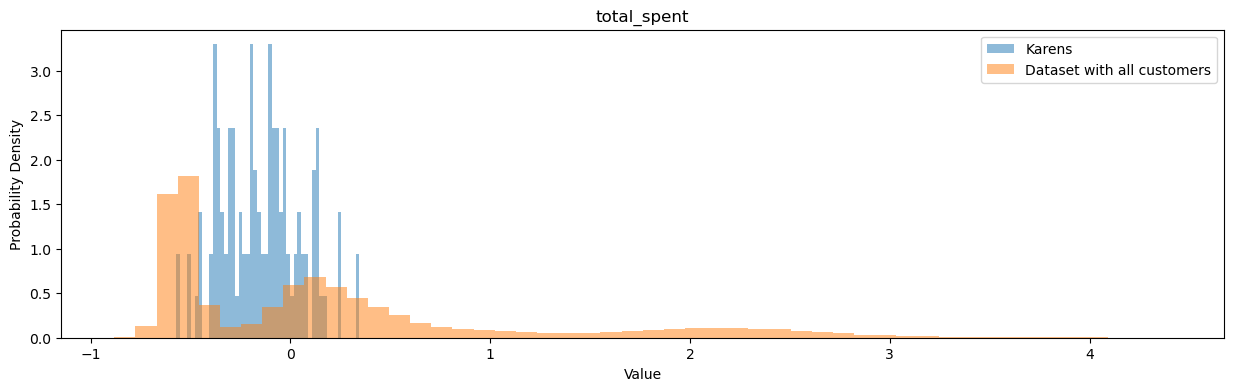

In [414]:
comparing_datasets_visualization(robust_scaller1, all_outliers[all_outliers['cluster_kmeans']==1].iloc[:, :20], 'Dataset with all customers', 'Karens')

After analyzing the four clusters, the only one that exhibited unique characteristics, catching our attention, was the 'Karen' cluster (usually older persons that complays a lot). Therefore, our next step will involve creating a dedicated cluster for them and subsequently removing this cluster from the 'all_outliers' dataset.

In [43]:
karren, all_outliers= remove_cluster('karren', all_outliers, 'cluster_kmeans', 1 )

## 8. Visualization business_behaviour_rb without outliers  <a class="anchor" id="sub_section_8"></a>

Altough it can be seen that some distribution still contain hight values (outliers and possible clusters). We decided not to take them.

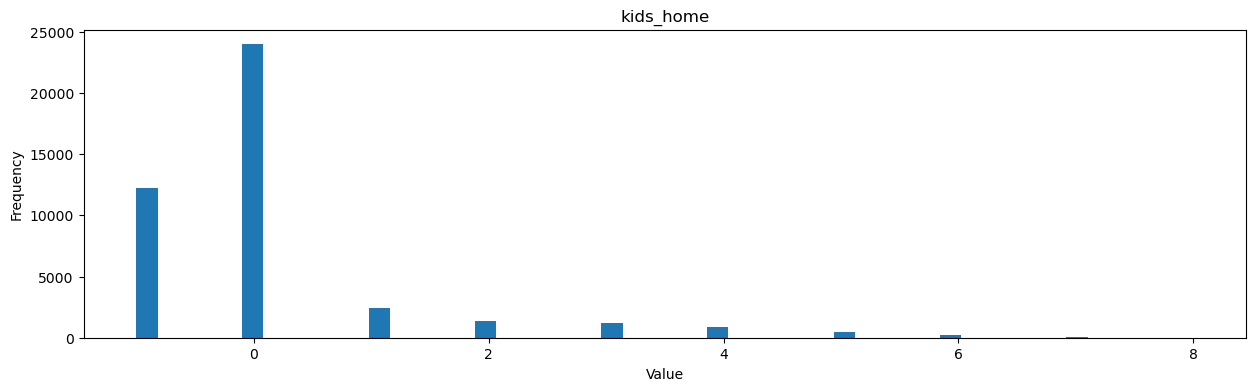

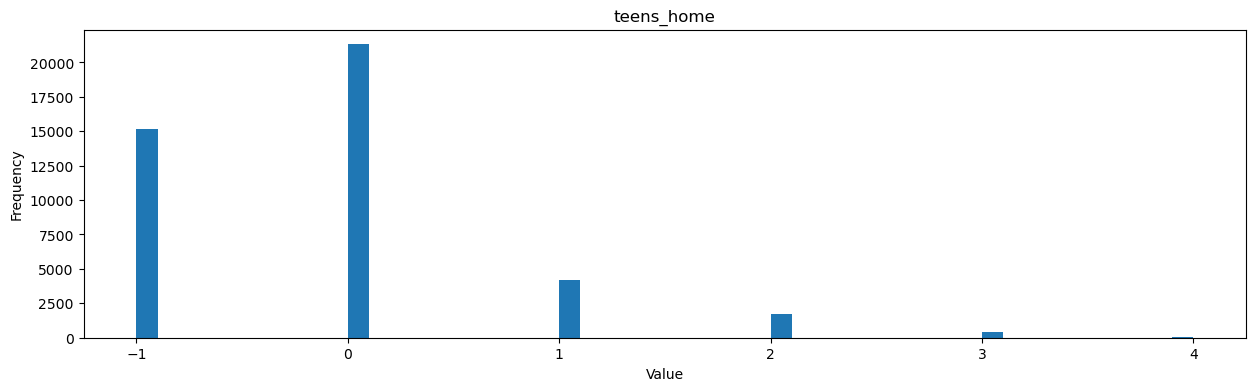

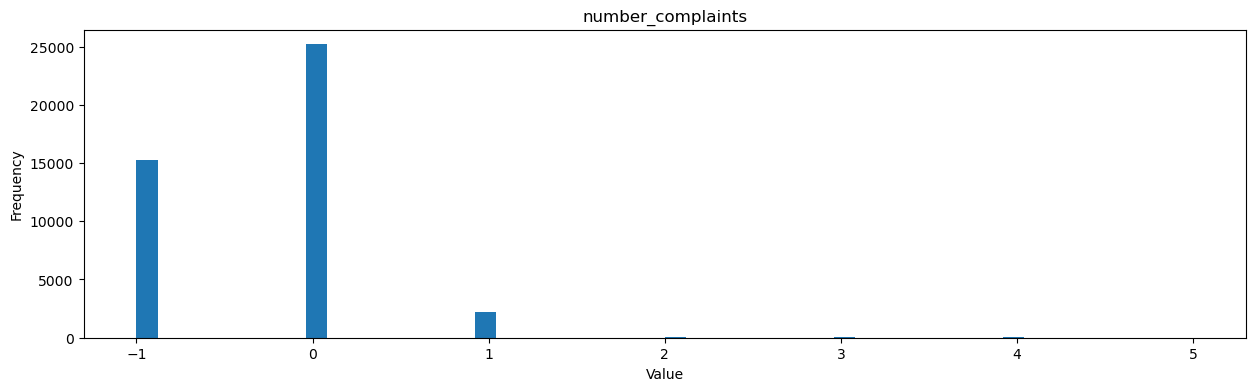

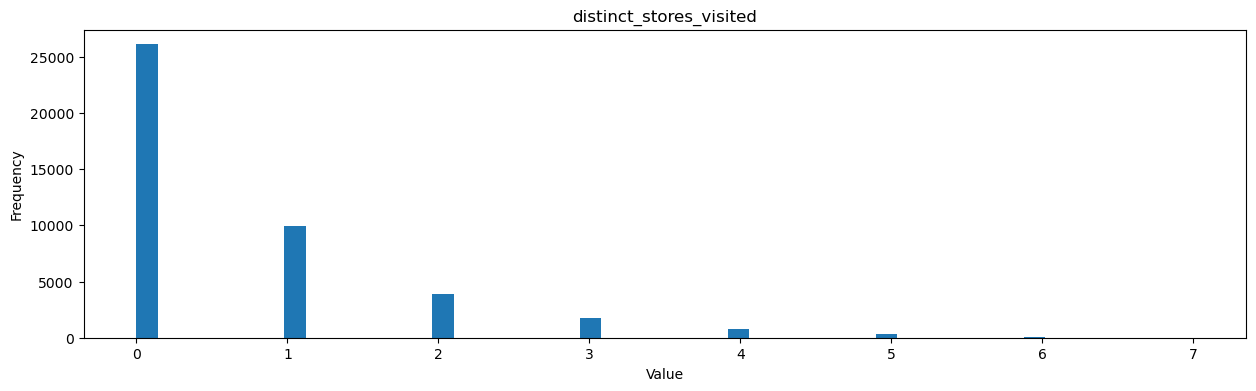

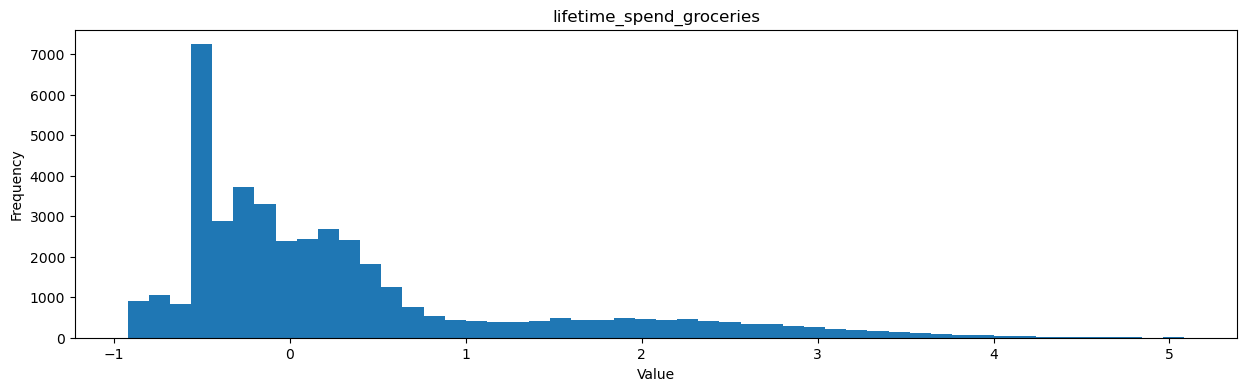

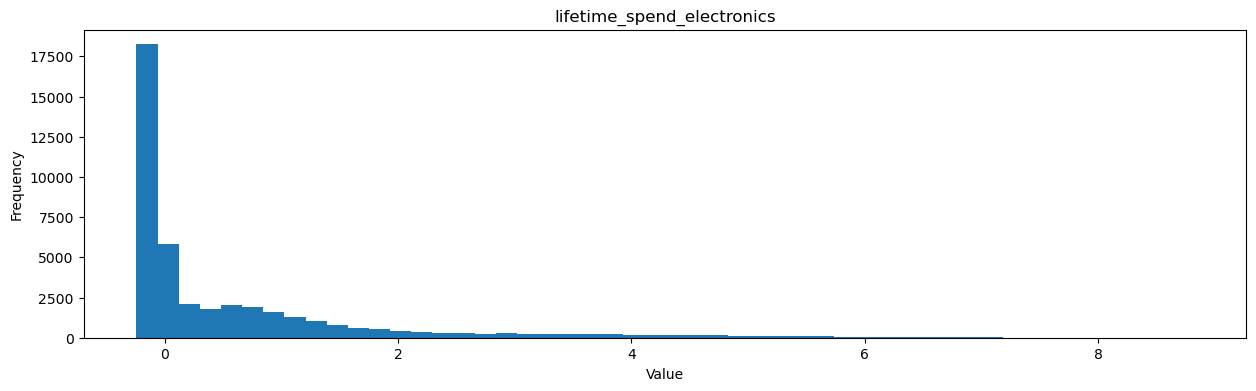

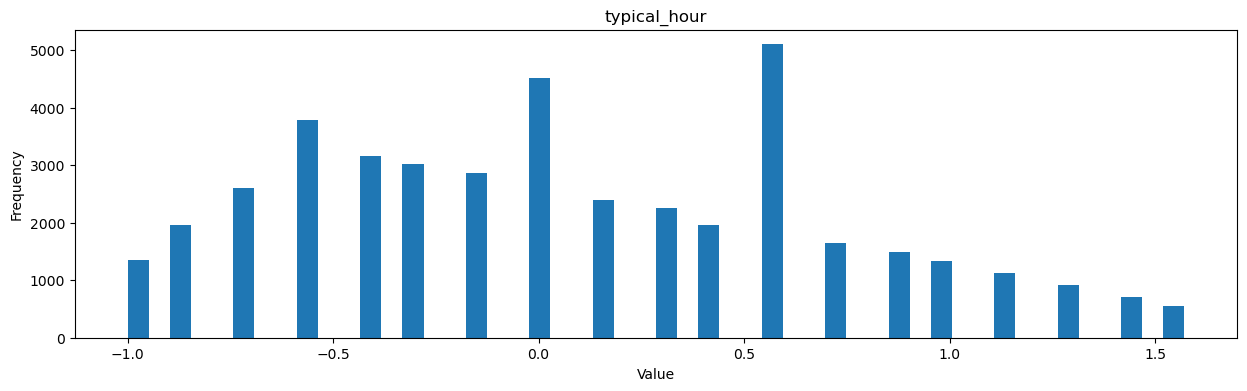

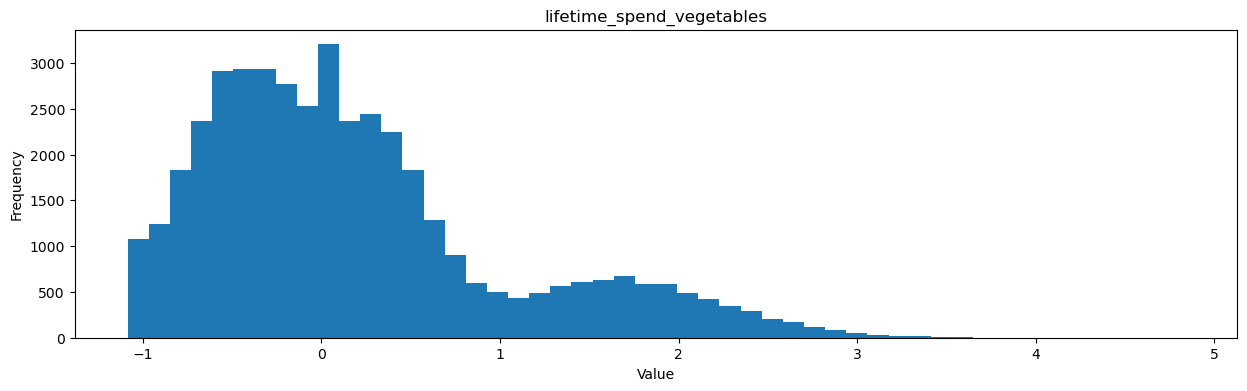

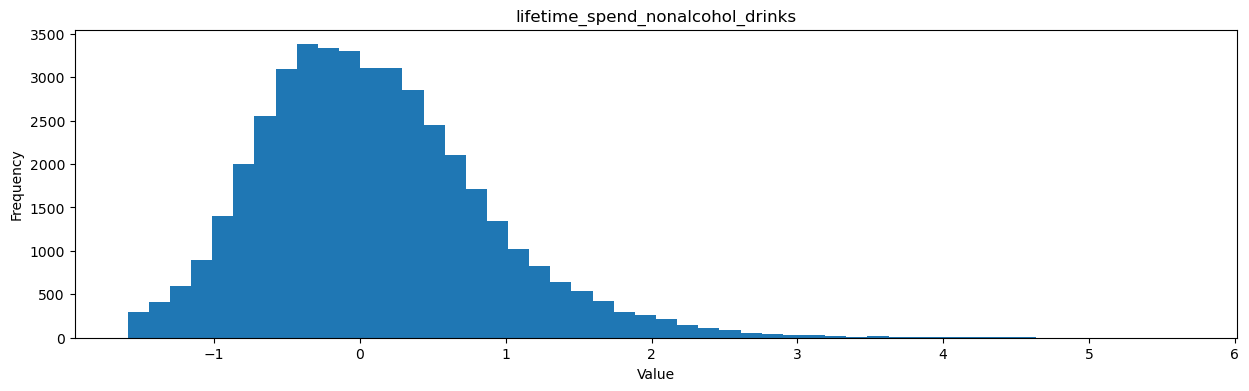

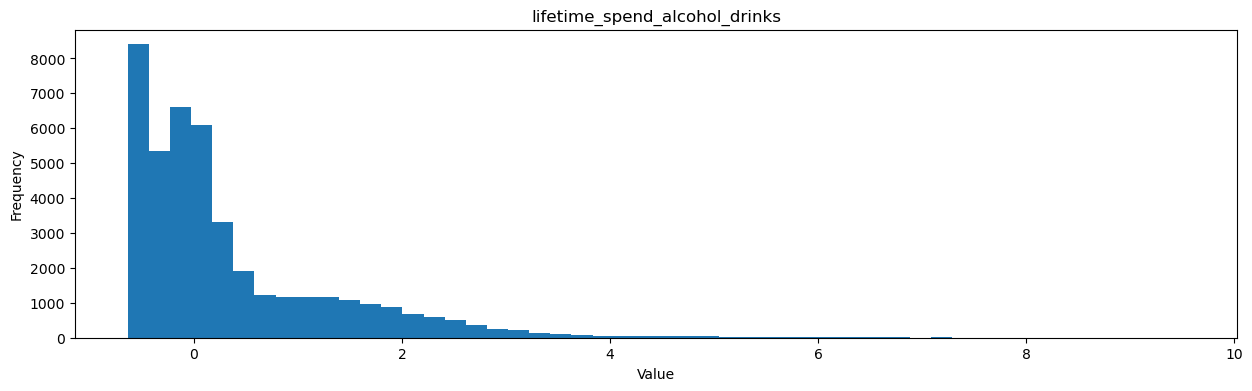

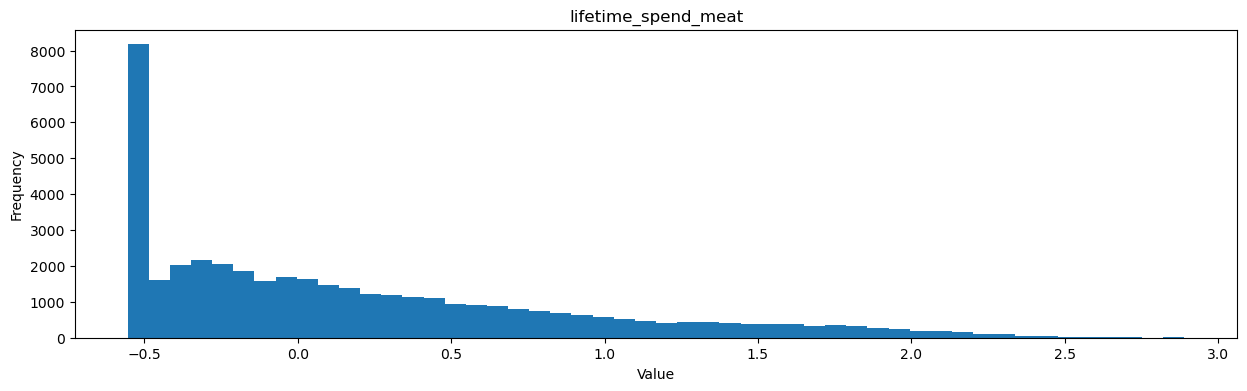

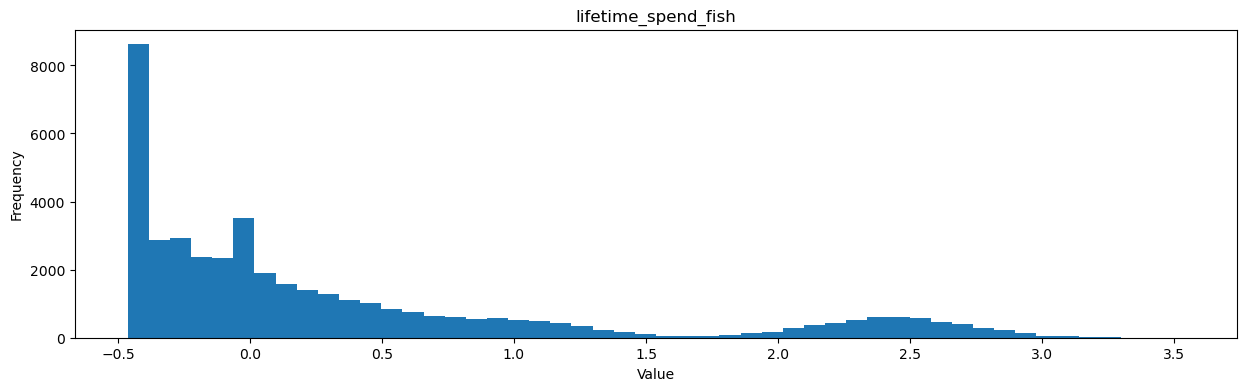

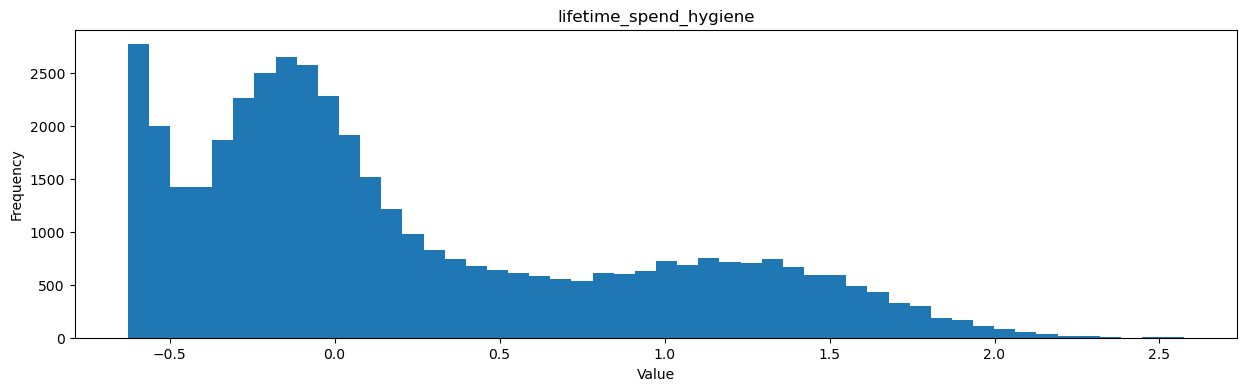

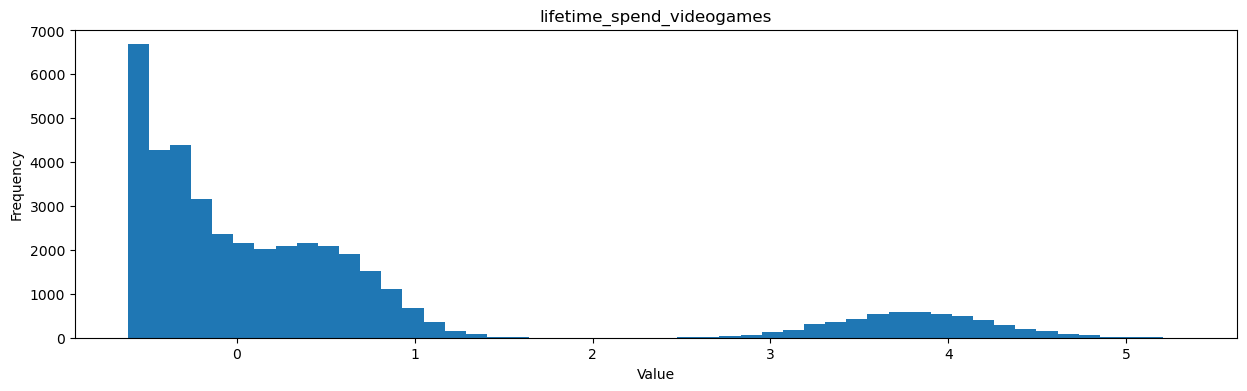

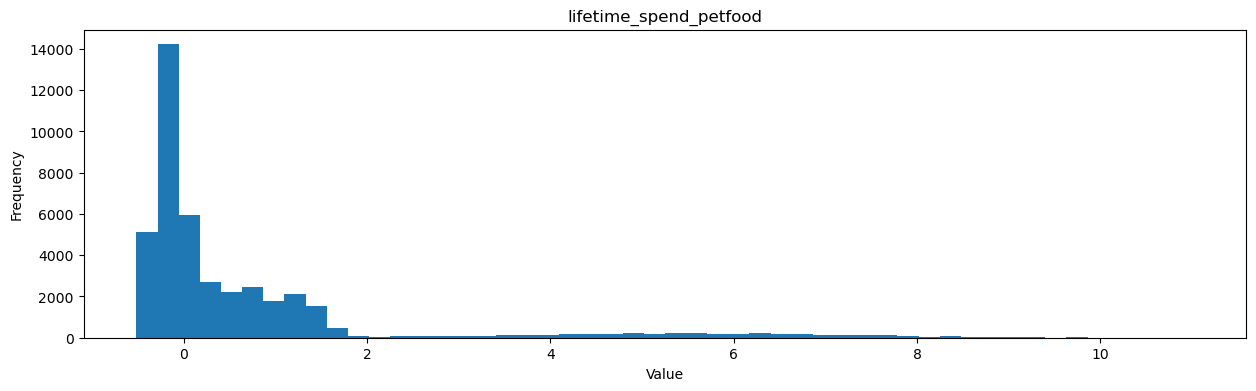

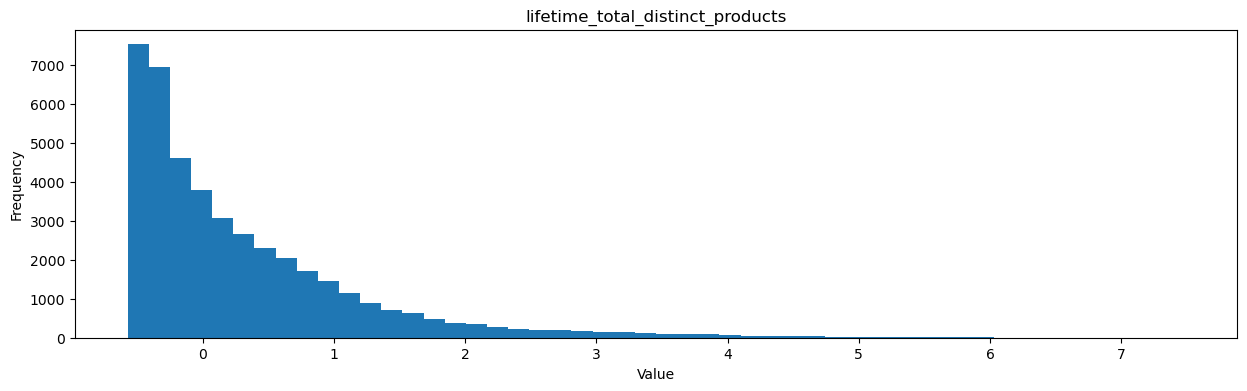

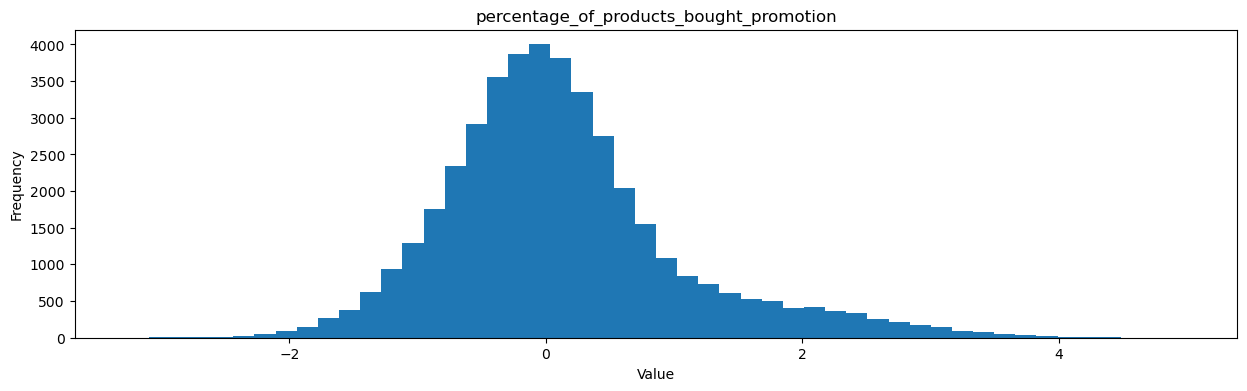

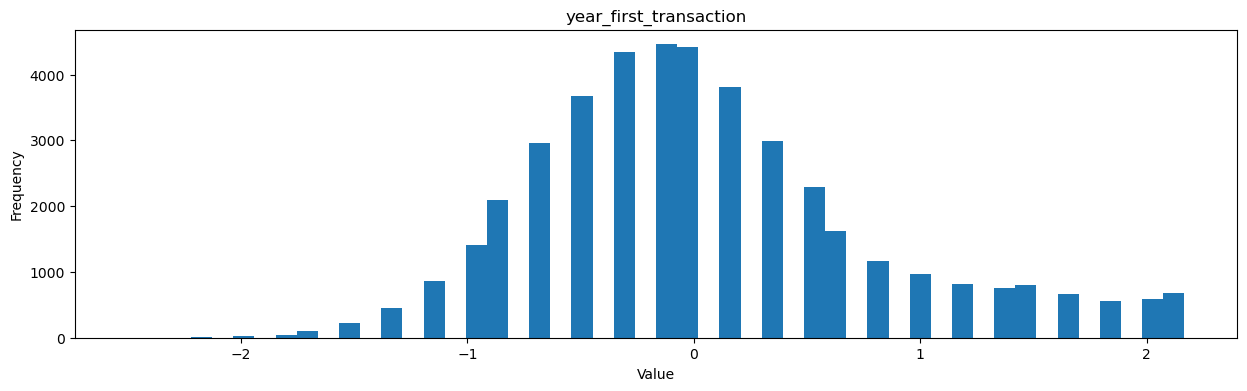

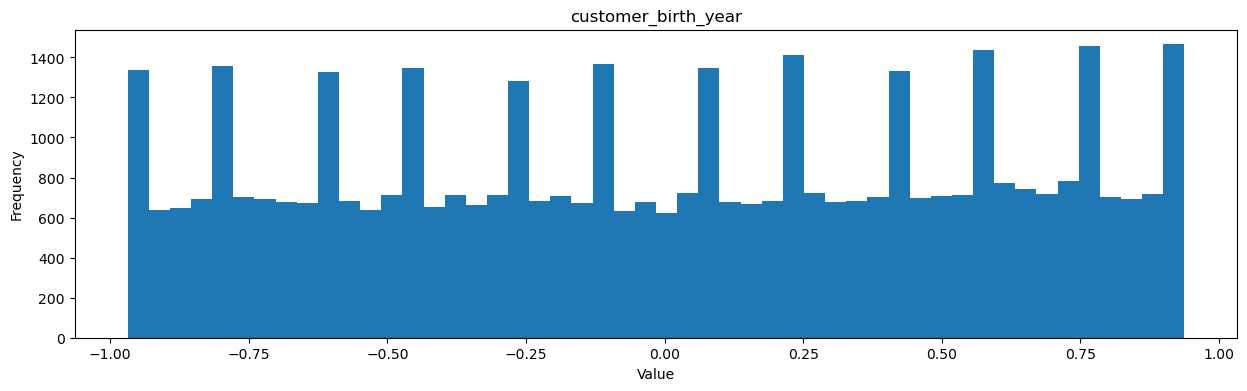

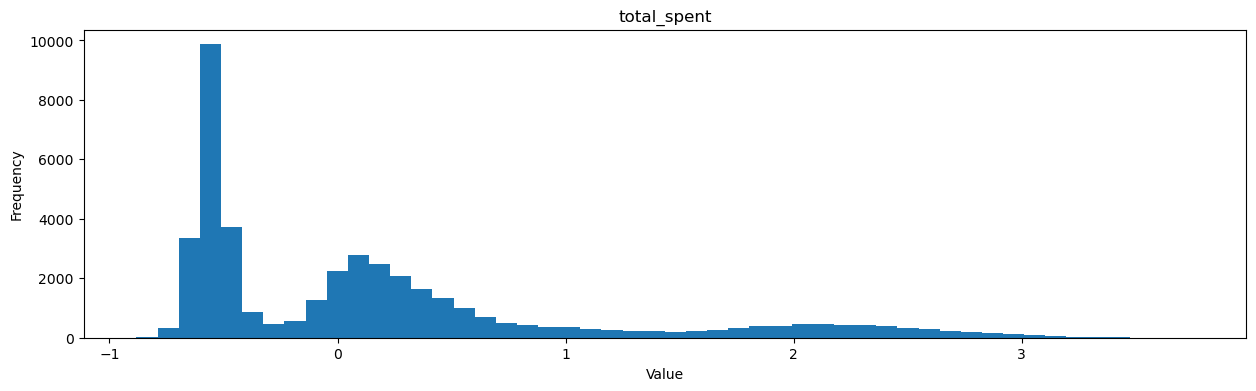

In [76]:
for column in business_behaviour_rb.columns:
    plt.figure(figsize=(15, 4))                     # Adjust the figure size as needed
    plt.hist(business_behaviour_rb[column], bins=50)      # Adjust bins as needed
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

## 9. Clustering business_behaviour_rb  <a class="anchor" id="sub_section_9"></a>

### 9.1 KMeans  <a class="anchor" id="sub_section_9_1"></a>

The first clustering technique that we decided to use is KMeans. In the next steps we are using iloc[:, :20] to make sure, we are only fitting the models the customer variables and not the clustering labels 

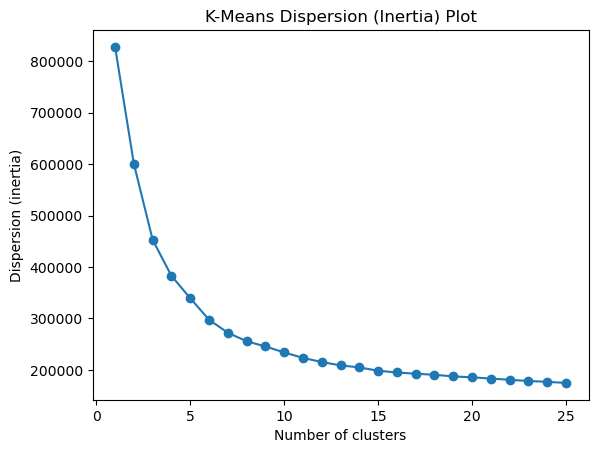

In [78]:
plot_kmeans_dispersion(business_behaviour_rb.iloc[:, :20])

We decided 7 clusters, using the elbow method

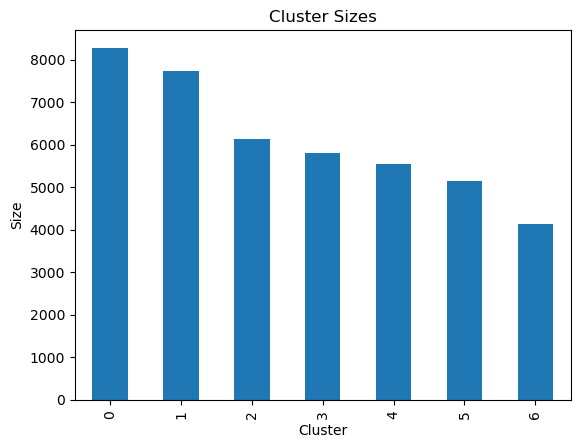

In [44]:
business_behaviour_rb=perform_kmeans_clustering_and_plot(business_behaviour_rb.iloc[:, :20], n_clusters=7, random_state=0)

We conducted a preliminary investigation of the clusters by manually adjusting the KMeans labels in the commented line of code, as can see in the commented line of code. This adjustment is temporary as we plan to further explore and compare various clustering techniques.

In [ ]:
#comparing_datasets_visualization(robust_scaller1, business_behaviour_rb[business_behaviour_rb['cluster_kmeans'] == 2].iloc[:, :20], 'All costumer',KMeans cluster)

Another important information is the silhoutte_score that is a statistical tool that can help us in clustering avaliation. In this case the score is low

In [32]:
# Compute silhouette score
silhouette_avg = silhouette_score(business_behaviour_rb.iloc[:, :20], business_behaviour_rb['cluster_kmeans'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.30581169981248885


### 9.2 Mean-Shift  <a class="anchor" id="sub_section_9_2"></a>

One of the challenges encountered with Mean-Shift clustering was determining the appropriate bandwidth. Although attempting to use an estimator for this purpose proved unsuccessful, after several iterations, we settled on a bandwidth value of 2. However, it's noteworthy that not all points were associated with a cluster using this bandwidth. To facilitate comparison with other clustering methods (Confusion Matrix), we decided to consolidate clusters with fewer than 500 clients into a single cluster.

In [45]:
ms= MeanShift(bandwidth = 2, n_jobs=-1, bin_seeding=True)  
business_behaviour_rb['Mean_shift']=ms.fit_predict(business_behaviour_rb.iloc[:, :20])  #running the model

In [46]:
cluster_counts = business_behaviour_rb['Mean_shift'].value_counts()

# Identify clusters with fewer than 500 clients
small_clusters = cluster_counts[cluster_counts < 500].index.tolist()

# Reassign points from small clusters to a new cluster label
business_behaviour_rb.loc[business_behaviour_rb['Mean_shift'].isin(small_clusters), 'Mean_shift'] = 111

In [47]:
business_behaviour_rb['Mean_shift'].value_counts().head(15)

0      7833
1      7410
4      5654
5      4808
6      4513
2      4140
111    3900
3      2772
7      1037
18      705
Name: Mean_shift, dtype: int64

In [36]:
silhouette_avg = silhouette_score(business_behaviour_rb.iloc[:, :20], business_behaviour_rb['Mean_shift'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.26434197142900107


 ### 9.3 Hierarchical clustering  <a class="anchor" id="sub_section_9_3"></a>

Using the ward method we did Hierarchical clustering

In [48]:
centroid=create_centroid_dataset(business_behaviour_rb.iloc[:, :20])

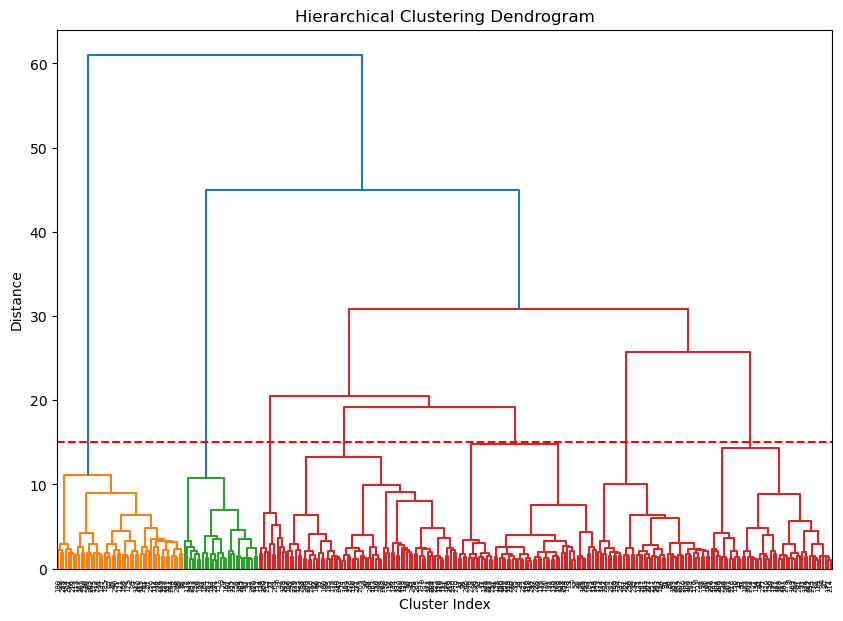

In [49]:
business_behaviour_rb1=perform_hierarchical_clustering_and_label_data(centroid, business_behaviour_rb.iloc[:, :20],y_line=15)


In [50]:
business_behaviour_rb=business_behaviour_rb.merge(business_behaviour_rb1['Cluster'], left_index=True, right_index=True)
business_behaviour_rb['Cluster'].value_counts()

5    10321
4     9676
7     6989
1     5547
6     4931
2     4248
3     1060
Name: Cluster, dtype: int64

In [40]:
silhouette_avg = silhouette_score(business_behaviour_rb.iloc[:, :20], business_behaviour_rb['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.2863458263340555


### 9.4 Comparing clustering  <a class="anchor" id="sub_section_9_4"></a>

In [26]:

pd.DataFrame(
    confusion_matrix(business_behaviour_rb['cluster_kmeans'], business_behaviour_rb['Mean_shift']),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,10)],
    columns = ['Mean_shift {} Cluster'.format(i) for i in np.arange(0,10)],
)

Mean_shift 0 Cluster  Mean_shift 1 Cluster  \
K-means 0 Cluster                    13                    36   
K-means 1 Cluster                  7820                    92   
K-means 2 Cluster                     0                  7282   
K-means 3 Cluster                     0                     0   
K-means 4 Cluster                     0                     0   
K-means 5 Cluster                     0                     0   
K-means 6 Cluster                     0                     0   
K-means 7 Cluster                     0                     0   
K-means 8 Cluster                     0                     0   
K-means 9 Cluster                     0                     0   

                   Mean_shift 2 Cluster  Mean_shift 3 Cluster  \
K-means 0 Cluster                     0                  2547   
K-means 1 Cluster                     6                   154   
K-means 2 Cluster                     0                    66   
K-means 3 Cluster                     0                     0   
K-means 4 Cluster                     0                     0   
K-means 5 Cluster                  4134                     5   
K-means 6 Cluster                     0                     0   
K-means 7 Cluster                     0                     0   
K-means 8 Cluster                     0                     0   
K-means 9 Cluster                     0                     0   

                   Mean_shift 4 Cluster  Mean_shift 5 Cluster  \
K-means 0 Cluster                   788                  4804   
K-means 1 Cluster                   118                     0   
K-means 2 Cluster                    10                     3   
K-means 3 Cluster                  4738                     1   
K-means 4 Cluster                     0                     0   
K-means 5 Cluster                     0                     0   
K-means 6 Cluster                     0                     0   
K-means 7 Cluster                     0                     0   
K-means 8 Cluster                     0                     0   
K-means 9 Cluster                     0                     0   

                   Mean_shift 6 Cluster  Mean_shift 7 Cluster  \
K-means 0 Cluster                     0                   892   
K-means 1 Cluster                     0                    87   
K-means 2 Cluster                     0                    58   
K-means 3 Cluster                     0                     0   
K-means 4 Cluster                  4513                     0   
K-means 5 Cluster                     0                     0   
K-means 6 Cluster                     0                     0   
K-means 7 Cluster                     0                     0   
K-means 8 Cluster                     0                     0   
K-means 9 Cluster                     0                     0   

                   Mean_shift 8 Cluster  Mean_shift 9 Cluster  
K-means 0 Cluster                     0                  1065  
K-means 1 Cluster                     0                   826  
K-means 2 Cluster                     0                   812  
K-means 3 Cluster                   705                   163  
K-means 4 Cluster                     0                  1034  
K-means 5 Cluster                     0                     0  
K-means 6 Cluster                     0                   368  
K-means 7 Cluster                     0                     0  
K-means 8 Cluster                     0                     0  
K-means 9 Cluster                     0                     0

In [51]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(business_behaviour_rb['Cluster'], business_behaviour_rb['Mean_shift']),
    index = ['hierarchical  {} Cluster'.format(i) for i in np.arange(0,10)],
    columns = ['Mean_shift {} Cluster'.format(i) for i in np.arange(0,10)],
)

Mean_shift 0 Cluster  Mean_shift 1 Cluster  \
hierarchical  0 Cluster                     0                     0   
hierarchical  1 Cluster                     0                     0   
hierarchical  2 Cluster                    47                     4   
hierarchical  3 Cluster                     0                     0   
hierarchical  4 Cluster                   369                  7335   
hierarchical  5 Cluster                  7386                    63   
hierarchical  6 Cluster                     0                     0   
hierarchical  7 Cluster                    31                     8   
hierarchical  8 Cluster                     0                     0   
hierarchical  9 Cluster                     0                     0   

                         Mean_shift 2 Cluster  Mean_shift 3 Cluster  \
hierarchical  0 Cluster                     0                     0   
hierarchical  1 Cluster                     0                     0   
hierarchical  2 Cluster                  4140                    47   
hierarchical  3 Cluster                     0                     8   
hierarchical  4 Cluster                     0                    68   
hierarchical  5 Cluster                     0                  2361   
hierarchical  6 Cluster                     0                    66   
hierarchical  7 Cluster                     0                   222   
hierarchical  8 Cluster                     0                     0   
hierarchical  9 Cluster                     0                     0   

                         Mean_shift 4 Cluster  Mean_shift 5 Cluster  \
hierarchical  0 Cluster                     0                     0   
hierarchical  1 Cluster                     0                     0   
hierarchical  2 Cluster                     0                     0   
hierarchical  3 Cluster                     0                     0   
hierarchical  4 Cluster                    28                    14   
hierarchical  5 Cluster                     3                     0   
hierarchical  6 Cluster                     5                  4733   
hierarchical  7 Cluster                  5618                    61   
hierarchical  8 Cluster                     0                     0   
hierarchical  9 Cluster                     0                     0   

                         Mean_shift 6 Cluster  Mean_shift 7 Cluster  \
hierarchical  0 Cluster                     0                     0   
hierarchical  1 Cluster                  4513                     0   
hierarchical  2 Cluster                     0                     0   
hierarchical  3 Cluster                     0                   998   
hierarchical  4 Cluster                     0                     5   
hierarchical  5 Cluster                     0                    34   
hierarchical  6 Cluster                     0                     0   
hierarchical  7 Cluster                     0                     0   
hierarchical  8 Cluster                     0                     0   
hierarchical  9 Cluster                     0                     0   

                         Mean_shift 8 Cluster  Mean_shift 9 Cluster  
hierarchical  0 Cluster                     0                     0  
hierarchical  1 Cluster                     0                  1034  
hierarchical  2 Cluster                     0                    10  
hierarchical  3 Cluster                     0                    54  
hierarchical  4 Cluster                     0                  1857  
hierarchical  5 Cluster                     0                   474  
hierarchical  6 Cluster                     0                   127  
hierarchical  7 Cluster                   705                   344  
hierarchical  8 Cluster                     0                     0  
hierarchical  9 Cluster                     0                     0

### 9.5 Visualization  <a class="anchor" id="sub_section_9_4"></a>

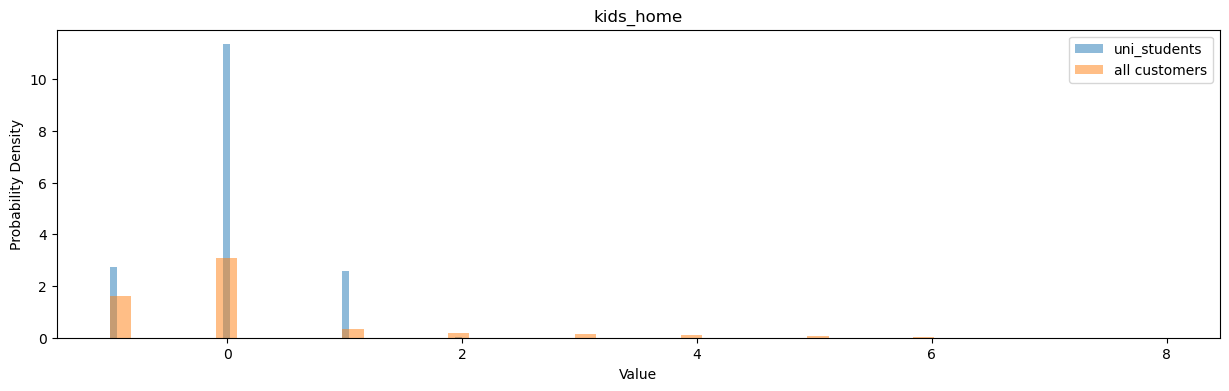

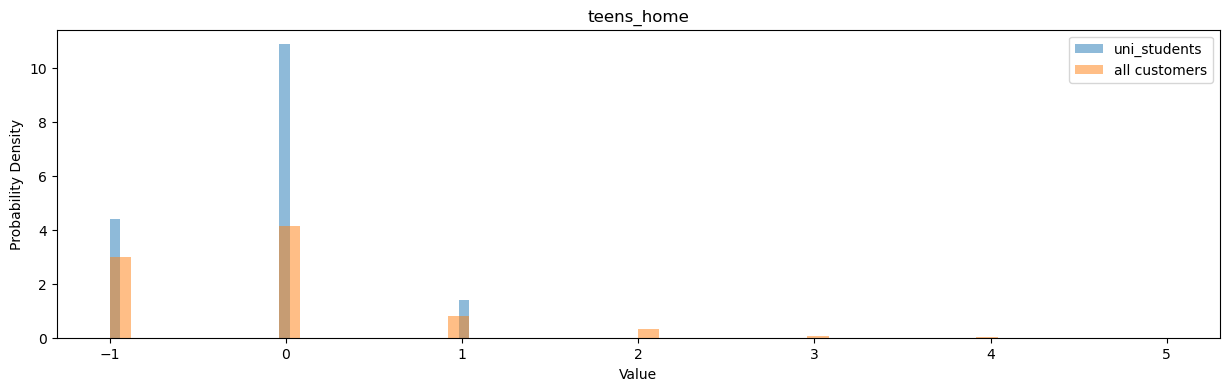

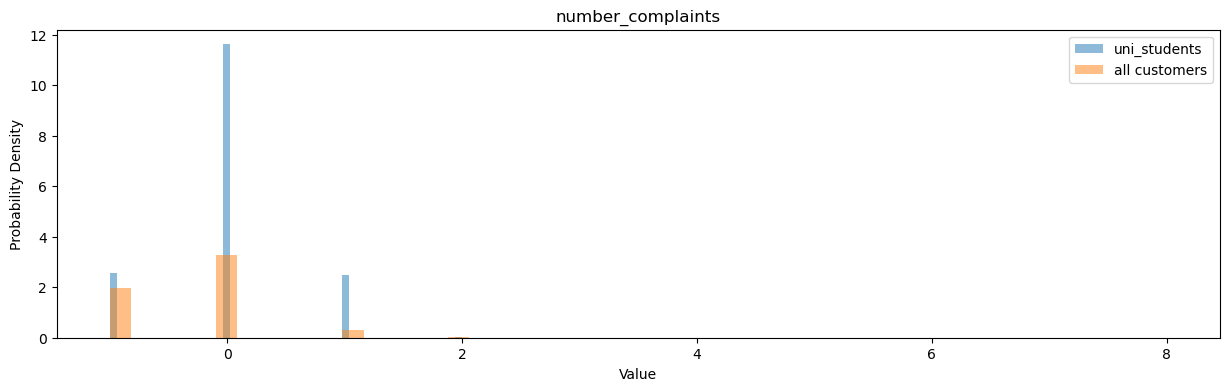

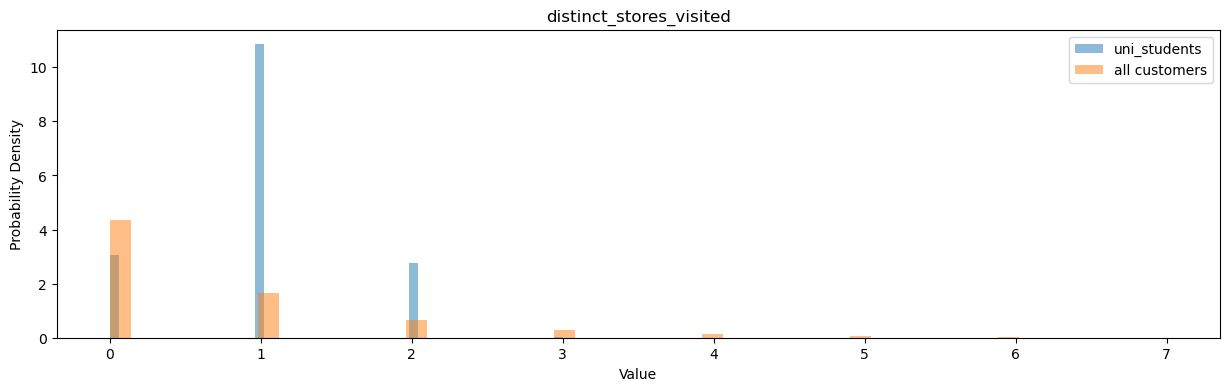

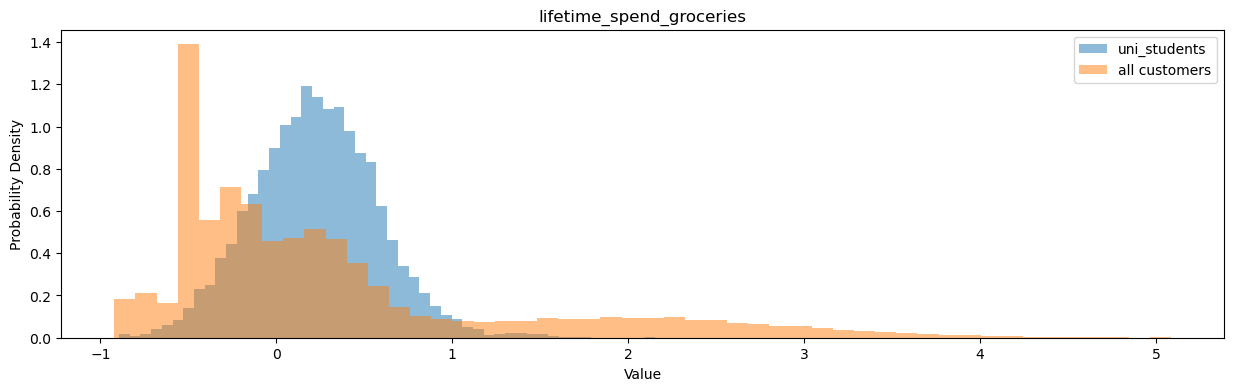

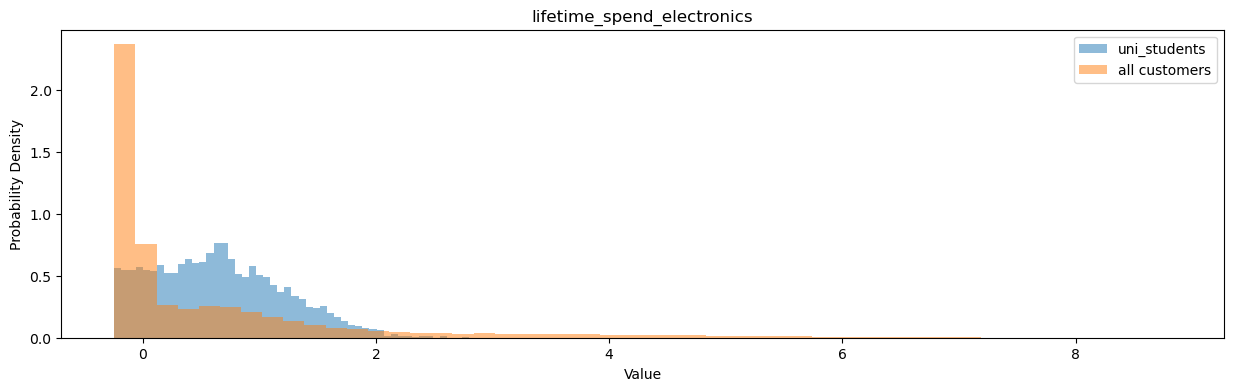

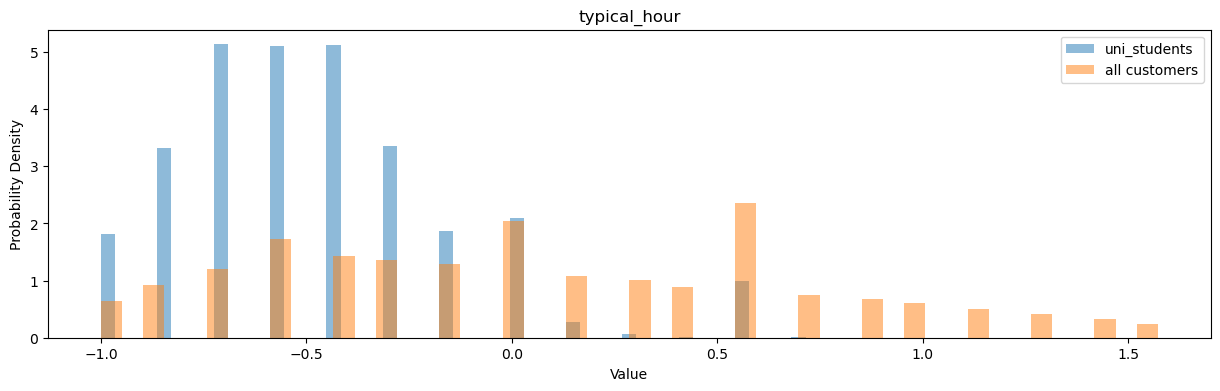

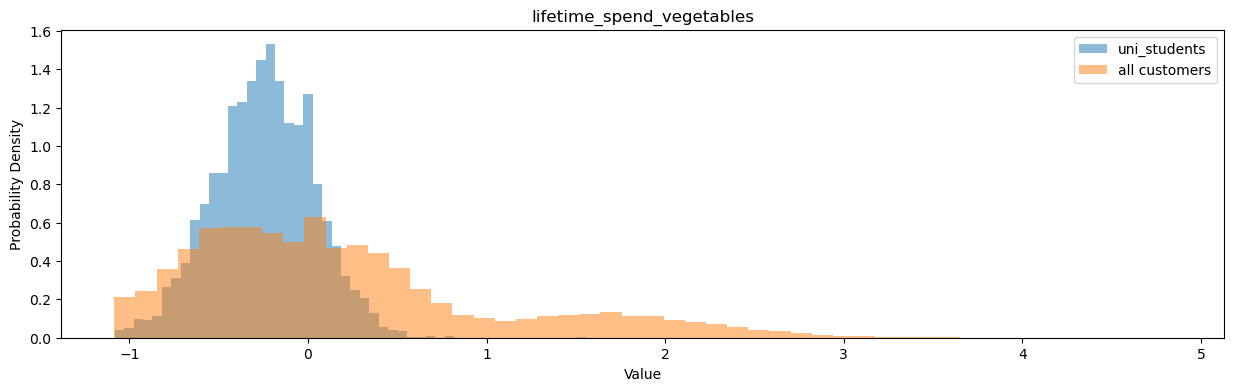

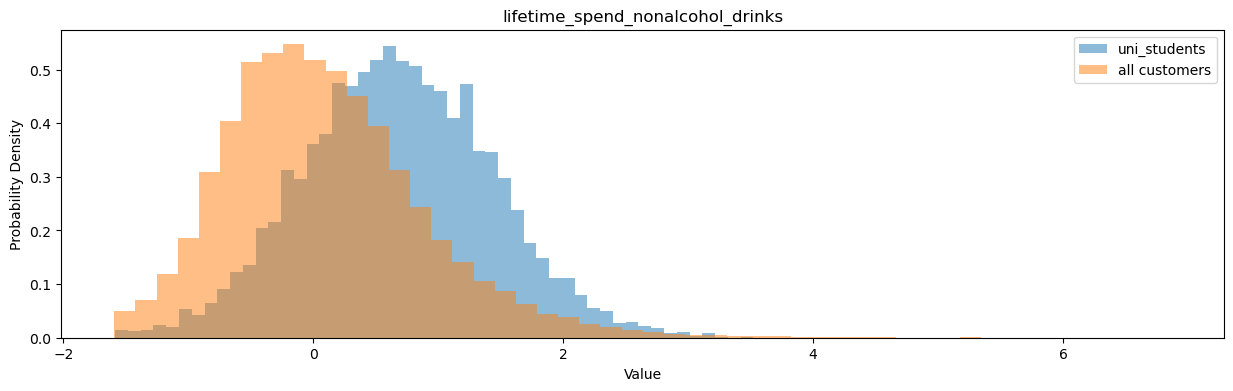

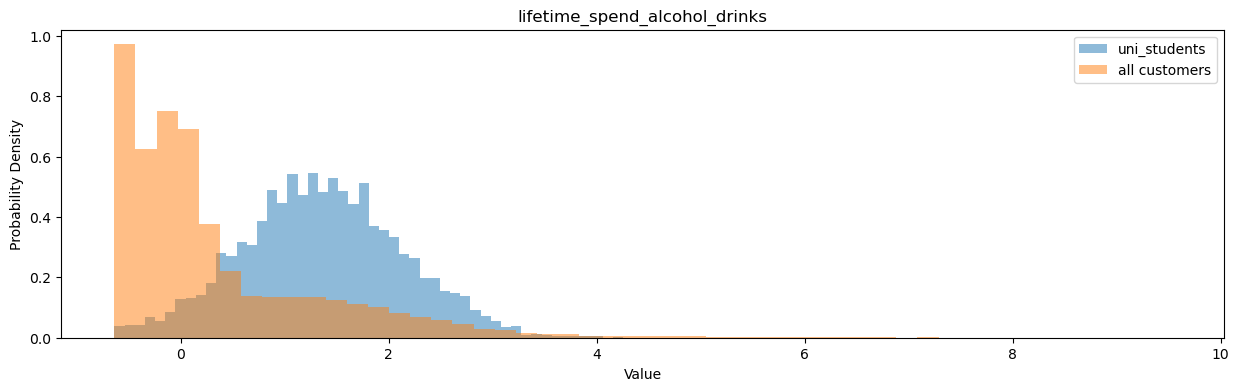

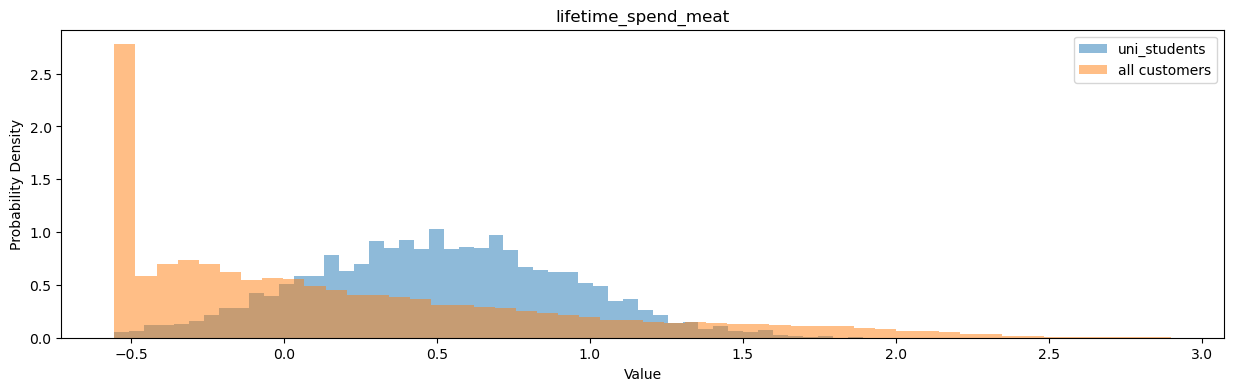

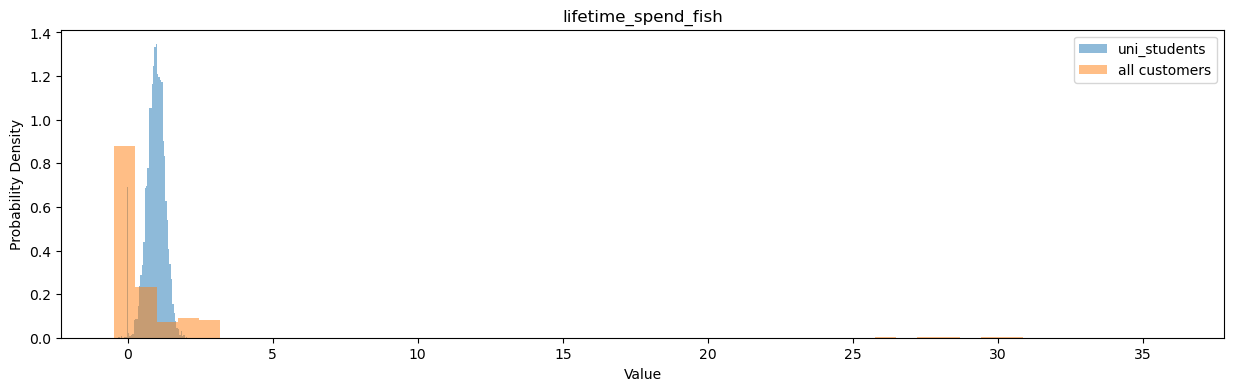

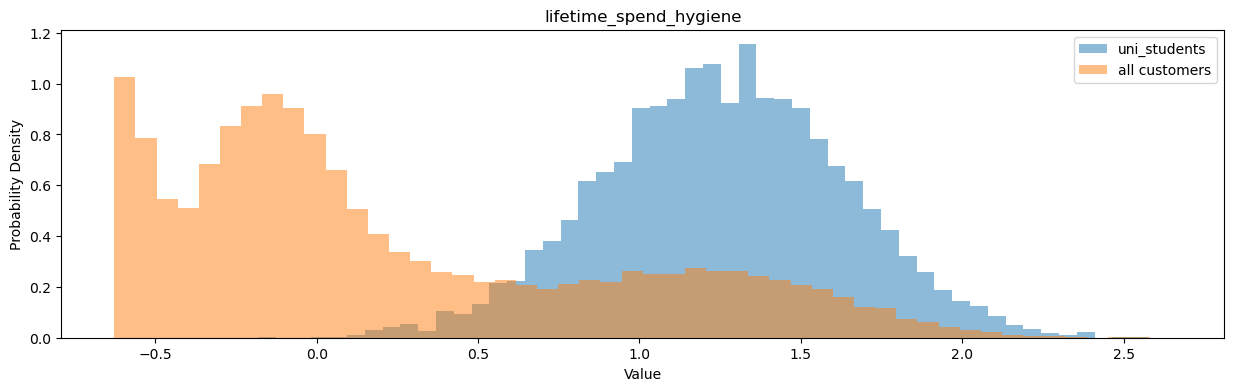

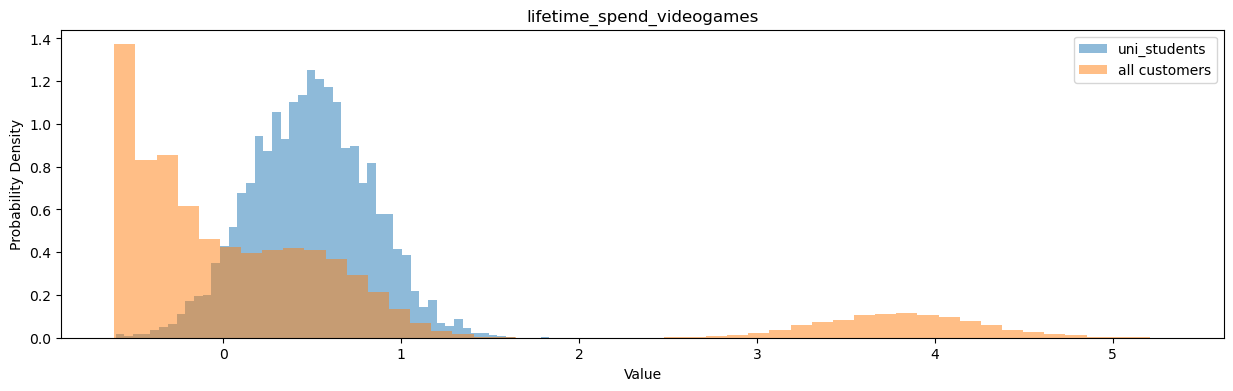

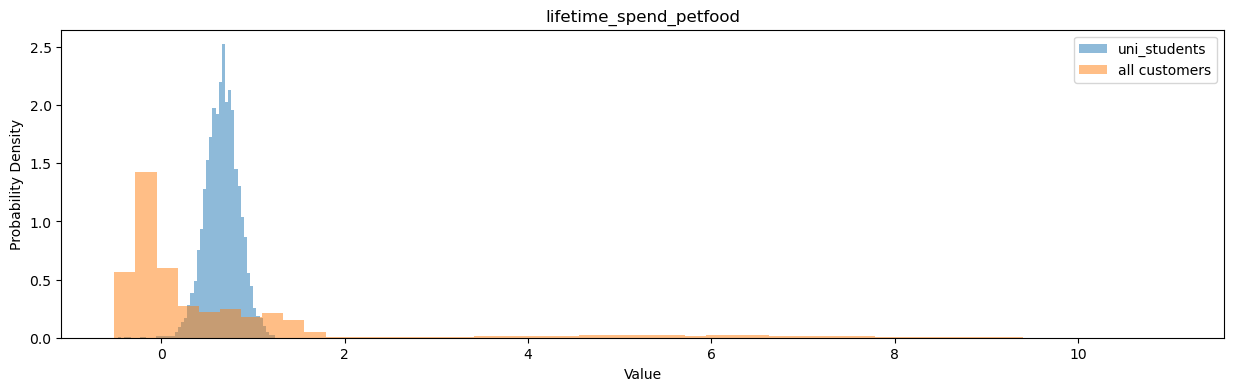

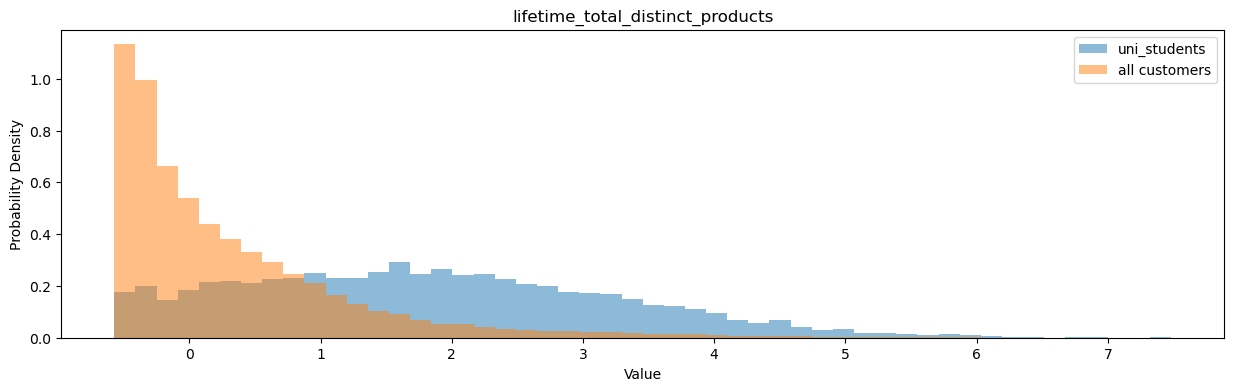

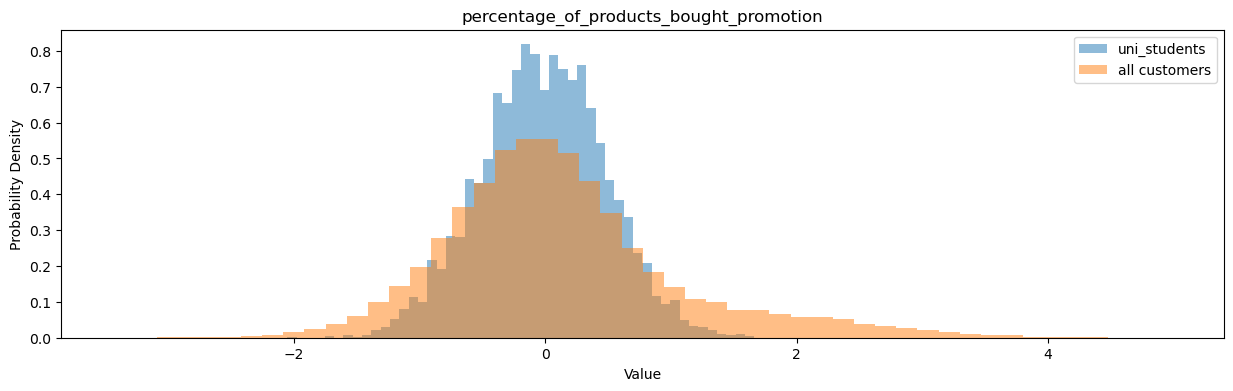

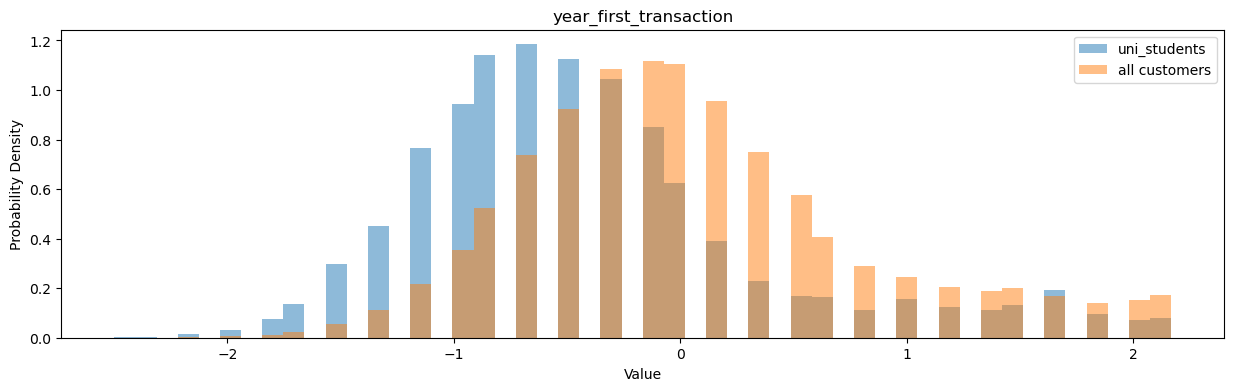

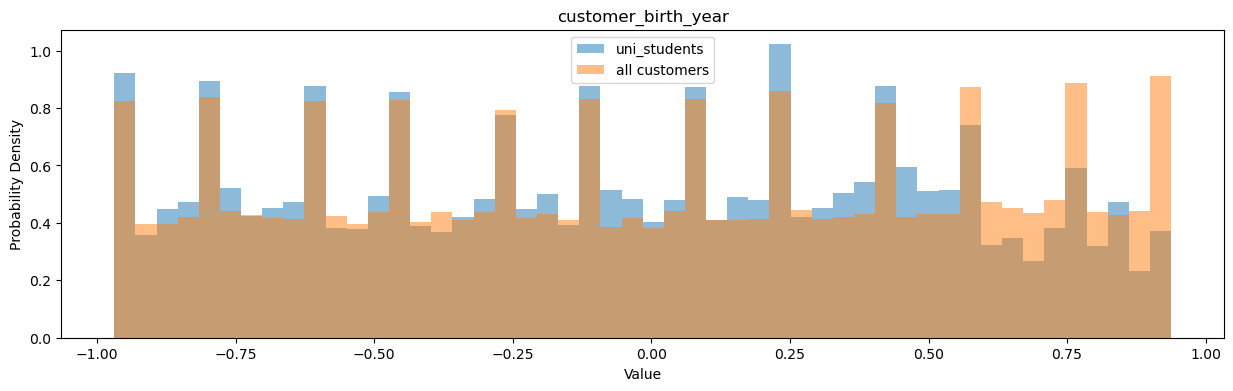

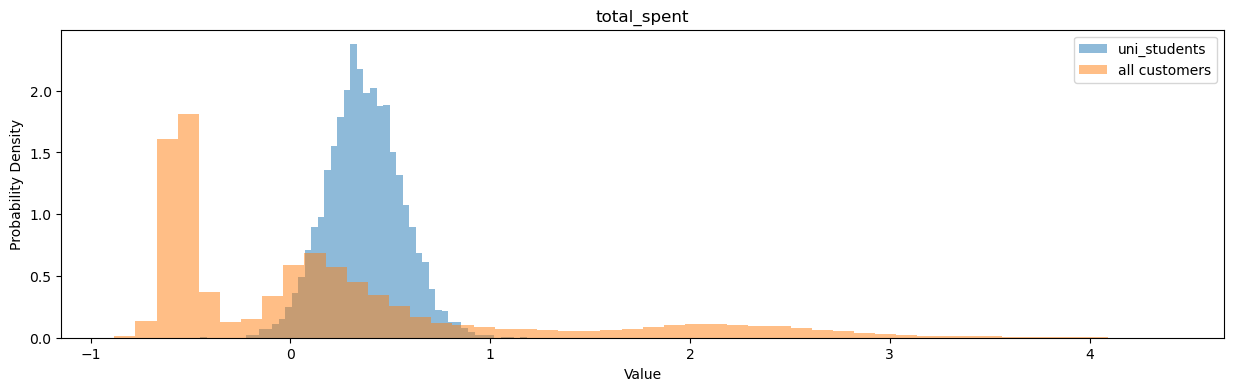

In [52]:
comparing_datasets_visualization(robust_scaller1.iloc[:, :20], business_behaviour_rb[ business_behaviour_rb['Cluster'] ==6].iloc[:, :20], 'all customers', 'uni_students')

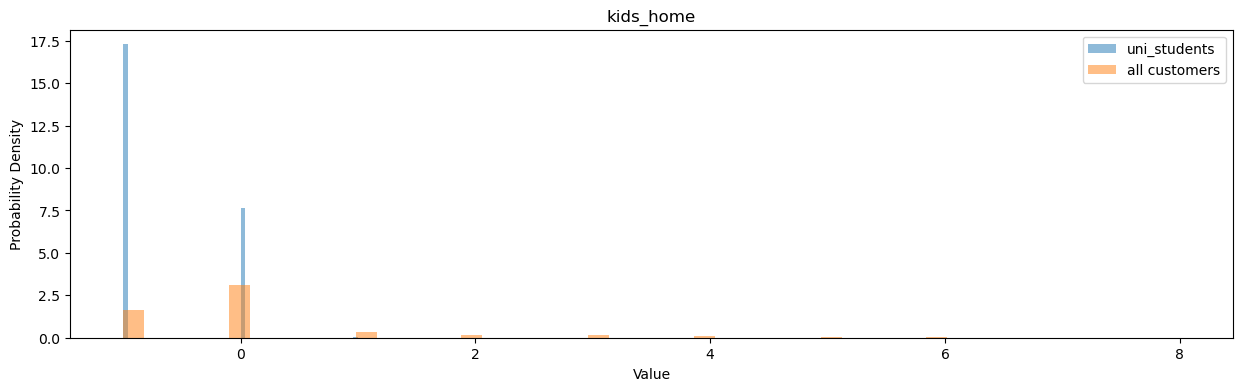

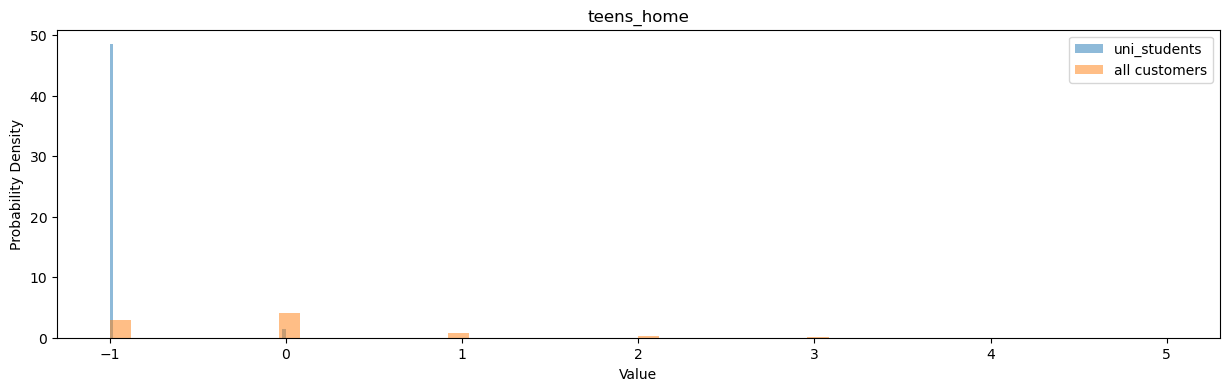

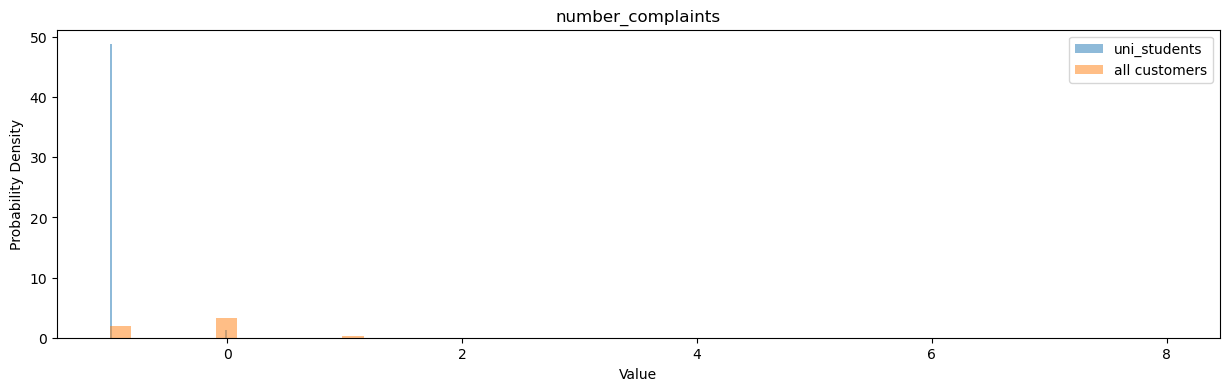

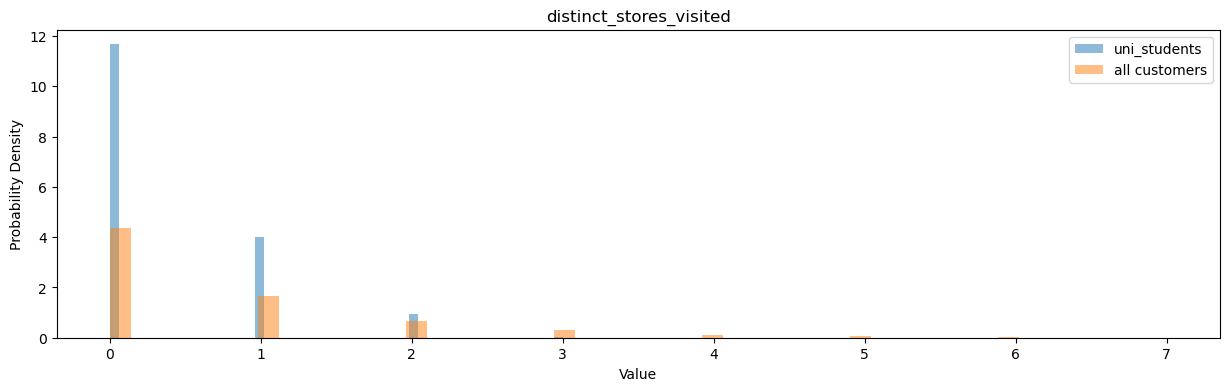

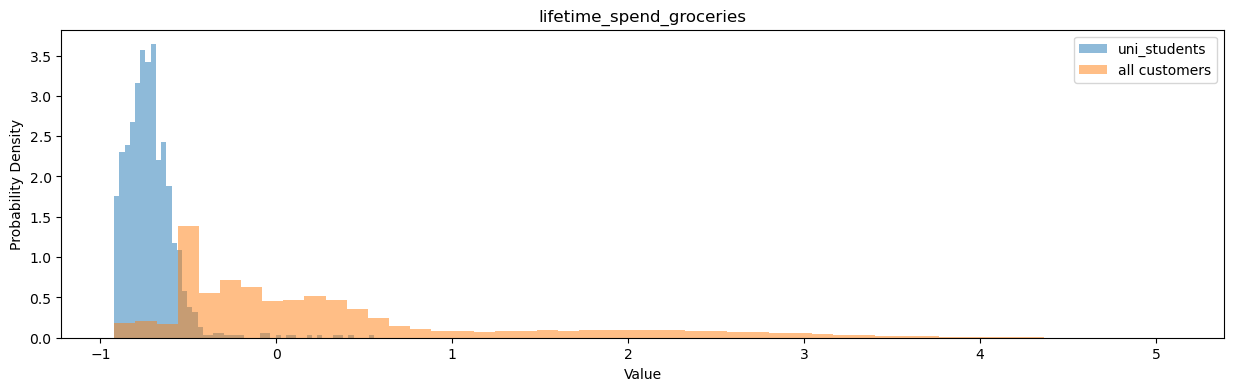

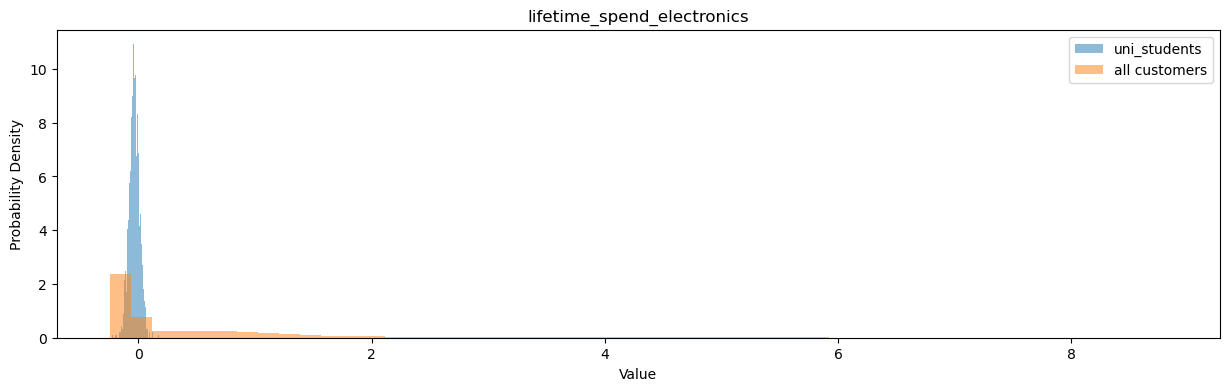

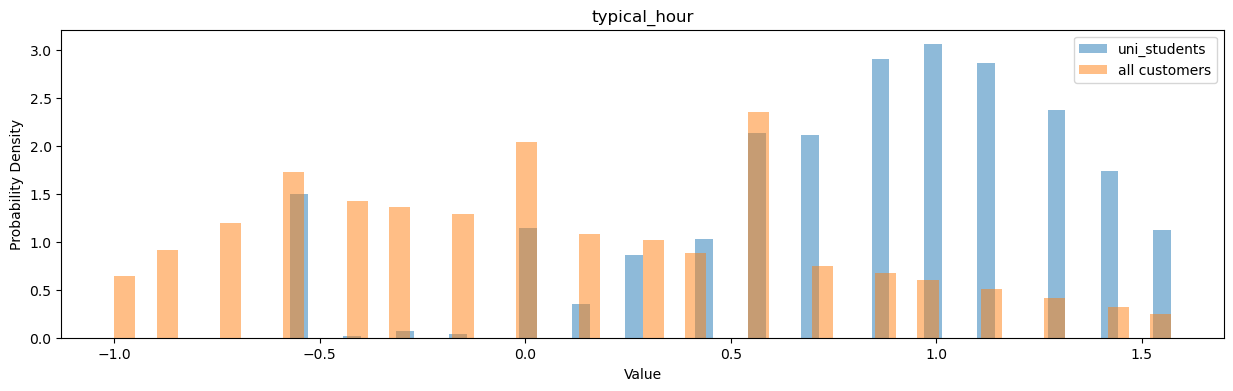

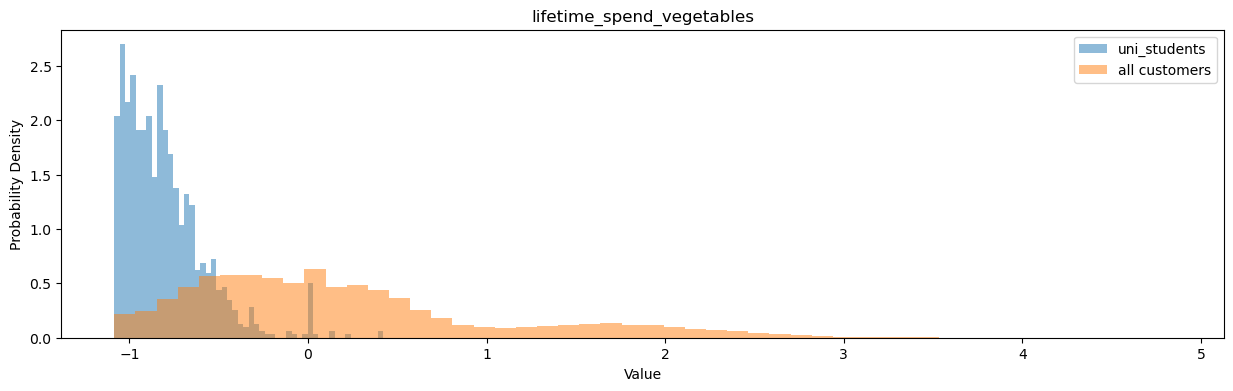

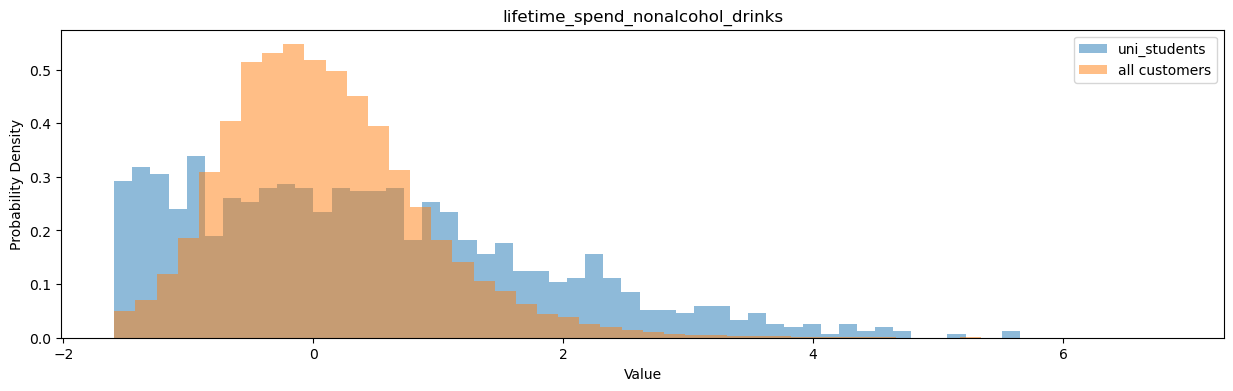

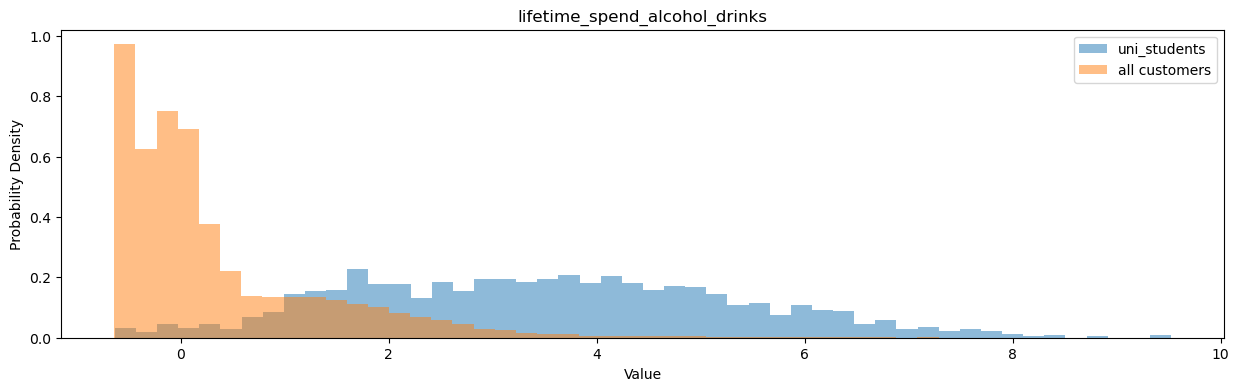

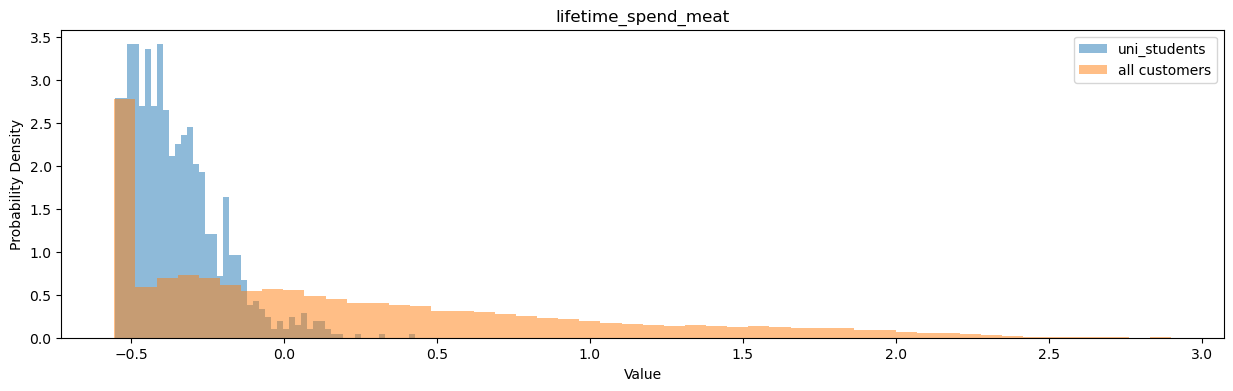

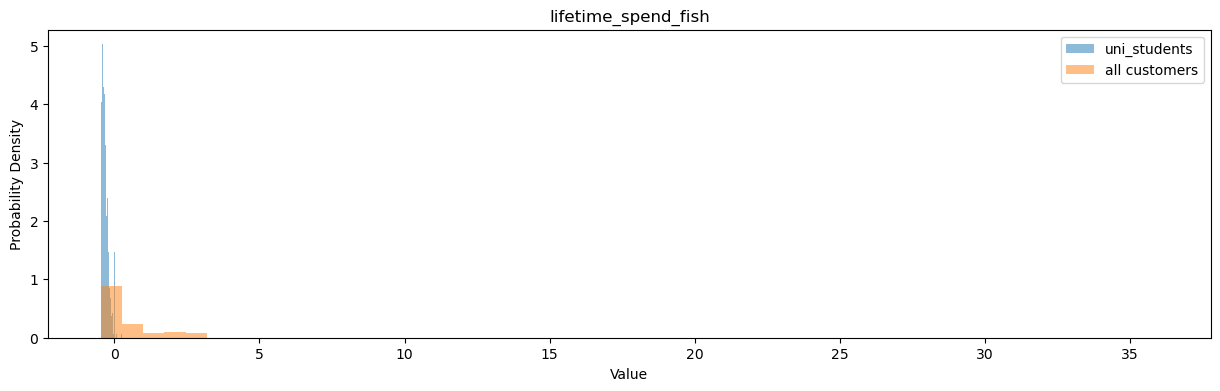

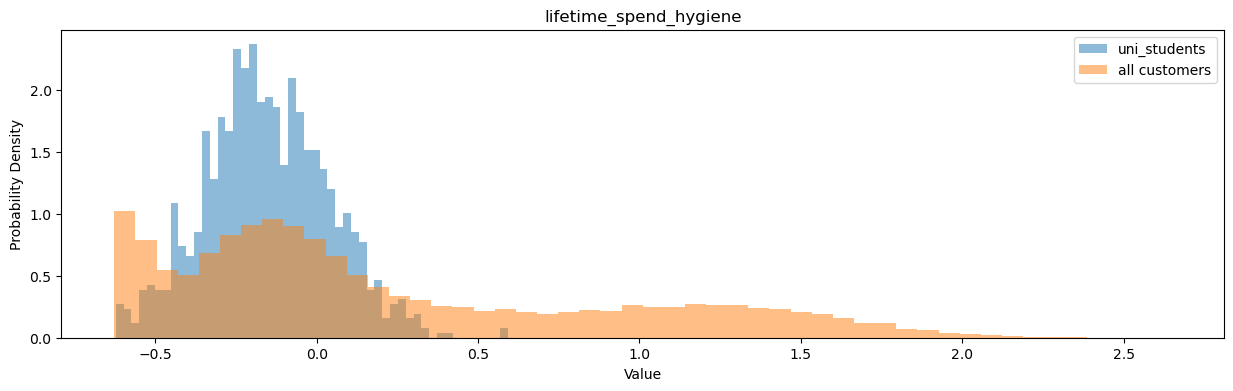

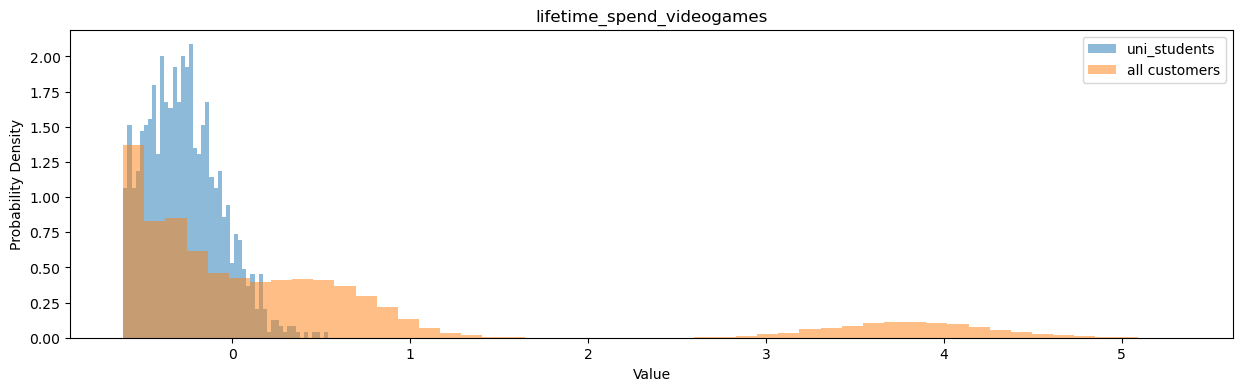

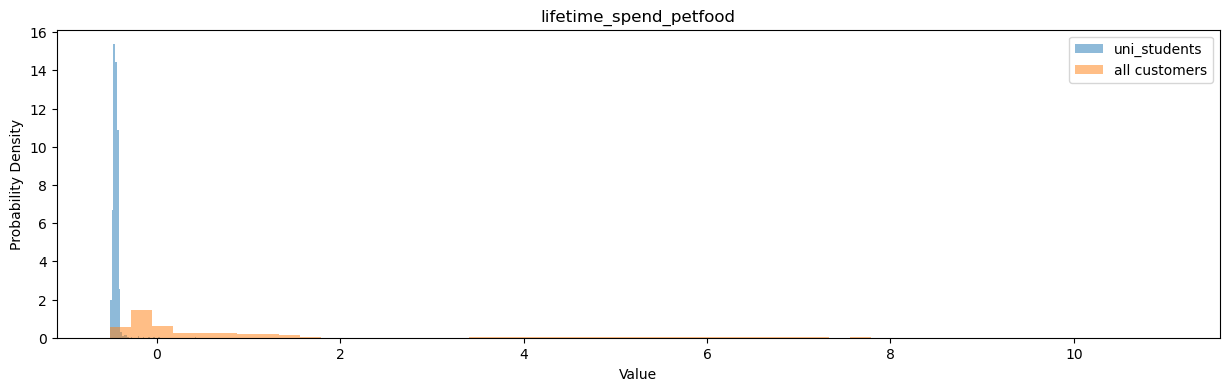

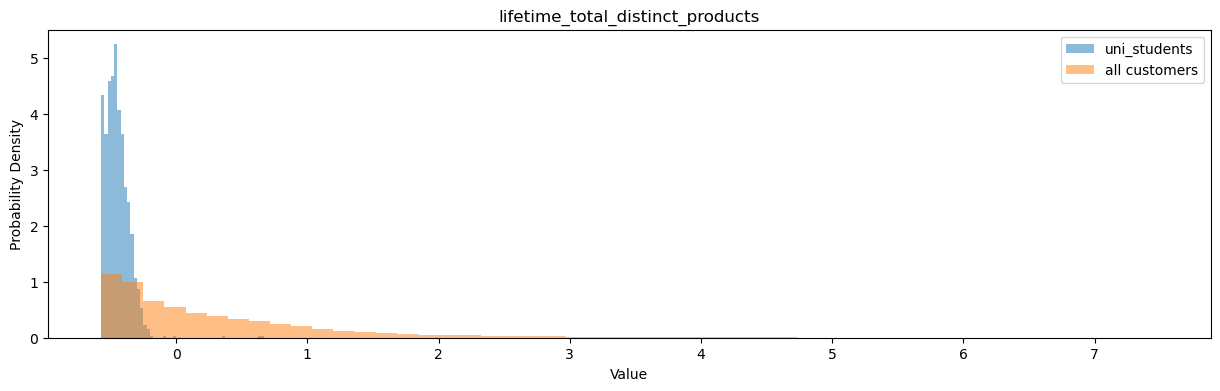

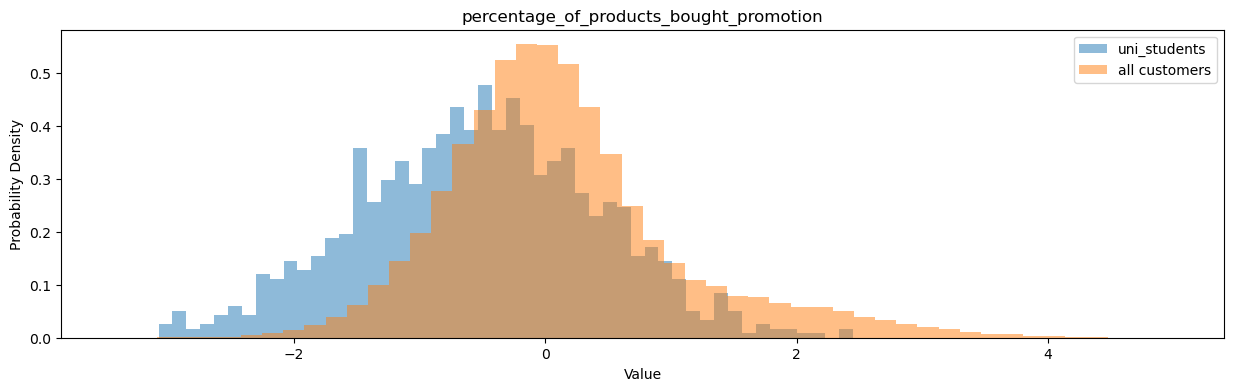

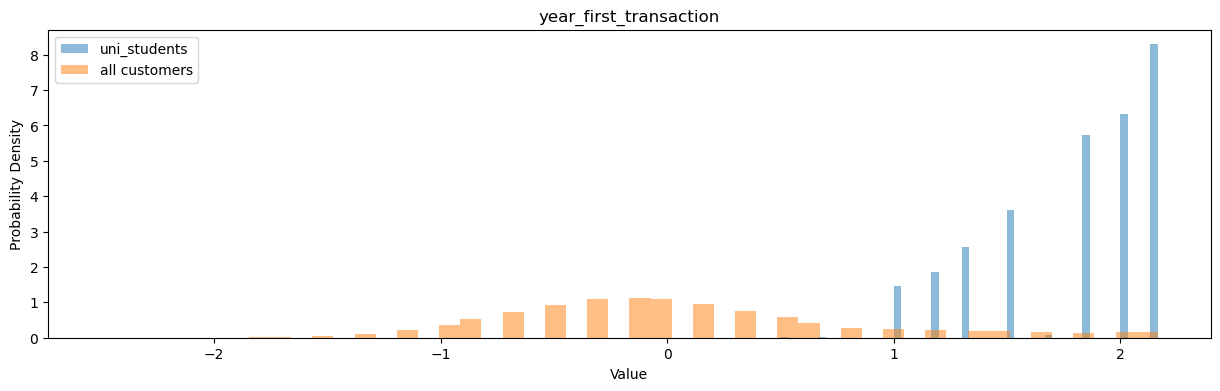

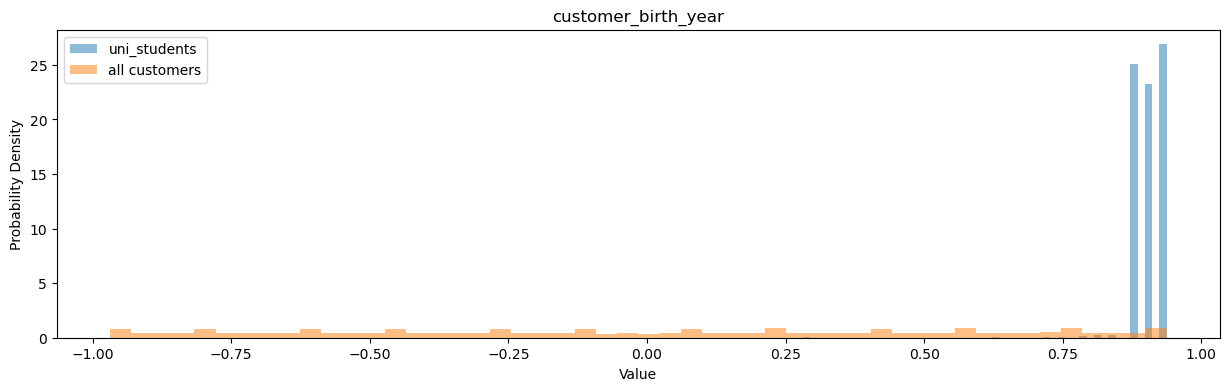

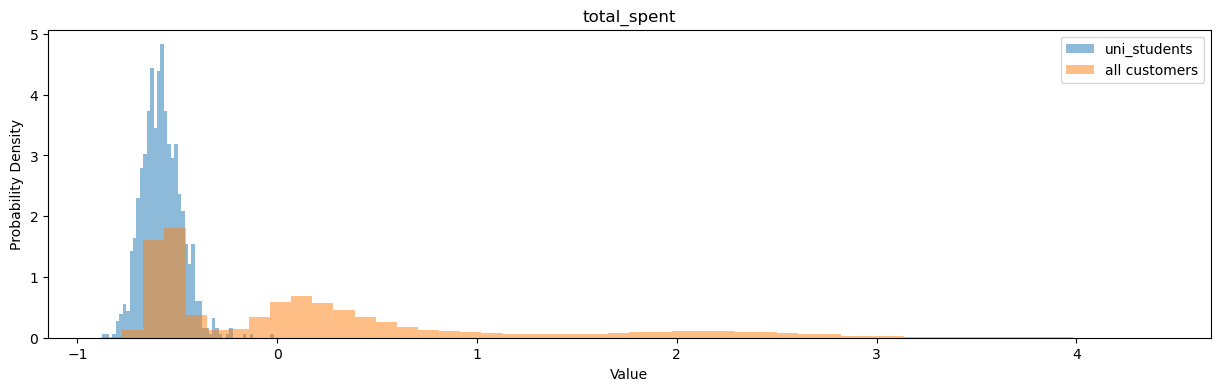

In [45]:
comparing_datasets_visualization(robust_scaller1.iloc[:, :20], business_behaviour_rb[ business_behaviour_rb['Cluster'] ==3].iloc[:, :20], 'all customers', 'uni_students')

### 9.6 Results 

Taking into consideration the confusion matrix, the histograms, and the silhouette score, we identified two clusters that can only be discovered by using both economic and behavioral variables. These clusters are:

-University Students (uni_students): This cluster consists of young clients who purchase a significant amount of alcohol and complementary products. These clients also tend to buy products late in the day.

-Early loyal birds (Swans): This cluster includes longtime custumers who visit the shop early in the day and purchase a substantial amount of distict products, mostly hygiene and groceries products. Swans are often seen as symbols of love and fidelity, that were the reasons for the name.

We chose to select the cluster with the Ward method for hierarchical clustering because, upon plotting histograms to compare different methods, we observed that their distributions were very similar. However, the decisive factor in choosing the Ward method was its superior silhouette score, which indicates better-defined and more cohesive clusters.

In [53]:
uni_students, business_behaviour_rb= remove_cluster('uni_students', business_behaviour_rb, 'Cluster', 3 )  
Swans, business_behaviour_rb= remove_cluster('Swans', business_behaviour_rb, 'Cluster', 6 )   


 ## 10. Separating the Economic and Behaviour perspective  <a class="anchor" id="sub_section_10"></a>

The next section of the notebook will focus on creating behavioral segmentation patterns of our clients. This will be followed by a segmentation analysis based on the types of products clients purchase, referred to as economic segmentation.

behaviour_rb is using robust_scaller1, that has all the clients, because we are doing a behavioral segmentation of all clients even the already removed. So later we can compare it with clusters

business_rb is using business_behaviour_rb, so we can an economic segmentation of the rest of the clients, without behaviour caracterics wheight

In [56]:
business_rb=business_behaviour_rb[['lifetime_spend_groceries','lifetime_spend_electronics','lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks','lifetime_spend_alcohol_drinks','lifetime_spend_meat',
                                 'lifetime_spend_fish','lifetime_spend_hygiene','lifetime_spend_videogames','lifetime_spend_petfood','total_spent']].copy()

behaviour_rb=robust_scaller1[['kids_home','teens_home','number_complaints','distinct_stores_visited','typical_hour','year_first_transaction','lifetime_total_distinct_products',
                            'percentage_of_products_bought_promotion','customer_birth_year']].copy()

## 11 Behaviour_rb  <a class="anchor" id="sub_section_10_1"></a>

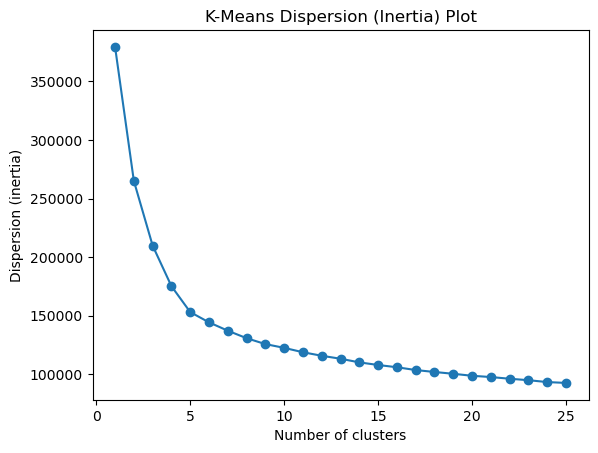

In [244]:
plot_kmeans_dispersion(behaviour_rb, max_clusters=25)

Using elbow techinique we choose 5 clusters

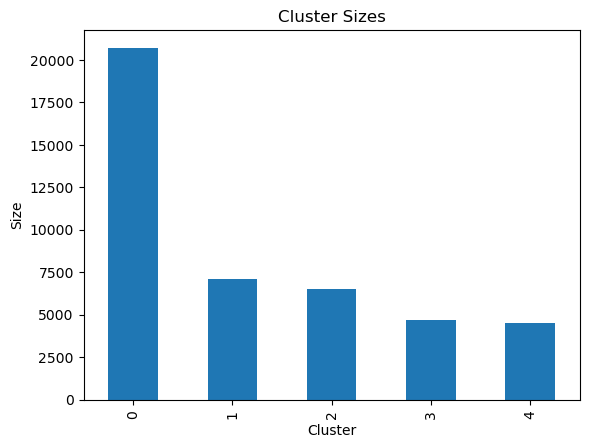

In [57]:
behaviour_rb=perform_kmeans_clustering_and_plot(behaviour_rb, n_clusters=5, random_state=0)

In [49]:
silhouette_avg = silhouette_score(behaviour_rb.drop(['cluster_kmeans'],axis=1), behaviour_rb['cluster_kmeans'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.20901205979097992


After analysing the histograms we came to the conclusion:

CLuster 0 - Base_customer (they are the normal customers)

Cluster 1- New Clients (young and recent clients) 

Cluster 2- promotion Sekkers (the ones that are always looking for promotions and even go to diferent stores if needed)

Cluster 3- Big Families (have a lot of kids and teens)

Cluster 4- Curious (buy a lot of diferent products)

In [ ]:
#cell to analyse histograms
comparing_datasets_visualization(behaviour_rb, behaviour_rb[ behaviour_rb['cluster_kmeans'] == 4], 'Behaviour dataset','Cluster kmeans')

## 12 Business_rb  <a class="anchor" id="sub_section_10_1"></a>

Using the same approach has before for the clustering Methods

### 12.1 KMeans  <a class="anchor" id="sub_section_11_2_1"></a>

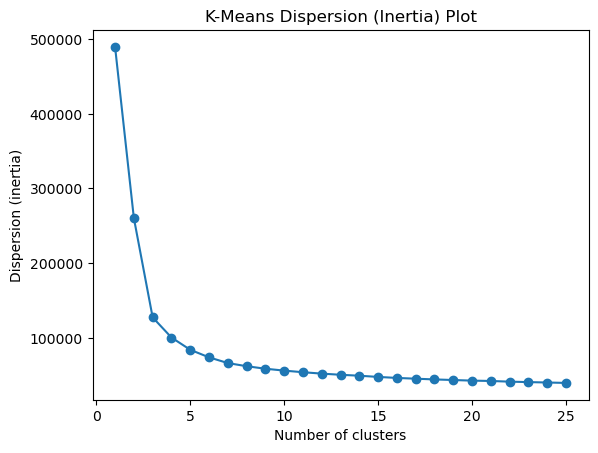

In [253]:
plot_kmeans_dispersion(business_rb, max_clusters=25)

We chose 5 clusters

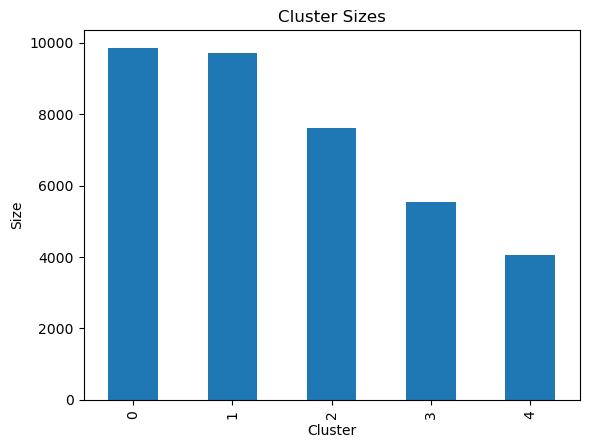

In [58]:
business_rb=perform_kmeans_clustering_and_plot(business_rb.iloc[: , :11], n_clusters=5, random_state=0)

In [51]:
silhouette_avg = silhouette_score(business_rb.drop(['cluster_kmeans'],axis=1), business_rb['cluster_kmeans'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.43940963222073803


### 11.2.2 MeanShift  <a class="anchor" id="sub_section_11_2_1"></a>

As previously, after some tries we decided to choose 1.5 for the bandwidth and group the cluster with less then 500 clients to a single one

In [59]:
ms= MeanShift(bandwidth = 1.5, n_jobs=-1, bin_seeding=True)
business_rb['Mean_shift']=ms.fit_predict(business_rb.iloc[: , :11])

In [60]:
cluster_counts = business_rb['Mean_shift'].value_counts()

# Identify clusters with fewer than 500 clients
small_clusters = cluster_counts[cluster_counts < 500].index.tolist()

# Reassign points from small clusters to a new cluster label
business_rb.loc[business_rb['Mean_shift'].isin(small_clusters), 'Mean_shift'] = 111

In [54]:
business_rb['Mean_shift'].value_counts().head(15)

0      9815
1      9789
2      7572
3      4058
4      3968
111    1579
Name: Mean_shift, dtype: int64

In [55]:
silhouette_avg = silhouette_score(business_rb.iloc[: , :11], business_rb['Mean_shift'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.38637333244670313


### 11.2.3 Hierarchical clustering  <a class="anchor" id="sub_section_11_2_3"></a>

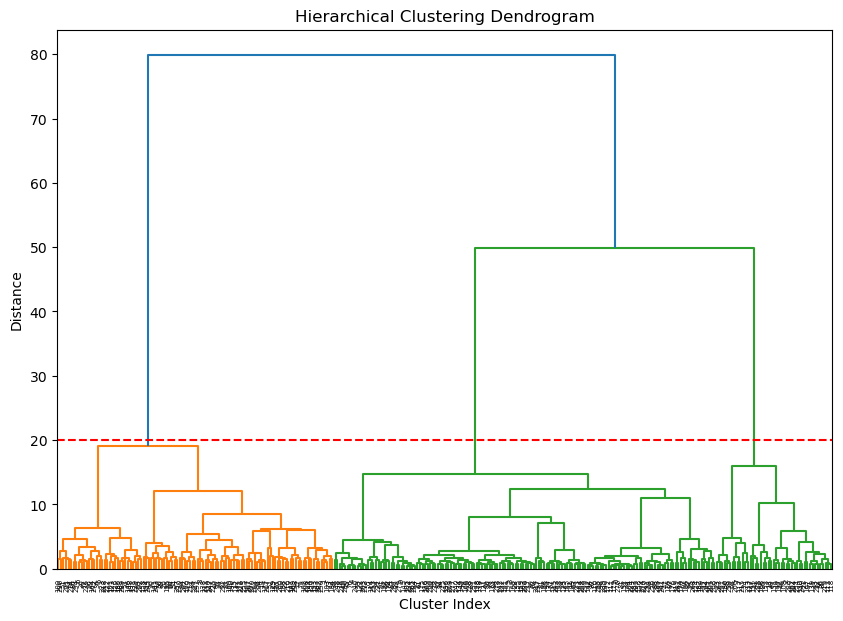

In [61]:
centroid=create_centroid_dataset(business_rb.iloc[: , :11])
business_rb1=perform_hierarchical_clustering_and_label_data(centroid, business_rb.iloc[: , :11],y_line=20)

In [62]:
business_rb=business_rb.merge(business_rb1['Cluster'], left_index=True, right_index=True)
business_rb['Cluster'].value_counts()

2    26986
1     5547
3     4248
Name: Cluster, dtype: int64

In [58]:
silhouette_avg = silhouette_score(business_rb.iloc[: , :11], business_rb['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.6245002955713824


 ### 11.2.4 Comparing clustering  <a class="anchor" id="sub_section_11_2_4"></a>

In [59]:
pd.DataFrame(
    confusion_matrix(business_rb['cluster_kmeans'], business_rb['Cluster']),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,5)],
    columns = ['Hierarchical {} Cluster'.format(i) for i in np.arange(0,5)],
)

Hierarchical 0 Cluster  Hierarchical 1 Cluster  \
K-means 0 Cluster                       0                       0   
K-means 1 Cluster                       0                       0   
K-means 2 Cluster                       0                       0   
K-means 3 Cluster                       0                    5547   
K-means 4 Cluster                       0                       0   

                   Hierarchical 2 Cluster  Hierarchical 3 Cluster  \
K-means 0 Cluster                    9723                     133   
K-means 1 Cluster                    9641                      60   
K-means 2 Cluster                    7622                       0   
K-means 3 Cluster                       0                       0   
K-means 4 Cluster                       0                    4055   

                   Hierarchical 4 Cluster  
K-means 0 Cluster                       0  
K-means 1 Cluster                       0  
K-means 2 Cluster                       0  
K-means 3 Cluster                       0  
K-means 4 Cluster                       0

In [61]:
pd.DataFrame(
    confusion_matrix(business_rb['Mean_shift'], business_rb['Cluster']),
    index = ['Mean_shift {} Cluster'.format(i) for i in np.arange(0,6)],
    columns = ['Hierarchical {} Cluster'.format(i) for i in np.arange(0,6)],
)

Hierarchical 0 Cluster  Hierarchical 1 Cluster  \
Mean_shift 0 Cluster                       0                       0   
Mean_shift 1 Cluster                       0                       0   
Mean_shift 2 Cluster                       0                       0   
Mean_shift 3 Cluster                       0                       0   
Mean_shift 4 Cluster                       0                    3968   
Mean_shift 5 Cluster                       0                    1579   

                      Hierarchical 2 Cluster  Hierarchical 3 Cluster  \
Mean_shift 0 Cluster                    9687                     128   
Mean_shift 1 Cluster                    9727                      62   
Mean_shift 2 Cluster                    7572                       0   
Mean_shift 3 Cluster                       0                    4058   
Mean_shift 4 Cluster                       0                       0   
Mean_shift 5 Cluster                       0                       0   

                      Hierarchical 4 Cluster  Hierarchical 5 Cluster  
Mean_shift 0 Cluster                       0                       0  
Mean_shift 1 Cluster                       0                       0  
Mean_shift 2 Cluster                       0                       0  
Mean_shift 3 Cluster                       0                       0  
Mean_shift 4 Cluster                       0                       0  
Mean_shift 5 Cluster                       0                       0

 ### 11.2.5 Visualization  <a class="anchor" id="sub_section_11_2_4"></a>

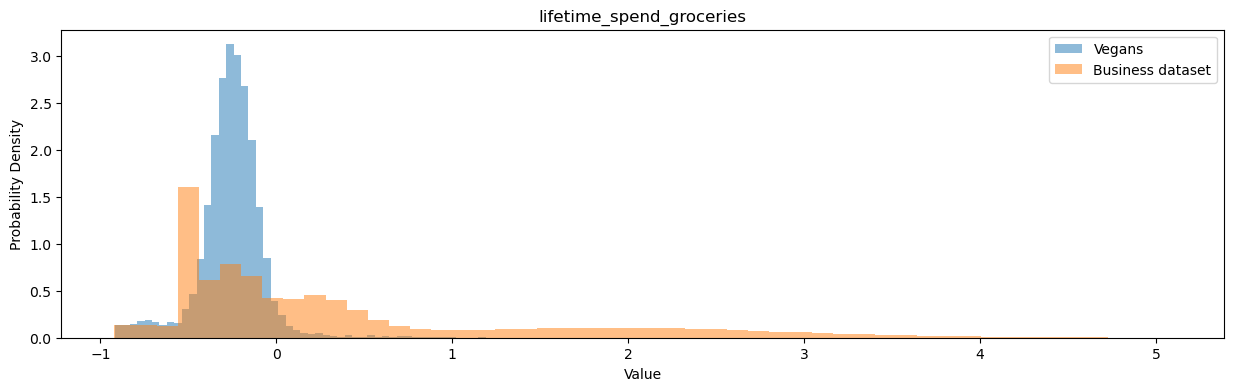

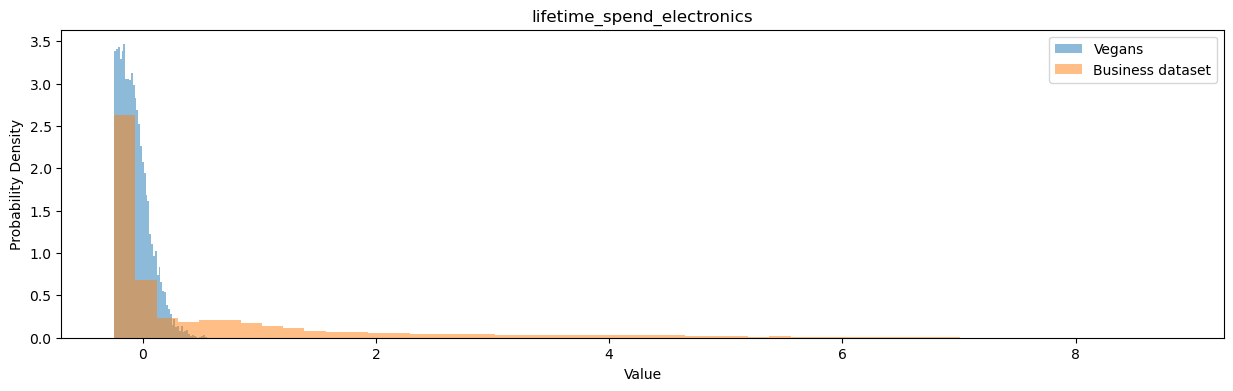

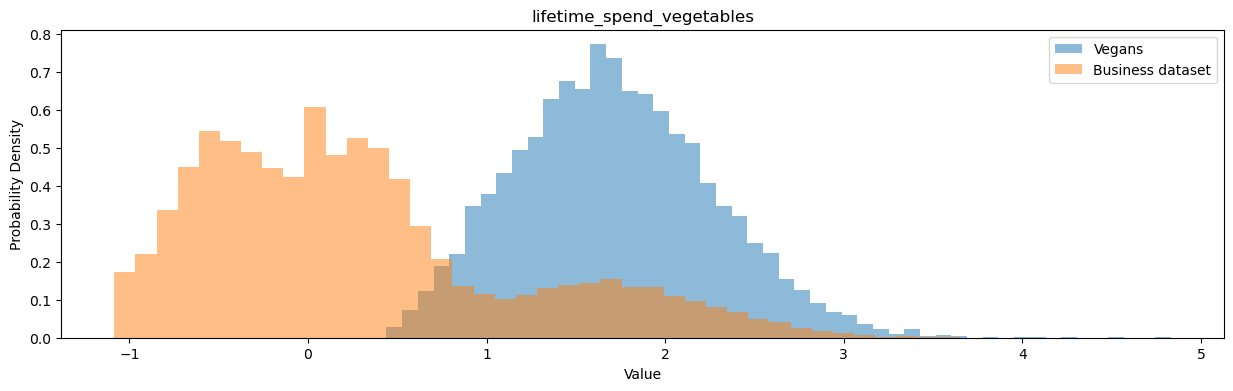

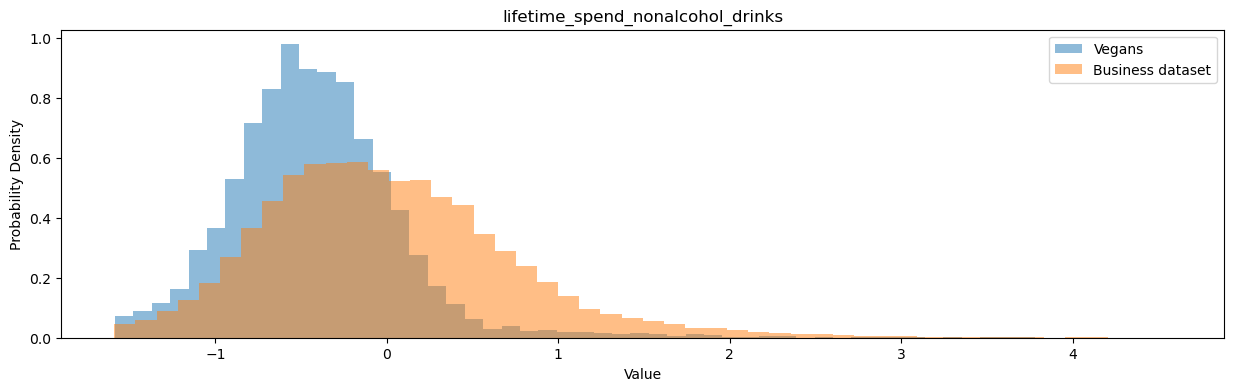

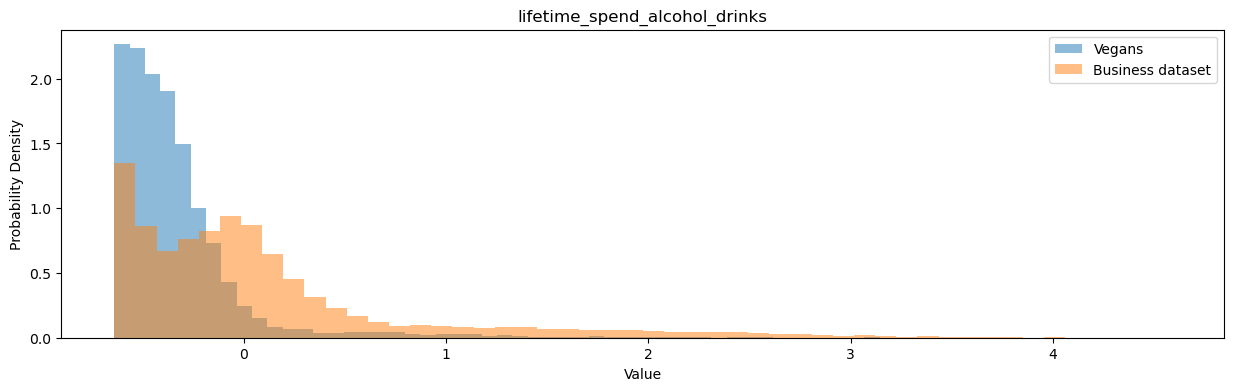

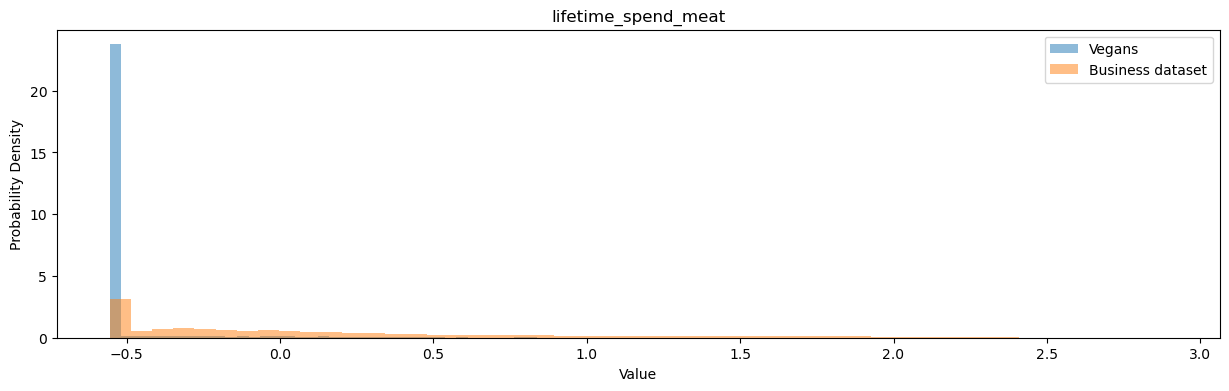

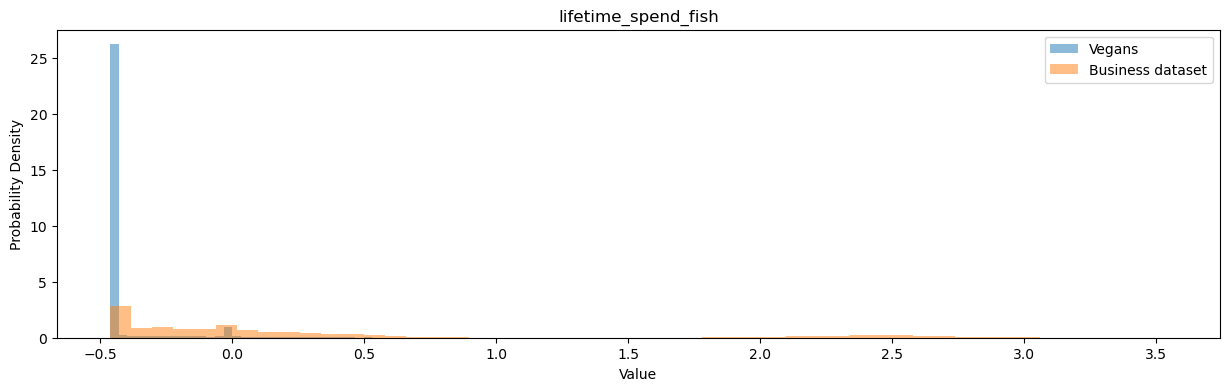

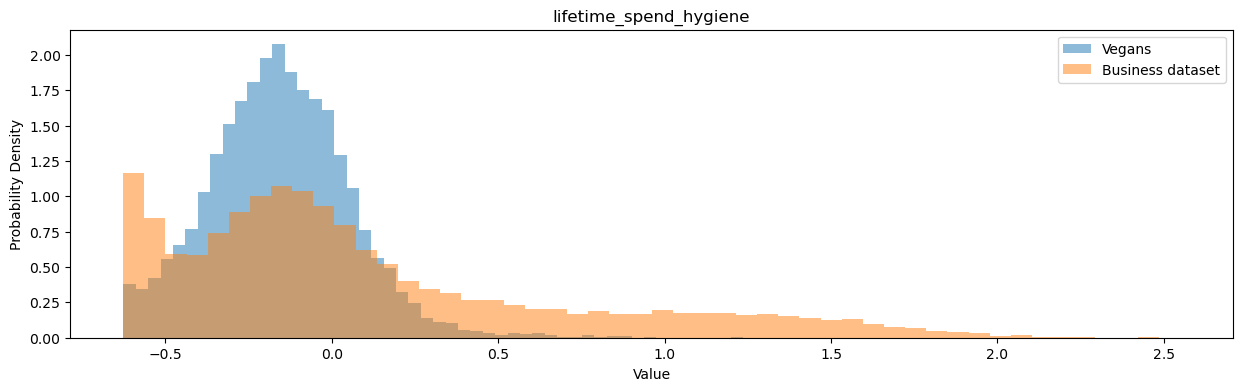

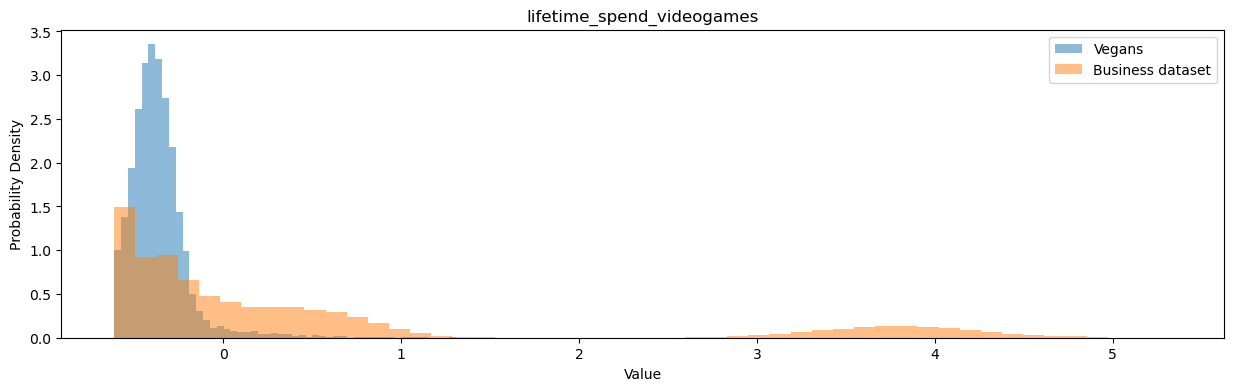

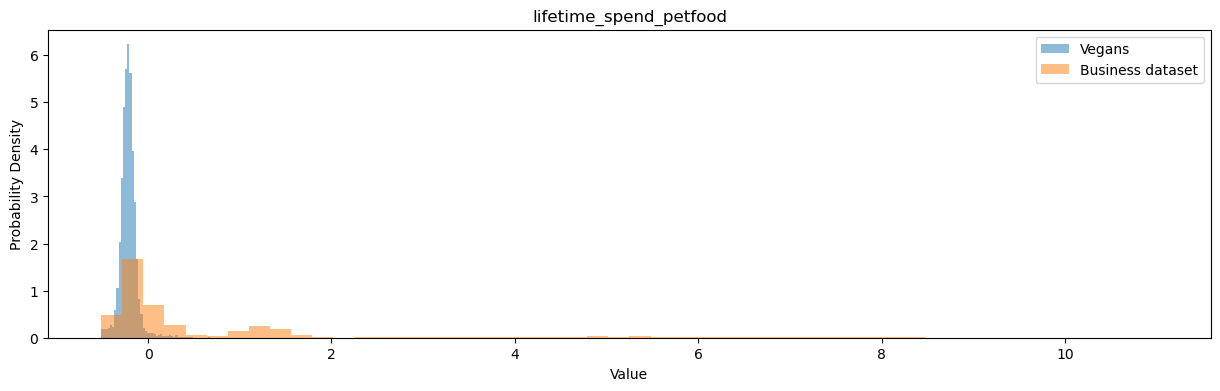

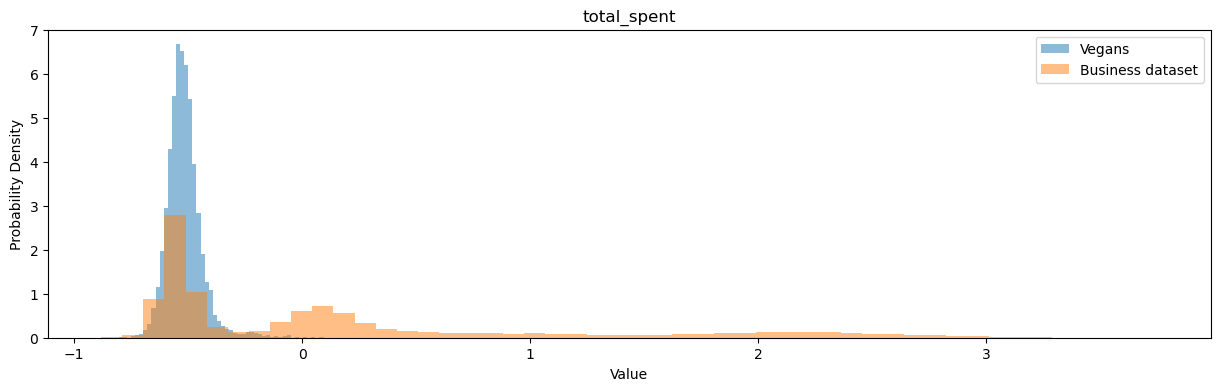

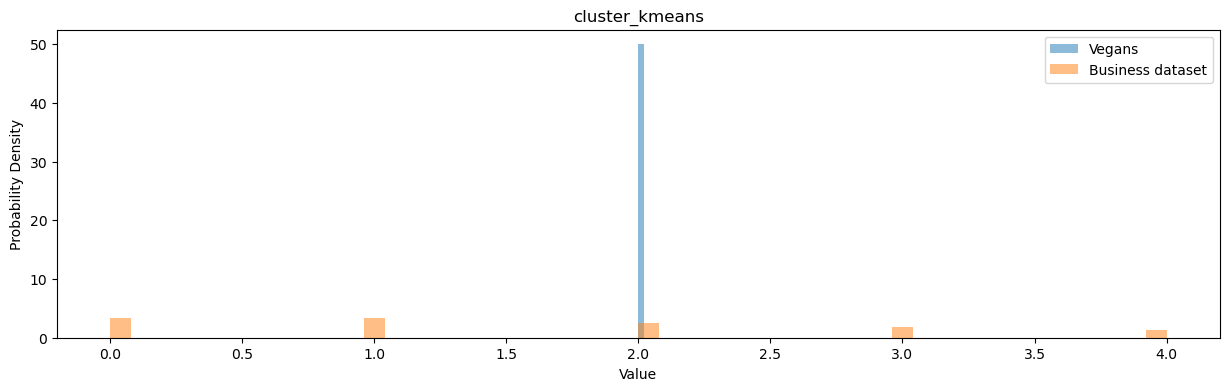

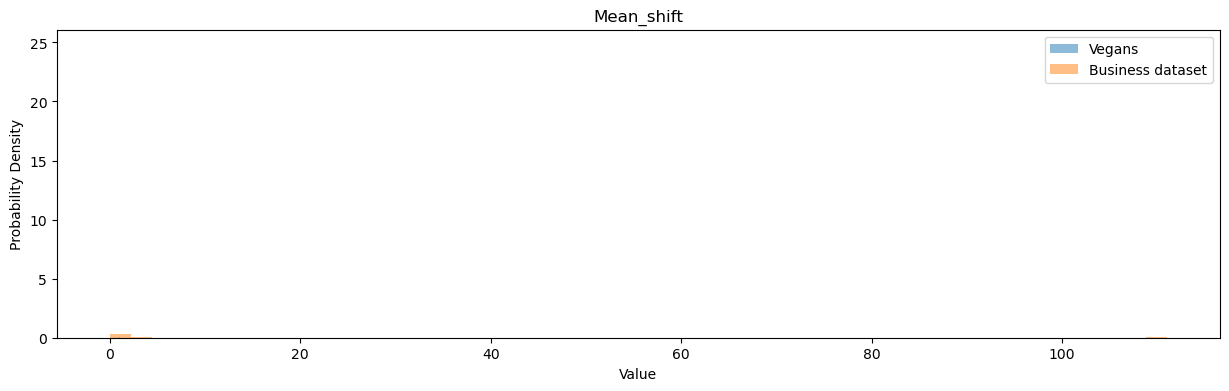

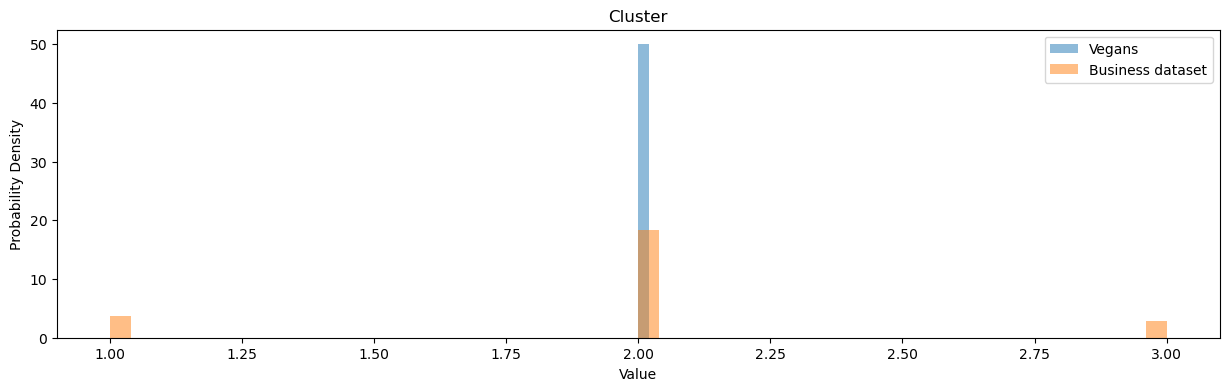

In [63]:
comparing_datasets_visualization(business_rb, business_rb[ business_rb['cluster_kmeans'] == 2], 'Business dataset', 'Vegans')

In [ ]:
comparing_datasets_visualization(business_rb, business_rb[ business_rb['cluster_kmeans'] == 0], 'Business dataset', 'low_budget')

In [ ]:
comparing_datasets_visualization(business_rb, business_rb[ business_rb['cluster_kmeans'] == 1], 'Business dataset', 'normal_customers')

In [ ]:
comparing_datasets_visualization(business_rb, business_rb[ business_rb['Cluster'] == 1], 'Business dataset', 'best_customers')

In [ ]:
comparing_datasets_visualization(business_rb, business_rb[ business_rb['Cluster'] == 3], 'Business dataset', 'pet_lovers')

### 11.2.5 Results  <a class="anchor" id="sub_section_11_2_5"></a>

After careful consideration and numerous attempts, we finalized these clusters. Despite the good silhouette score of the ward clustering, we decided to separate it into three distinct clusters. This decision was based on the clear differences observed in the histograms, indicating distinct segments.

In [63]:
pet_lovers , business_rb= remove_cluster('pet_lovers', business_rb, 'Cluster', 3 )
best_customers, business_rb= remove_cluster('best_customers', business_rb, 'Cluster', 1 )

vegan , business_rb= remove_cluster('vegan', business_rb, 'cluster_kmeans', 2 )
low_budget , business_rb= remove_cluster('low_budget', business_rb, 'cluster_kmeans', 0 )
normal_customers , business_rb= remove_cluster('normal_customers', business_rb, 'cluster_kmeans', 1 )






## 12 Merging Datasets  <a class="anchor" id="sub_section_12"></a>

To merge the datasets efectively, we created 2 fuctions:

merge_clusters- merges all the clusters of the same clusteing method

combine_clusters- merges 2 clustering methods together





In [64]:
#Merging all ward clusters
ward_dataset=merge_clusters(robust_scaller1 , [uni_students, Swans, best_customers, pet_lovers ],'Cluster' )

In [65]:
#merging all KMeans clusters
kmeans_dataset= merge_clusters( robust_scaller1 , [ vegan, karren,  low_budget, normal_customers ],'cluster_kmeans' )

In [66]:
#Combining the KMeans and ward Clusters
clustered_customer_info_rb1=combine_clusters(kmeans_dataset, ward_dataset, 'cluster_kmeans','Cluster' )

#Merging the KMeans and ward Clusters with the fishies (cluster_thresholding)
clustered_customer_info_rb1['Cluster_combined']=clustered_customer_info_rb1['cluster_combined']  
clustered_customer_info_rb=combine_clusters(clustered_customer_info_rb1, fishies, 'Cluster_combined','cluster_thresholding' )


### 12.1 Finding the cluster of the other missing values  <a class="anchor" id="sub_section_12_1"></a>

We decided on using an approach of assigning non-clustered customers (outliers) to the nearest cluster based on Euclidean distances to cluster means. This approach has offers several benefits incluiding consistency and simplicity.

In [67]:
not_clustered_customer_info_rb=all_outliers.drop(['cluster_kmeans'],axis=1).copy()

In [68]:
# Compute the mean values for each cluster
cluster_means = clustered_customer_info_rb.groupby('cluster_combined').mean()

# Extract feature columns (assuming 'cluster' is the last column in clustered_df)
feature_columns = clustered_customer_info_rb.columns[:-1]

# Initialize a DataFrame to store the cluster assignments for not clustered customers
not_clustered_customer_info_rb['cluster_combined'] = None

# Calculate the distance for each non-clustered customer to each cluster mean
for idx, customer in not_clustered_customer_info_rb.iterrows():
    customer_features = customer[feature_columns].values.reshape(1, -1)
    distances = euclidean_distances(customer_features, cluster_means[feature_columns])
    assigned_cluster = cluster_means.index[distances.argmin()]
    not_clustered_customer_info_rb.at[idx, 'cluster_combined'] = assigned_cluster


In [69]:
#adding the 2 datasets together, to have finally all costumers in clusters
robust_scaller1 =pd.concat([not_clustered_customer_info_rb, clustered_customer_info_rb])  #this dataset only contains economic and behaviour variables
customer_info_rb=customer_info_rb.merge(robust_scaller1['cluster_combined'], left_index=True, right_index=True)   #contains all numeric variables

In [72]:
robust_scaller1['cluster_combined'].value_counts()

cluster_low_budget          9776
cluster_normal_customers    9695
cluster_vegan               7695
cluster_best_customers      5642
cluster_Swans               5006
cluster_pet_lovers          4248
cluster_uni_students        1073
fishies                      379
cluster_karren               117
Name: cluster_combined, dtype: int64

## 13 UMAP  <a class="anchor" id="sub_section_12_1"></a>

Plotting the UMAP of two distinct approaches: business-only and business with behavior

In [73]:
X_sample1 = robust_scaller1[['lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables',
                             'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 'lifetime_spend_meat',
                             'lifetime_spend_fish', 'lifetime_spend_hygiene', 'lifetime_spend_videogames',
                             'lifetime_spend_petfood', 'total_spent']]  #business-only approach

X_sample2=robust_scaller1.iloc[:,:-1]     #business with behavior

y_sample= robust_scaller1.iloc[:,-1]



In [74]:
umap_object = umap.UMAP(n_neighbors=200, random_state=42)
umap_embedding1 = umap_object.fit_transform(X_sample1)
umap_embedding2 = umap_object.fit_transform(X_sample2)

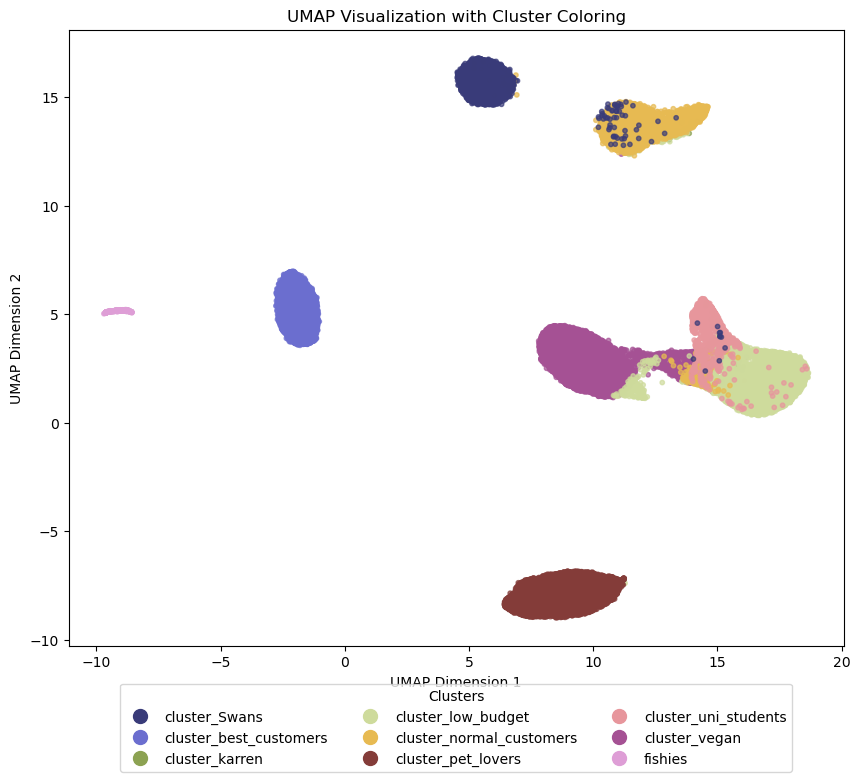

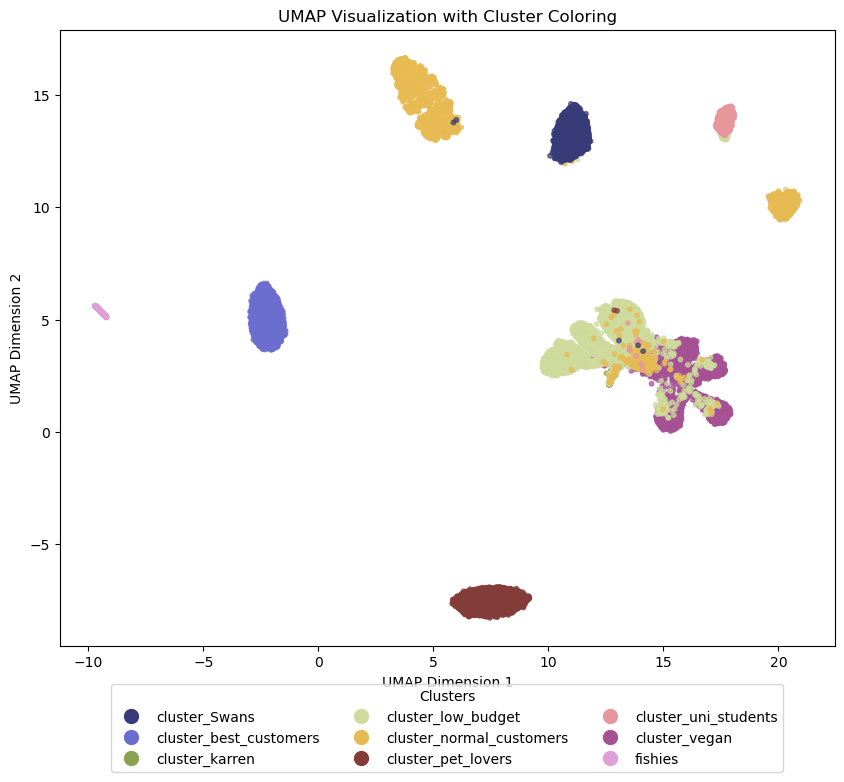

In [75]:
visualize_dimensionality_reduction(umap_embedding1, y_sample)
visualize_dimensionality_reduction(umap_embedding2, y_sample)

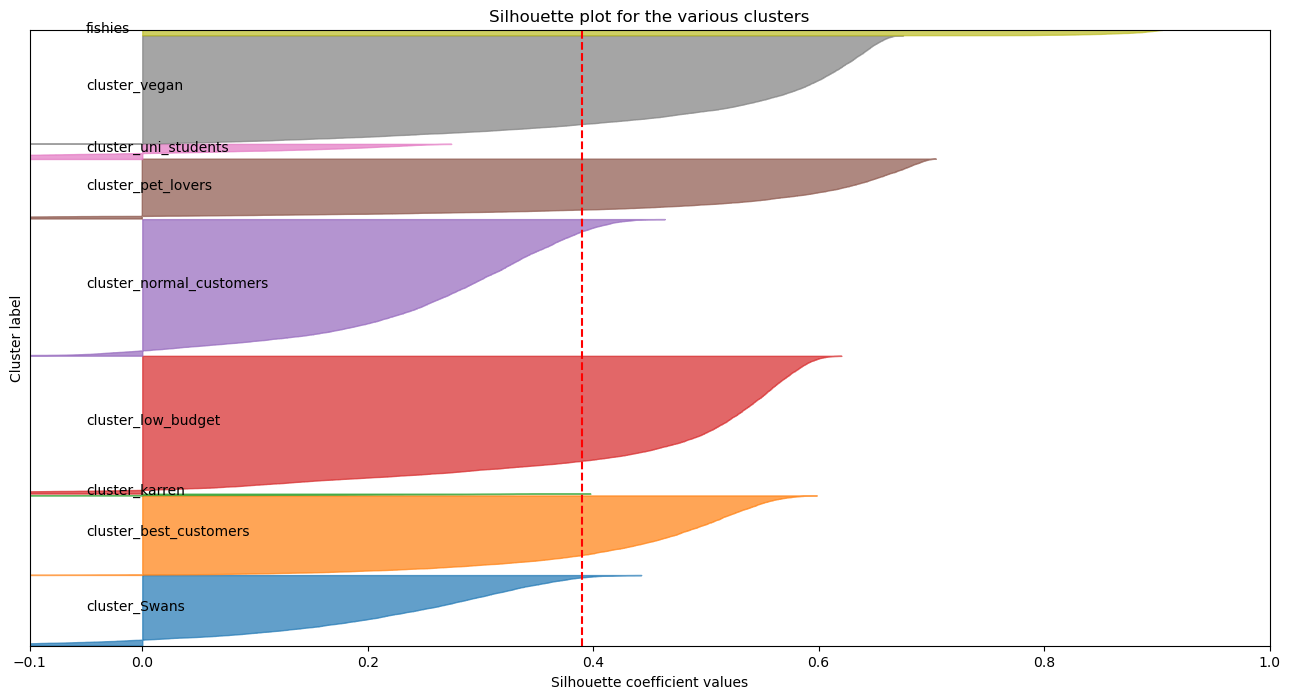

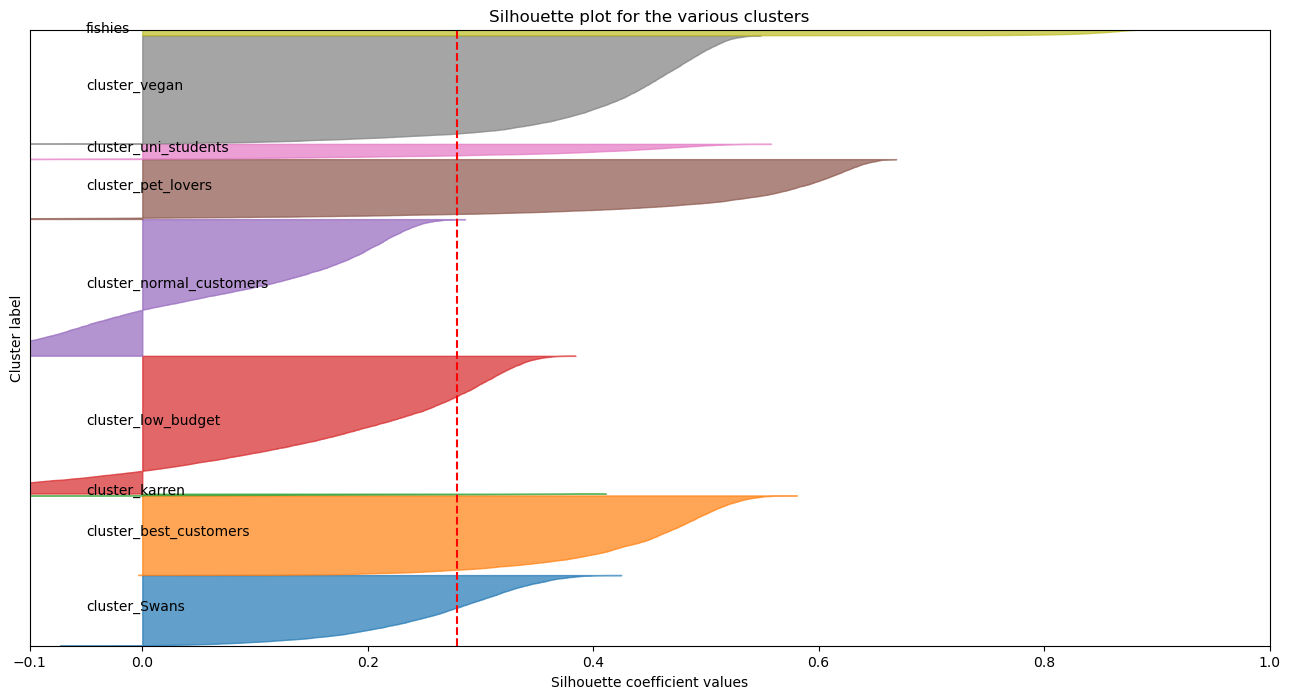

In [76]:
plot_silhouette(robust_scaller1, X_sample1.columns, 'cluster_combined') #economic only
plot_silhouette(robust_scaller1, X_sample2.columns, 'cluster_combined') #economic with behaviour

As we can see we have different types of clusters:

-*very strong* like pet_lovers, best_customers, fishies. They don't change based on the approach

-*Almost Perfect* like cluster Swans, that in the business seems to have some noise inside but in the other approach becames a strong cluster

-*One sided clusters* like uni_students that only in the behaviour with economic approach they from a separated cluster

-*noisy cluster* like normal_customers that in the business aproach appears to be a almost perfect cluster, altough it has some noise. Diferent to the business with behaviour approach, because in this it 'eats' another cluster and is more present in the messy cluster. 

-*messy cluster* like vegan and low_budget, altough when comparing the histograms they contain diferences when presented in the umap, they merge together. We decided to keep it this way, because as previously said they reprenset diferent behaviours

-*almost invisible* like karren, they don't form a cluster but they represent a behaviour

## 14 Analysing the clusters with behaviour profile  <a class="anchor" id="sub_section_12_1"></a>

In this segment we try to understand a little more about the behaviour of the customers as in a group. So we will do a confussion matrix of our cluster and the customers profiles 

In [77]:
# Create a mapping from string labels to integers for true labels
unique_labels = customer_info_rb['cluster_combined'].unique()
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Map the true labels to integers
true_labels = customer_info_rb['cluster_combined'].map(label_mapping)

# Ensure predicted labels are integers (assuming they are already in the correct range)
predicted_labels = behaviour_rb['cluster_kmeans']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Ensure the confusion matrix is 9x5 by slicing or adjusting as necessary
if cm.shape[0] > 9:
    cm = cm[:9, :]
if cm.shape[1] > 5:
    cm = cm[:, :5]

# Create a DataFrame with formatted index and column labels
cm_df = pd.DataFrame(
    cm,
    index=['{} '.format(i) for i in unique_labels[:9]],  # Assuming the first 9 unique labels
    columns=['{} '.format(i) for i in ['regular', 'new_clients', 'promotions', 'Big_family', 'distinct products']]
)

# Transpose the DataFrame to invert the matrix (make columns be index and index be columns)
cm_df_inverted = cm_df.transpose()

# Display the inverted confusion matrix DataFrame
print(cm_df_inverted)

                    cluster_best_customers   cluster_Swans   \
regular                                4892            1208   
new_clients                             718             262   
promotions                               32             181   
Big_family                                0               4   
distinct products                         0            3351   

                    cluster_pet_lovers   cluster_uni_students   \
regular                            3446                      6   
new_clients                         802                   1063   
promotions                            0                      2   
Big_family                            0                      0   
distinct products                     0                      2   

                    cluster_low_budget   cluster_normal_customers   \
regular                            2660                       1961   
new_clients                         762                       2243   
promotions    

Best Customers: Typically regular customers, but there are 718 young clients within this group. This subcluster is particularly interesting and should be targeted in a marketing campaign to ensure their continued loyalty.

Swans: Customers in this cluster tend to purchase a variety of products.

Pet Lovers: Generally regular customers with consistent purchasing patterns.

University Students: As previously analyzed, these are young customers who exhibit distinct shopping behaviors.

Low Budget: Primarily composed of customers who frequently buy items on promotion, as anticipated.

Normal Customers: Often large families with substantial purchasing needs.

Vegan: Usually regular customers with consistent buying habits.

Fishies: Regular customers, likely tied to coastal cities with fishing activities.

Karen: Prefer unique products and promotions, indicating a specific interest in distinctive offerings.

In [78]:
customer_info_rb=customer_info_rb.merge(behaviour_rb['cluster_kmeans'], left_index=True, right_index=True)

In [79]:
#This cell is changing the clients that pass the query to younglings
customer_info_rb.loc[                                                   
    (customer_info_rb['cluster_combined'] == 'cluster_best_customers') &
    (customer_info_rb['cluster_kmeans'] == 1),
    'cluster_combined'
] = 'younglings'

## 15 Geospacial analysis  <a class="anchor" id="sub_section_15"></a>

In this segment of the notebook, we want to know where our cluster are located, so we did a merge to get the locations not scalled and lotted the map

In [80]:
customer_info=customer_info.merge(customer_info_rb['cluster_combined'], left_index=True, right_index=True)

In [81]:
# Selecting latitude and longitude columns from the customer_info DataFrame
cust_geo = customer_info[['latitude', 'longitude', 'cluster_combined']]

# Define a function to create a GeoPoint from longitude and latitude values
def create_geopoint(row):
    return Point(row['longitude'], row['latitude'])

# Apply the create_geopoint function to each row to create a new column 'geometry' containing GeoPoints
cust_geo['geometry'] = cust_geo.apply(create_geopoint, axis=1)

# Convert the DataFrame to a GeoDataFrame using GeoPandas
geo_customer_info = gpd.GeoDataFrame(cust_geo, geometry='geometry')

# Create a scatter plot on Mapbox using Plotly Express
fig = px.scatter_mapbox(
    geo_customer_info,                                            # DataFrame containing customer geography information
    lat='latitude',                            
    lon='longitude',                           
    color='cluster_combined',                                     # Column for color coding clusters
    size_max=10,                                                  # Maximum size of the points
    zoom=3,                                                       # Initial zoom level of the map
    mapbox_style="carto-positron",                                # Map style
    title='Customer Locations by Cluster'                         # Plot title
)

# Show the plot
fig.show()

After analyzing the plotted map, we observed that customers associated with the "fishies" cluster are predominantly located in Peniche and Ericeira. This finding is not surprising, given that these are coastal cities with robust fishing activities. This insight suggests that the retail store likely collaborates directly with the fish market, purchasing fish to resell to other markets. The significant amount of money spent by these customers indicates that they are probably not individual consumers but rather businesses involved in the fish trade.

# 16 Association Rules  <a class="anchor" id="sub_section_16"></a>

## 16.1 Analyzing the invoices  <a class="anchor" id="sub_section_16_1"></a>

First we are going to merge the customer dataset with customer_basket and take some conlusions.

In [82]:
customer_info_cluster=customer_info_rb.copy()   #copy to make sure we don't lose information
merged_df = customer_info_cluster.merge(customer_basket, left_index=True, right_index=True)  #merging the 2 datases together
merged_df.head(1)

customer_gender  kids_home  teens_home  number_complaints  \
customer_id                                                              
1                        0.0        0.0         0.0               -1.0   

             distinct_stores_visited  lifetime_spend_groceries  \
customer_id                                                      
1                                0.0                 -0.288622   

             lifetime_spend_electronics  typical_hour  \
customer_id                                             
1                             -0.172524     -0.571429   

             lifetime_spend_vegetables  lifetime_spend_nonalcohol_drinks  \
customer_id                                                                
1                             1.971989                          -1.08365   

             lifetime_spend_alcohol_drinks  lifetime_spend_meat  \
customer_id                                                       
1                                 -0.58483            -0.553666   

             lifetime_spend_fish  lifetime_spend_hygiene  \
customer_id                                                
1                      -0.462762                 0.02723   

             lifetime_spend_videogames  lifetime_spend_petfood  \
customer_id                                                      
1                            -0.267916               -0.228235   

             lifetime_total_distinct_products  \
customer_id                                     
1                                   -0.197727   

             percentage_of_products_bought_promotion  year_first_transaction  \
customer_id                                                                    
1                                           0.576702                     0.0   

             has_loyalty_card  latitude  longitude  customer_birth_year  \
customer_id                                                               
1                         0.0  0.391724   0.027206              0.15625   

             total_spent cluster_combined  cluster_kmeans  invoice_id  \
customer_id                                                             
1              -0.552834    cluster_vegan               0     6532590   

                                                                                                                                    list_of_goods  
customer_id                                                                                                                                        
1            ['barbecue sauce', 'melons', 'black tea', 'tomatoes', 'fresh bread', 'strawberries', 'mashed potato', 'final fantasy XX', 'avocado']

In [83]:
merged_df['cluster_combined'].value_counts()

cluster_low_budget          22062
cluster_normal_customers    22024
cluster_vegan               17775
cluster_Swans               11509
cluster_best_customers      11109
cluster_uni_students         2446
younglings                   1845
fishies                       879
cluster_karren                278
cluster_pet_lovers             25
Name: cluster_combined, dtype: int64

In [84]:
customer_info_cluster['cluster_combined'].value_counts()

cluster_low_budget          9776
cluster_normal_customers    9695
cluster_vegan               7695
cluster_Swans               5006
cluster_best_customers      4924
cluster_pet_lovers          4248
cluster_uni_students        1073
younglings                   718
fishies                      379
cluster_karren               117
Name: cluster_combined, dtype: int64

As seen in the comparison between the number of clients and the number of invoices for each cluster, the "pet_lovers" cluster, which constitutes 10% of our customer base, only accounts for 25 invoices out of 89,952, representing a mere 0.03% of the total invoices. Conversely, the "uni_students" cluster, which comprises 2.5% of the clients, contributes 2.6% of the invoices. This outcome is advantageous in scenarios involving low data volumes, as it shows that the percentage of invoices closely matches the percentage of customers in the "uni_students" cluster, indicating a balanced and consistent invoicing pattern.

## 16.2 Analyzing the Association rules <a class="anchor" id="sub_section_16_2"></a>

First we are going to group the invoices per cluster

In [88]:
import ast

# Convert string representation of lists to actual lists
merged_df['list_of_goods'] = merged_df['list_of_goods'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Define a function to collect lists while handling non-list values
def collect_lists(series):
    return [sublist for sublist in series.dropna() if isinstance(sublist, list)]

# Group by cluster_combined and collect the list_of_goods
goods_per_cluster = merged_df.groupby('cluster_combined')['list_of_goods'].apply(collect_lists)

# Convert the result to a DataFrame
goods_per_cluster_df = pd.DataFrame(goods_per_cluster).reset_index()

# Display the result
goods_per_cluster_df.head(10)

cluster_combined  \
0             cluster_Swans   
1    cluster_best_customers   
2            cluster_karren   
3        cluster_low_budget   
4  cluster_normal_customers   
5        cluster_pet_lovers   
6      cluster_uni_students   
7             cluster_vegan   
8                   fishies   
9                younglings   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Knowing that the order of goods_per_cluster_df list is ['best_customers', 'hygiene','karren', 'low_budget' , 'normal_customers','pet_lovers','uni_students', 'vegan', 'fishies' ,'younglings']. We can now get the results using fuction below and intrepret the results

In [86]:
def apriori_association(lt):
  """
    Apply Apriori algorithm to find frequent itemsets and association rules.

    Parameters:
    lt (list): List of transactions, where each transaction is represented as a list of items.

    Returns:
    pandas.DataFrame: DataFrame containing the association rules.
  """
  #Define train and test
  train = lt[:int(len(lt)*0.8)]
  test = lt[int(len(lt)*0.8):]

  #Apply encoder
  te = TransactionEncoder()
  te_fit = te.fit(train).transform(train)
  transactions_items = pd.DataFrame(te_fit, columns=te.columns_)

  #Apply apriori algorithm
  frequent_itemsets_grocery = apriori(
    transactions_items, min_support=0.02, use_colnames=True
  )
  print(frequent_itemsets_grocery.sort_values(by='support', ascending=False))

  #Get association rules
  rules_grocery = association_rules(frequent_itemsets_grocery,
                                  metric="confidence",
                                  min_threshold=0.2)

  return rules_grocery

In [87]:
apriori_association(goods_per_cluster_df['list_of_goods'][0])

      support                                  itemsets
75   0.794287                                     (oil)
27   0.570544                             (cooking oil)
268  0.474639                        (oil, cooking oil)
15   0.442924                                    (cake)
173  0.372325                               (oil, cake)
..        ...                                       ...
634  0.020093  (cooking oil, oil, mushroom cream sauce)
729  0.020093      (yogurt cake, cake, oil, candy bars)
135  0.020093             (barbecue sauce, cooking oil)
793  0.020093            (milk, oil, gums, cooking oil)
319  0.020093                       (fresh bread, rice)

[813 rows x 2 columns]


antecedents               consequents  \
0                        (airpods)                     (oil)   
1                        (almonds)             (cooking oil)   
2                        (almonds)                     (oil)   
3                      (asparagus)                    (cake)   
4                      (asparagus)             (cooking oil)   
...                            ...                       ...   
1914          (napkins, oil, cake)       (gums, cooking oil)   
1915  (napkins, cake, cooking oil)               (oil, gums)   
1916     (cake, gums, cooking oil)            (napkins, oil)   
1917               (napkins, gums)  (oil, cake, cooking oil)   
1918               (napkins, cake)  (oil, gums, cooking oil)   

      antecedent support  consequent support   support  confidence      lift  \
0               0.035951            0.794287  0.027914    0.776435  0.977525   
1               0.045726            0.570544  0.025198    0.551069  0.965865   
2               0.045726            0.794287  0.036711    0.802850  1.010781   
3               0.046378            0.442924  0.023243    0.501171  1.131506   
4               0.046378            0.570544  0.027588    0.594848  1.042597   
...                  ...                 ...       ...         ...       ...   
1914            0.094711            0.190073  0.022374    0.236239  1.242885   
1915            0.070816            0.250353  0.022374    0.315951  1.262022   
1916            0.093516            0.188987  0.022374    0.239257  1.265998   
1917            0.073097            0.232540  0.022374    0.306092  1.316296   
1918            0.110459            0.163463  0.022374    0.202557  1.239161   

      leverage  conviction  zhangs_metric  
0    -0.000642    0.920149      -0.023294  
1    -0.000891    0.956619      -0.035712  
2     0.000392    1.043436       0.011177  
3     0.002701    1.116768       0.121874  
4     0.001127    1.059986       0.042844  
...        ...         ...            ...  
1914  0.004372    1.060445       0.215865  
1915  0.004645    1.095897       0.223444  
1916  0.004701    1.066080       0.231785  
1917  0.005376    1.105996       0.259242  
1918  0.004318    1.049024       0.216969  

[1919 rows x 10 columns]

In [89]:
apriori_association(goods_per_cluster_df['list_of_goods'][1])

      support                          itemsets
21   0.736919                       (champagne)
94   0.502307               (samsung galaxy 10)
10   0.390908            (bluetooth headphones)
268  0.389783    (champagne, samsung galaxy 10)
0    0.345673                         (airpods)
..        ...                               ...
287  0.020029                   (iMac, chutney)
183  0.020029           (black beer, champagne)
276  0.020029                  (champagne, tea)
547  0.020029  (grated cheese, airpods, laptop)
30   0.020029                     (cotton buds)

[965 rows x 2 columns]


antecedents  \
0                                      (asparagus)   
1                               (beats headphones)   
2                                        (airpods)   
3                           (bluetooth headphones)   
4                                        (burgers)   
...                                            ...   
2186    (airpods, champagne, bluetooth headphones)   
2187  (spaghetti, champagne, bluetooth headphones)   
2188               (airpods, spaghetti, champagne)   
2189    (airpods, spaghetti, bluetooth headphones)   
2190                          (airpods, spaghetti)   

                                               consequents  \
0                                                (airpods)   
1                                                (airpods)   
2                                   (bluetooth headphones)   
3                                                (airpods)   
4                                                (airpods)   
...                                                    ...   
2186                        (spaghetti, samsung galaxy 10)   
2187                          (airpods, samsung galaxy 10)   
2188             (samsung galaxy 10, bluetooth headphones)   
2189                        (champagne, samsung galaxy 10)   
2190  (champagne, samsung galaxy 10, bluetooth headphones)   

      antecedent support  consequent support   support  confidence      lift  \
0               0.181951            0.345673  0.068415    0.376005  1.087746   
1               0.093057            0.345673  0.032182    0.345828  1.000448   
2               0.345673            0.390908  0.149544    0.432617  1.106698   
3               0.390908            0.345673  0.149544    0.382556  1.106698   
4               0.056937            0.345673  0.020929    0.367589  1.063399   
...                  ...                 ...       ...         ...       ...   
2186            0.120288            0.162372  0.024193    0.201123  1.238653   
2187            0.102959            0.186790  0.024193    0.234973  1.257953   
2188            0.087206            0.207382  0.024193    0.277419  1.337724   
2189            0.051874            0.389783  0.024193    0.466377  1.196506   
2190            0.108248            0.168786  0.024193    0.223493  1.324120   

      leverage  conviction  zhangs_metric  
0     0.005519    1.048609       0.098610  
1     0.000014    1.000237       0.000494  
2     0.014418    1.073511       0.147344  
3     0.014418    1.059734       0.158287  
4     0.001248    1.034654       0.063219  
...        ...         ...            ...  
2186  0.004661    1.048506       0.219016  
2187  0.004961    1.062982       0.228594  
2188  0.006108    1.096927       0.276581  
2189  0.003973    1.143537       0.173219  
2190  0.005922    1.070452       0.274495  

[2191 rows x 10 columns]

In [90]:
apriori_association(goods_per_cluster_df['list_of_goods'][2])

       support                              itemsets
71    0.797297                                 (oil)
26    0.563063                         (cooking oil)
12    0.504505                                (cake)
285   0.472973                    (oil, cooking oil)
180   0.418919                           (oil, cake)
...        ...                                   ...
664   0.022523       (candy bars, eggs, cooking oil)
660   0.022523            (oil, carrots, candy bars)
659   0.022523    (carrots, candy bars, cooking oil)
658   0.022523             (yogurt cake, cake, soup)
1186  0.022523  (rice, soup, gums, oil, cooking oil)

[1187 rows x 2 columns]


antecedents                consequents  antecedent support  \
0               (airpods)                     (cake)            0.045045   
1               (airpods)              (cooking oil)            0.045045   
2               (airpods)                      (oil)            0.045045   
3             (asparagus)                     (cake)            0.076577   
4             (asparagus)               (candy bars)            0.076577   
...                   ...                        ...                 ...   
4117         (rice, soup)   (oil, gums, cooking oil)            0.022523   
4118         (rice, gums)   (oil, soup, cooking oil)            0.058559   
4119          (oil, rice)  (soup, gums, cooking oil)            0.094595   
4120  (rice, cooking oil)          (oil, soup, gums)            0.076577   
4121         (soup, gums)   (oil, rice, cooking oil)            0.072072   

      consequent support   support  confidence      lift  leverage  \
0               0.504505  0.036036    0.800000  1.585714  0.013311   
1               0.563063  0.036036    0.800000  1.420800  0.010673   
2               0.797297  0.045045    1.000000  1.254237  0.009131   
3               0.504505  0.040541    0.529412  1.049370  0.001907   
4               0.396396  0.040541    0.529412  1.335561  0.010186   
...                  ...       ...         ...       ...       ...   
4117            0.153153  0.022523    1.000000  6.529412  0.019073   
4118            0.126126  0.022523    0.384615  3.049451  0.015137   
4119            0.049550  0.022523    0.238095  4.805195  0.017835   
4120            0.063063  0.022523    0.294118  4.663866  0.017693   
4121            0.067568  0.022523    0.312500  4.625000  0.017653   

      conviction  zhangs_metric  
0       2.477477       0.386792  
1       2.184685       0.310142  
2            inf       0.212264  
3       1.052928       0.050949  
4       1.282658       0.272087  
...          ...            ...  
4117         inf       0.866359  
4118    1.420045       0.713876  
4119    1.247466       0.874627  
4120    1.327327       0.850732  
4121    1.356265       0.844660  

[4122 rows x 10 columns]

In [91]:
apriori_association(goods_per_cluster_df['list_of_goods'][3])

      support                itemsets
91   0.623208                   (oil)
30   0.450790           (cooking oil)
279  0.362173      (oil, cooking oil)
15   0.356054                  (cake)
16   0.286872            (candy bars)
..        ...                     ...
1    0.020171               (almonds)
466  0.020114   (napkins, cake, soup)
191  0.020058   (grated cheese, cake)
150  0.020058       (asparagus, gums)
252  0.020058  (google tablet, cider)

[657 rows x 2 columns]


antecedents                     consequents  \
0                        (airpods)                   (cooking oil)   
1                        (airpods)                           (oil)   
2                        (airpods)                    (white wine)   
3                      (asparagus)                          (cake)   
4                      (asparagus)                    (candy bars)   
...                            ...                             ...   
1369          (oil, cake, muffins)       (cooking oil, candy bars)   
1370   (oil, muffins, cooking oil)              (cake, candy bars)   
1371  (cake, muffins, cooking oil)               (oil, candy bars)   
1372         (muffins, candy bars)        (oil, cake, cooking oil)   
1373               (cake, muffins)  (cooking oil, oil, candy bars)   

      antecedent support  consequent support   support  confidence      lift  \
0               0.061137            0.450790  0.020454    0.334569  0.742183   
1               0.061137            0.623208  0.028330    0.463392  0.743559   
2               0.061137            0.182560  0.023911    0.391103  2.142326   
3               0.079608            0.356054  0.025214    0.316726  0.889544   
4               0.079608            0.286872  0.020398    0.256228  0.893179   
...                  ...                 ...       ...         ...       ...   
1369            0.083008            0.168451  0.023231    0.279863  1.661389   
1370            0.106125            0.131736  0.023231    0.218900  1.661664   
1371            0.062893            0.231628  0.023231    0.369369  1.594667   
1372            0.079211            0.178934  0.023231    0.293276  1.639022   
1373            0.099326            0.145107  0.023231    0.233885  1.611805   

      leverage  conviction  zhangs_metric  
0    -0.007105    0.825344      -0.270071  
1    -0.009771    0.702173      -0.268654  
2     0.012750    1.342493       0.567940  
3    -0.003131    0.942442      -0.118874  
4    -0.002440    0.958799      -0.114998  
...        ...         ...            ...  
1369  0.009248    1.154710       0.434130  
1370  0.009250    1.111592       0.445469  
1371  0.008663    1.218419       0.397937  
1372  0.009057    1.161792       0.423419  
1373  0.008818    1.115880       0.421437  

[1374 rows x 10 columns]

In [92]:
apriori_association(goods_per_cluster_df['list_of_goods'][4])

      support                                     itemsets
3    0.615585                                (babies food)
28   0.553607                                (cooking oil)
14   0.421874                                       (cake)
146  0.367331                   (babies food, cooking oil)
15   0.348317                                 (candy bars)
..        ...                                          ...
539  0.020092             (napkins, babies food, pet food)
388  0.020092                             (pasta, muffins)
728  0.020092  (gums, babies food, olive oil, cooking oil)
688  0.020035         (oil, cake, babies food, candy bars)
544  0.020035             (yogurt cake, soup, babies food)

[753 rows x 2 columns]


antecedents                       consequents  \
0                        (airpods)                     (babies food)   
1                        (airpods)                     (cooking oil)   
2                      (asparagus)                     (babies food)   
3                      (asparagus)                            (cake)   
4                      (asparagus)                      (candy bars)   
...                            ...                               ...   
1585     (cake, gums, cooking oil)            (muffins, babies food)   
1586  (muffins, gums, cooking oil)               (cake, babies food)   
1587  (cake, muffins, babies food)               (gums, cooking oil)   
1588  (cake, muffins, cooking oil)               (babies food, gums)   
1589               (muffins, gums)  (cake, babies food, cooking oil)   

      antecedent support  consequent support   support  confidence      lift  \
0               0.045916            0.615585  0.028435    0.619283  1.006007   
1               0.045916            0.553607  0.023043    0.501854  0.906517   
2               0.066462            0.615585  0.042908    0.645602  1.048761   
3               0.066462            0.421874  0.029173    0.438941  1.040455   
4               0.066462            0.348317  0.023270    0.350128  1.005199   
...                  ...                 ...       ...         ...       ...   
1585            0.090073            0.171349  0.020887    0.231884  1.353284   
1586            0.055735            0.281458  0.020887    0.374745  1.331446   
1587            0.083489            0.183722  0.020887    0.250170  1.361676   
1588            0.079233            0.196152  0.020887    0.263610  1.343909   
1589            0.084568            0.177706  0.020887    0.246980  1.389824   

      leverage  conviction  zhangs_metric  
0     0.000170    1.009712       0.006258  
1    -0.002376    0.896109      -0.097543  
2     0.001995    1.084697       0.049804  
3     0.001134    1.030419       0.041650  
4     0.000120    1.002787       0.005540  
...        ...         ...            ...  
1585  0.005453    1.078810       0.286899  
1586  0.005199    1.149200       0.263630  
1587  0.005548    1.088617       0.289807  
1588  0.005345    1.091607       0.277923  
1589  0.005858    1.091995       0.306396  

[1590 rows x 10 columns]

pet_lovers

As previously mentioned, conducting an association analysis with such a low number of invoices doesn't make sense. Therefore, we will opt for a more generic marketing approach.

In [93]:
apriori_association(goods_per_cluster_df['list_of_goods'][6])

      support                                  itemsets
152  0.712679                              (white wine)
32   0.484151                                   (cider)
340  0.372699                       (white wine, cider)
41   0.339980                            (dessert wine)
9    0.307260                                    (beer)
..        ...                                       ...
163  0.020450                (antioxydant juice, cider)
650  0.020450  (tomato sauce, dessert wine, white wine)
623  0.020450     (whole weat flour, white wine, cider)
279  0.020450             (whole wheat rice, champagne)
167  0.020450                     (white wine, avocado)

[672 rows x 2 columns]


antecedents                 consequents  \
0                          (airpods)                     (cider)   
1                          (airpods)                (white wine)   
2                          (almonds)                     (cider)   
3                          (almonds)                (white wine)   
4                (antioxydant juice)                     (cider)   
..                               ...                         ...   
968  (dessert wine, cider, red wine)                (white wine)   
969    (white wine, cider, red wine)              (dessert wine)   
970         (dessert wine, red wine)         (white wine, cider)   
971           (white wine, red wine)       (dessert wine, cider)   
972                (cider, red wine)  (dessert wine, white wine)   

     antecedent support  consequent support   support  confidence      lift  \
0              0.052658            0.484151  0.026074    0.495146  1.022708   
1              0.052658            0.712679  0.042434    0.805825  1.130699   
2              0.048057            0.484151  0.024540    0.510638  1.054708   
3              0.048057            0.712679  0.033742    0.702128  0.985195   
4              0.034254            0.484151  0.020450    0.597015  1.233116   
..                  ...                 ...       ...         ...       ...   
968            0.032209            0.712679  0.026585    0.825397  1.158161   
969            0.071063            0.339980  0.026585    0.374101  1.100362   
970            0.061861            0.372699  0.026585    0.429752  1.153080   
971            0.127301            0.180982  0.026585    0.208835  1.153904   
972            0.089468            0.265337  0.026585    0.297143  1.119868   

     leverage  conviction  zhangs_metric  
0    0.000579    1.021777       0.023438  
1    0.004905    1.479703       0.122016  
2    0.001273    1.054126       0.054489  
3   -0.000507    0.964578      -0.015541  
4    0.003866    1.280069       0.195752  
..        ...         ...            ...  
968  0.003630    1.645566       0.141107  
969  0.002425    1.054515       0.098186  
970  0.003529    1.100049       0.141511  
971  0.003546    1.035206       0.152832  
972  0.002846    1.045252       0.117555  

[973 rows x 10 columns]

In [94]:
apriori_association(goods_per_cluster_df['list_of_goods'][7])

      support                                          itemsets
131  0.698242                                        (tomatoes)
3    0.599859                                       (asparagus)
19   0.502532                                         (carrots)
200  0.485584                             (asparagus, tomatoes)
268  0.406470                               (tomatoes, carrots)
..        ...                                               ...
482  0.020113              (hot dogs, mashed potato, asparagus)
18   0.020113                                     (canned_tuna)
700  0.020042  (frozen vegetables, tomatoes, carrots, zucchini)
176  0.020042                                 (asparagus, iPad)
90   0.020042                                         (oatmeal)

[716 rows x 2 columns]


antecedents  \
0                               (airpods)   
1                               (airpods)   
2                               (airpods)   
3                     (antioxydant juice)   
4                     (antioxydant juice)   
...                                   ...   
1628   (mashed potato, carrots, zucchini)   
1629  (mashed potato, tomatoes, zucchini)   
1630                (asparagus, zucchini)   
1631                  (carrots, zucchini)   
1632            (mashed potato, zucchini)   

                               consequents  antecedent support  \
0                              (asparagus)            0.057314   
1                                (carrots)            0.057314   
2                               (tomatoes)            0.057314   
3                              (asparagus)            0.032349   
4                               (tomatoes)            0.032349   
...                                    ...                 ...   
1628                 (asparagus, tomatoes)            0.033122   
1629                  (asparagus, carrots)            0.046414   
1630    (mashed potato, carrots, tomatoes)            0.099226   
1631  (mashed potato, asparagus, tomatoes)            0.086146   
1632        (asparagus, carrots, tomatoes)            0.054993   

      consequent support   support  confidence      lift  leverage  \
0               0.599859  0.029466    0.514110  0.857052 -0.004915   
1               0.502532  0.024754    0.431902  0.859452 -0.004048   
2               0.698242  0.033966    0.592638  0.848757 -0.006053   
3               0.599859  0.020745    0.641304  1.069091  0.001341   
4               0.698242  0.024754    0.765217  1.095920  0.002167   
...                  ...       ...         ...       ...       ...   
1628            0.485584  0.020675    0.624204  1.285471  0.004591   
1629            0.349789  0.020675    0.445455  1.273495  0.004440   
1630            0.159986  0.020675    0.208363  1.302382  0.004800   
1631            0.187975  0.020675    0.240000  1.276768  0.004482   
1632            0.294163  0.020675    0.375959  1.278063  0.004498   

      conviction  zhangs_metric  
0       0.823522      -0.150333  
1       0.875673      -0.147830  
2       0.740762      -0.158976  
3       1.115544       0.066787  
4       1.285266       0.090451  
...          ...            ...  
1628    1.368871       0.229683  
1629    1.172512       0.225212  
1630    1.061110       0.257752  
1631    1.068454       0.237207  
1632    1.131075       0.230227  

[1633 rows x 10 columns]

In [95]:
apriori_association(goods_per_cluster_df['list_of_goods'][8])

      support                                   itemsets
89   0.779516                                   (shrimp)
40   0.541963                               (fresh tuna)
82   0.429587                                   (salmon)
311  0.428165                       (fresh tuna, shrimp)
411  0.342817                           (salmon, shrimp)
..        ...                                        ...
710  0.021337                   (shrimp, gums, pet food)
278  0.021337              (strong cheese, french fries)
771  0.021337  (fresh tuna, babies food, salmon, shrimp)
770  0.021337               (trout, yogurt cake, shrimp)
690  0.021337            (sandwich, fresh tuna, seabass)

[854 rows x 2 columns]


antecedents                    consequents  \
0               (antioxydant juice)                       (shrimp)   
1                       (asparagus)                   (fresh tuna)   
2                       (asparagus)                       (salmon)   
3                       (asparagus)                       (shrimp)   
4                       (asparagus)                        (trout)   
...                             ...                            ...   
1898  (fresh tuna, catfish, salmon)              (seabass, shrimp)   
1899  (fresh tuna, catfish, shrimp)              (seabass, salmon)   
1900      (catfish, shrimp, salmon)          (fresh tuna, seabass)   
1901             (seabass, catfish)   (fresh tuna, shrimp, salmon)   
1902              (catfish, salmon)  (fresh tuna, seabass, shrimp)   

      antecedent support  consequent support   support  confidence      lift  \
0               0.022760            0.779516  0.021337    0.937500  1.202669   
1               0.062589            0.541963  0.031294    0.500000  0.922572   
2               0.062589            0.429587  0.021337    0.340909  0.793573   
3               0.062589            0.779516  0.048364    0.772727  0.991291   
4               0.062589            0.226174  0.022760    0.363636  1.607776   
...                  ...                 ...       ...         ...       ...   
1898            0.066856            0.226174  0.022760    0.340426  1.505152   
1899            0.113798            0.132290  0.022760    0.200000  1.511828   
1900            0.092461            0.170697  0.022760    0.246154  1.442051   
1901            0.079659            0.200569  0.022760    0.285714  1.424519   
1902            0.112376            0.137980  0.022760    0.202532  1.467832   

      leverage  conviction  zhangs_metric  
0     0.003596    3.527738       0.172441  
1    -0.002626    0.916074      -0.082173  
2    -0.005550    0.865453      -0.217216  
3    -0.000425    0.970128      -0.009285  
4     0.008604    1.216013       0.403263  
...        ...         ...            ...  
1898  0.007638    1.173221       0.359661  
1899  0.007705    1.084637       0.382022  
1900  0.006977    1.100096       0.337774  
1901  0.006783    1.119203       0.323802  
1902  0.007254    1.080946       0.359075  

[1903 rows x 10 columns]

In [96]:
apriori_association(goods_per_cluster_df['list_of_goods'][9])

      support                                             itemsets
21   0.738482                                          (champagne)
86   0.516938                                  (samsung galaxy 10)
268  0.411924                       (champagne, samsung galaxy 10)
10   0.378726                               (bluetooth headphones)
0    0.350271                                            (airpods)
..        ...                                                  ...
985  0.020325     (laptop, escalope, champagne, samsung galaxy 10)
456  0.020325                        (samsung galaxy 10, portal 2)
988  0.020325  (iMac, fromage blanc, champagne, samsung galaxy 10)
552  0.020325                (airpods, spaghetti, parmesan cheese)
818  0.020325          (fromage blanc, chutney, samsung galaxy 10)

[1026 rows x 2 columns]


antecedents  \
0                                              (asparagus)   
1                                       (beats headphones)   
2                                                (airpods)   
3                                   (bluetooth headphones)   
4                                                (airpods)   
...                                                    ...   
2568             (laptop, spaghetti, bluetooth headphones)   
2569  (spaghetti, samsung galaxy 10, bluetooth headphones)   
2570          (spaghetti, champagne, bluetooth headphones)   
2571                        (laptop, bluetooth headphones)   
2572                                   (laptop, spaghetti)   

                                               consequents  \
0                                                (airpods)   
1                                                (airpods)   
2                                   (bluetooth headphones)   
3                                                (airpods)   
4                                              (champagne)   
...                                                    ...   
2568                        (champagne, samsung galaxy 10)   
2569                                   (laptop, champagne)   
2570                           (laptop, samsung galaxy 10)   
2571             (spaghetti, champagne, samsung galaxy 10)   
2572  (champagne, samsung galaxy 10, bluetooth headphones)   

      antecedent support  consequent support   support  confidence      lift  \
0               0.194444            0.350271  0.066396    0.341463  0.974855   
1               0.090108            0.350271  0.043360    0.481203  1.373802   
2               0.350271            0.378726  0.139566    0.398453  1.052086   
3               0.378726            0.350271  0.139566    0.368515  1.052086   
4               0.350271            0.738482  0.281843    0.804642  1.089589   
...                  ...                 ...       ...         ...       ...   
2568            0.037263            0.411924  0.022358    0.600000  1.456579   
2569            0.079946            0.200542  0.022358    0.279661  1.394526   
2570            0.108401            0.141599  0.022358    0.206250  1.456579   
2571            0.111111            0.156504  0.022358    0.201220  1.285714   
2572            0.090786            0.184282  0.022358    0.246269  1.336370   

      leverage  conviction  zhangs_metric  
0    -0.001713    0.986626      -0.031026  
1     0.011798    1.252376       0.299039  
2     0.006910    1.032793       0.076197  
3     0.006910    1.028891       0.079687  
4     0.023174    1.338659       0.126549  
...        ...         ...            ...  
2568  0.007008    1.470190       0.325592  
2569  0.006325    1.109836       0.307493  
2570  0.007008    1.081450       0.351570  
2571  0.004968    1.055980       0.250000  
2572  0.005628    1.082240       0.276837  

[2573 rows x 10 columns]